In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [ ]:
import pandas as pd
cnt = pd.read_csv('/content/drive/MyDrive/Aimers3/brand_keyword_cnt.csv')
submission_df = pd.read_csv('/content/drive/MyDrive/Aimers3/sample_submission.csv')
train = pd.read_csv('/content/drive/MyDrive/Aimers3/train.csv')
sales = pd.read_csv('/content/drive/MyDrive/Aimers3/sales.csv')
info = pd.read_csv('/content/drive/MyDrive/Aimers3/product_info.csv')

In [ ]:
date_columns = train.columns[6:]
train = train.melt(id_vars=['ID', '제품', '대분류', '중분류', '소분류', '브랜드'],
                             value_vars=date_columns,
                             var_name='날짜',
                             value_name='값')
train['날짜'] = pd.to_datetime(train['날짜'])
train

ID                제품             대분류             중분류  \
0            0  B002-00001-00001  B002-C001-0002  B002-C002-0007   
1            1  B002-00002-00001  B002-C001-0003  B002-C002-0008   
2            2  B002-00002-00002  B002-C001-0003  B002-C002-0008   
3            3  B002-00002-00003  B002-C001-0003  B002-C002-0008   
4            4  B002-00003-00001  B002-C001-0001  B002-C002-0001   
...        ...               ...             ...             ...   
7293505  15885  B002-03799-00002  B002-C001-0003  B002-C002-0008   
7293506  15886  B002-03799-00003  B002-C001-0003  B002-C002-0008   
7293507  15887  B002-03799-00004  B002-C001-0003  B002-C002-0008   
7293508  15888  B002-03799-00005  B002-C001-0003  B002-C002-0008   
7293509  15889  B002-03799-00010  B002-C001-0002  B002-C002-0004   

                    소분류         브랜드         날짜  값  
0        B002-C003-0038  B002-00001 2022-01-01  0  
1        B002-C003-0044  B002-00002 2022-01-01  0  
2        B002-C003-0044  B002-00002 2022-01-01  0  
3        B002-C003-0044  B002-00002 2022-01-01  0  
4        B002-C003-0003  B002-00003 2022-01-01  0  
...                 ...         ...        ... ..  
7293505  B002-C003-0042  B002-03799 2023-04-04  0  
7293506  B002-C003-0044  B002-03799 2023-04-04  3  
7293507  B002-C003-0044  B002-03799 2023-04-04  0  
7293508  B002-C003-0044  B002-03799 2023-04-04  2  
7293509  B002-C003-0020  B002-03799 2023-04-04  0  

[7293510 rows x 8 columns]

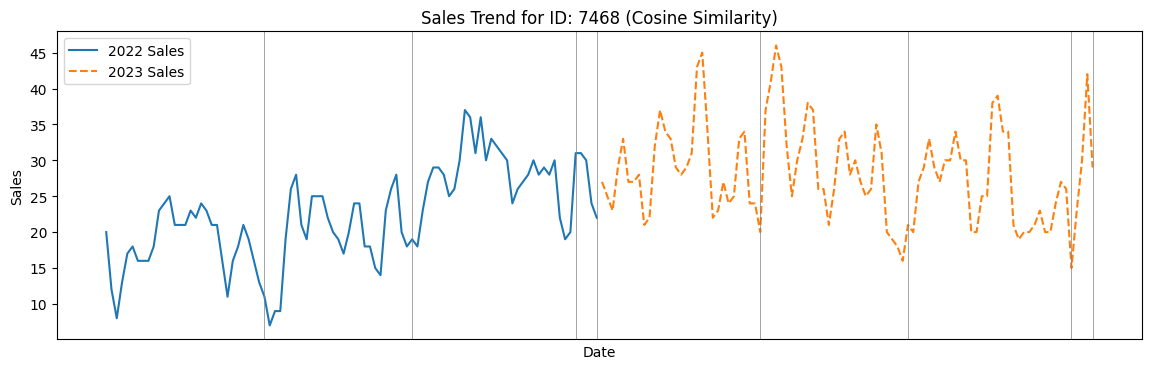

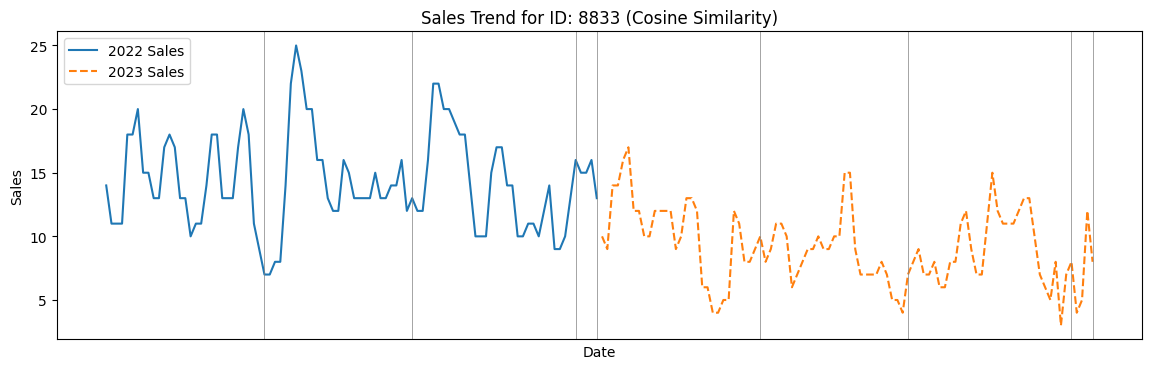

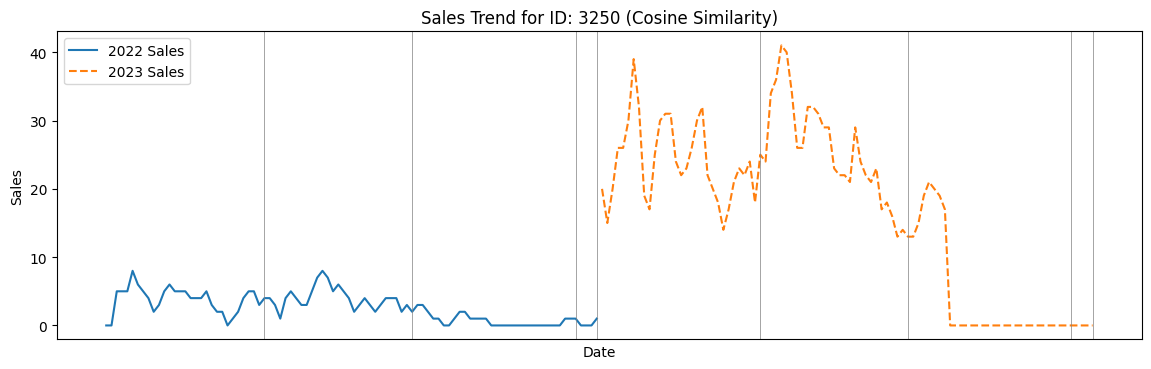

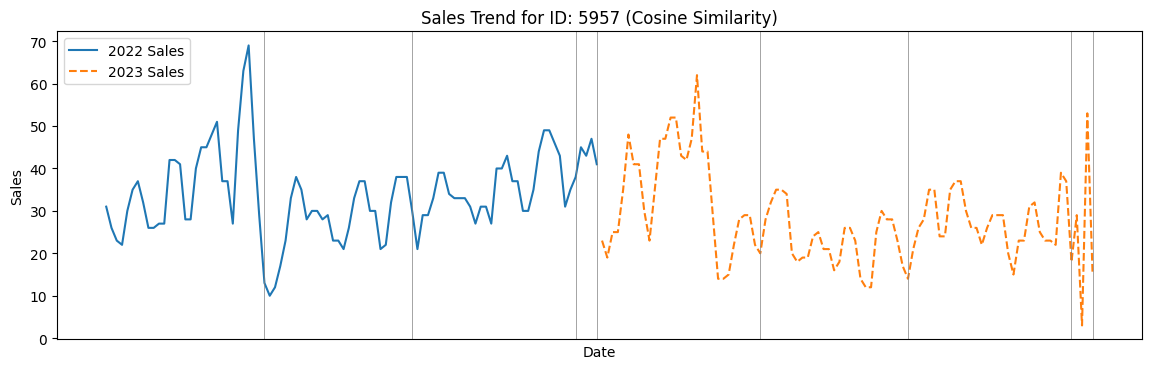

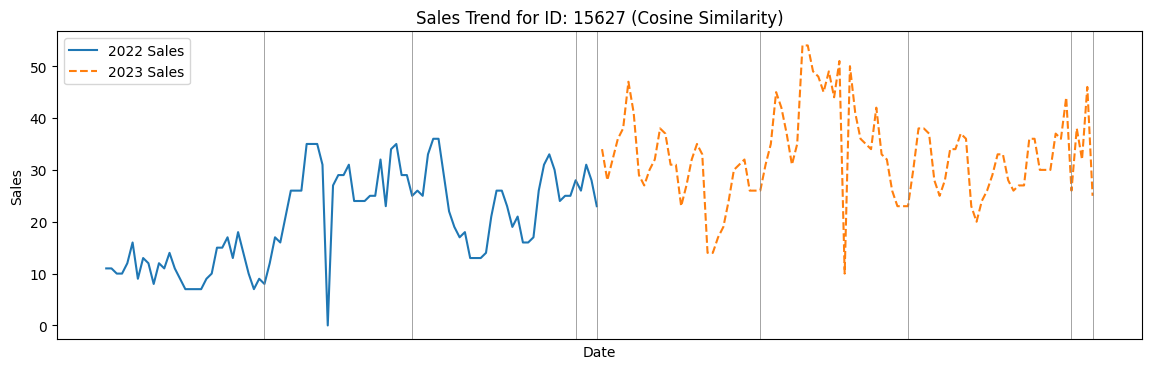

In [ ]:
# 샘플 데이터 추출 (첫 50개의 ID만 선택)
from sklearn.metrics import pairwise_distances

# 2022년 1월부터 4월 4일까지, 그리고 2023년 1월부터 4월 4일까지의 데이터 추출
columns_2022 = [col for col in train.columns if '2022-01' <= col <= '2022-04-04']
columns_2023 = [col for col in train.columns if '2023-01' <= col <= '2023-04-04']

# 해당 기간의 데이터만 추출
data_2022 = train[columns_2022]
data_2023 = train[columns_2023]

#sample_data_2022 = data_2022.head(50)
#sample_data_2023 = data_2023.head(50)

# 0의 값이 90% 이상인 ID 제외
filtered_sample_2022 = data_2022[data_2022.apply(lambda row: (row == 0).mean() < 0.9, axis=1)]
filtered_sample_2023 = data_2023.loc[filtered_sample_2022.index]

# 코사인 유사도 계산
cosine_similarities_sample = []
for idx in filtered_sample_2022.index:
    sales_2022 = filtered_sample_2022.loc[idx].values.reshape(1, -1)
    sales_2023 = filtered_sample_2023.loc[idx].values.reshape(1, -1)
    similarity = cosine_similarity(sales_2022, sales_2023)[0][0]
    cosine_similarities_sample.append((idx, similarity))

# 코사인 유사도가 높은 상위 5개의 ID 확인
top_sample_similarities = sorted(cosine_similarities_sample, key=lambda x: x[1], reverse=True)[:5]

# 각 ID의 판매량을 그래프로 표시 (월별 구분선 추가)
for idx, _ in top_sample_similarities:
    plt.figure(figsize=(14, 4))
    plt.plot(filtered_sample_2022.columns, filtered_sample_2022.loc[idx], label='2022 Sales')
    plt.plot(filtered_sample_2023.columns, filtered_sample_2023.loc[idx], label='2023 Sales', linestyle='--')

    # 월별 구분선 추가
    for month_end in ['2022-01-31', '2022-02-28', '2022-03-31', '2022-04-04', '2023-01-31', '2023-02-28', '2023-03-31','2023-04-04']:
        plt.axvline(x=month_end, color='gray', linestyle='-', linewidth=0.5)

    plt.title(f"Sales Trend for ID: {idx} (Cosine Similarity)")
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.xticks([])  # x축 레이블 제거
    plt.legend()
    plt.show()



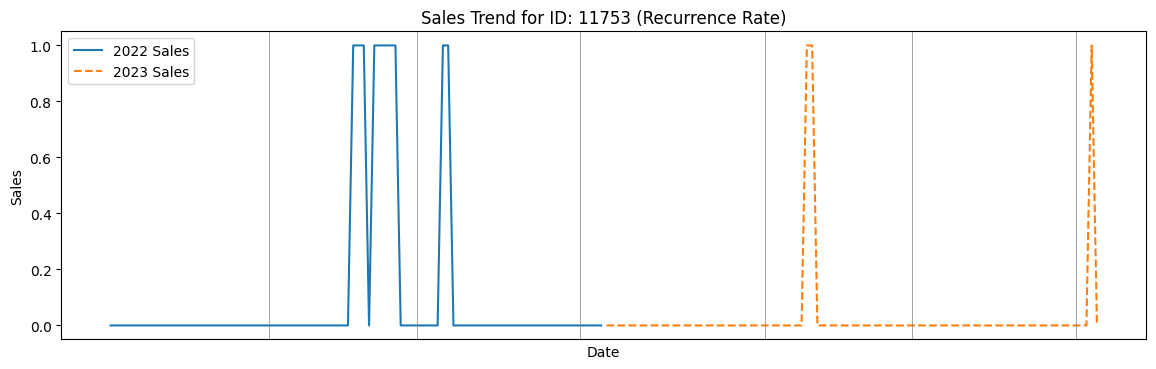

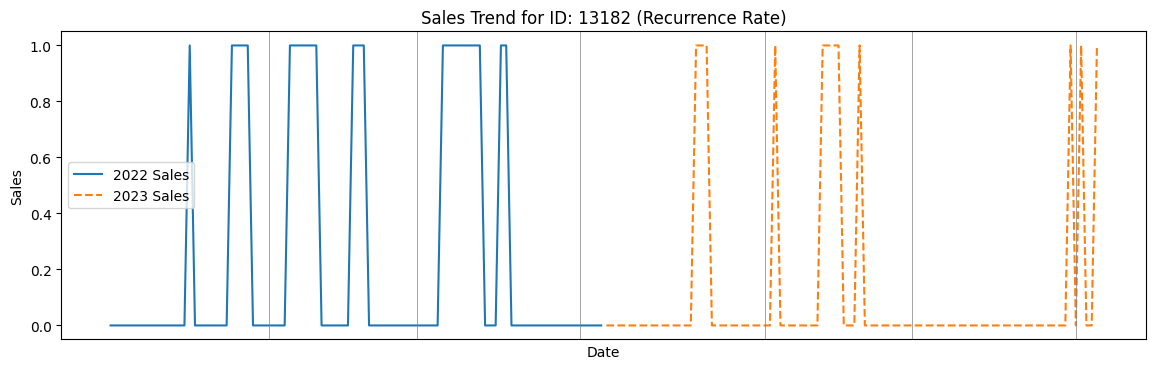

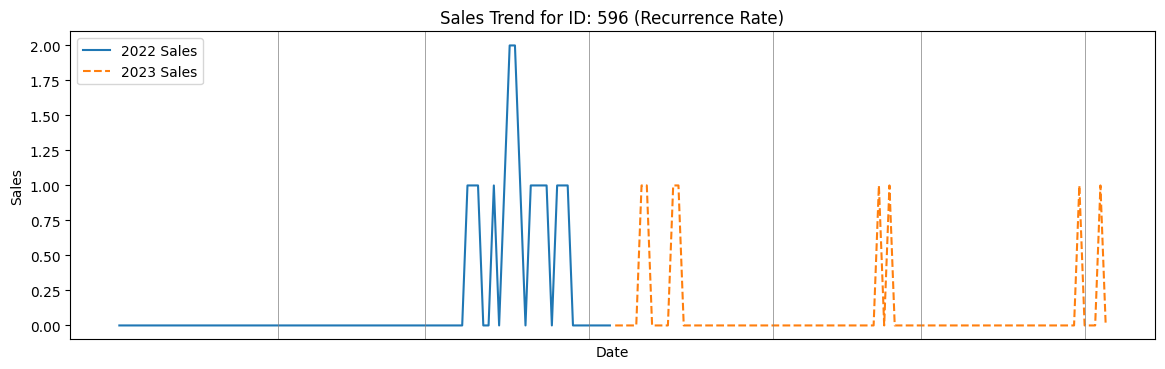

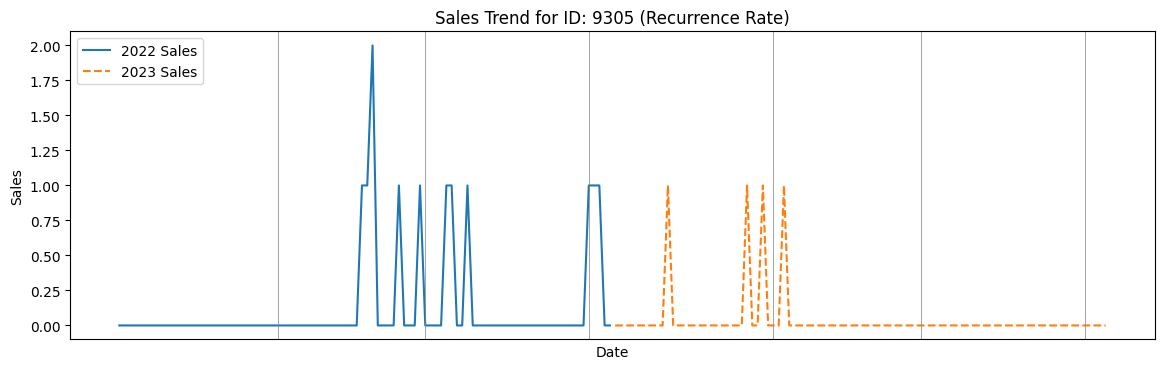

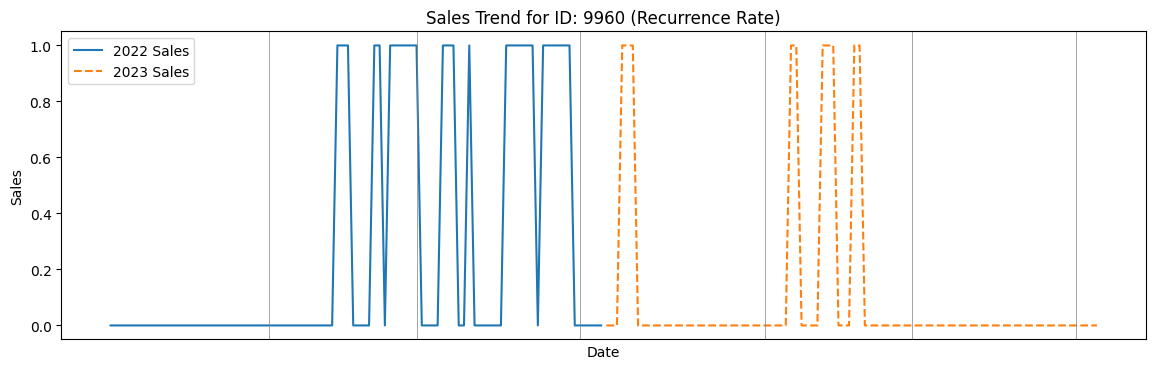

In [ ]:
from scipy.spatial.distance import cdist
from scipy.spatial.distance import euclidean

def dtw(x, y):
    distances = cdist(x.reshape(-1, 1), y.reshape(-1, 1), 'euclidean')
    accumulated_cost = np.zeros_like(distances)
    accumulated_cost[0, 0] = distances[0, 0]
    for i in range(1, distances.shape[0]):
        accumulated_cost[i, 0] = distances[i, 0] + accumulated_cost[i-1, 0]
    for j in range(1, distances.shape[1]):
        accumulated_cost[0, j] = distances[0, j] + accumulated_cost[0, j-1]
    for i in range(1, distances.shape[0]):
        for j in range(1, distances.shape[1]):
            accumulated_cost[i, j] = min(accumulated_cost[i-1, j], accumulated_cost[i, j-1], accumulated_cost[i-1, j-1]) + distances[i, j]
    return accumulated_cost[-1, -1]

# DTW 유사도 계산
dtw_similarities_sample = []
for idx in filtered_sample_2022.index:
    sales_2022 = filtered_sample_2022.loc[idx].values
    sales_2023 = filtered_sample_2023.loc[idx].values
    distance = dtw(sales_2022, sales_2023)
    dtw_similarities_sample.append((idx, distance))

# DTW 거리가 작은 상위 5개의 ID 확인
top_dtw_similarities = sorted(dtw_similarities_sample, key=lambda x: x[1])[:5]


# 각 ID의 판매량을 그래프로 표시 (월별 구분선 추가)
for idx, _ in top_dtw_similarities:
    plt.figure(figsize=(14, 4))
    plt.plot(filtered_sample_2022.columns, filtered_sample_2022.loc[idx], label='2022 Sales')
    plt.plot(filtered_sample_2023.columns, filtered_sample_2023.loc[idx], label='2023 Sales', linestyle='--')

    # 월별 구분선 추가
    for month_end in ['2022-01-31', '2022-02-28', '2022-03-31', '2023-01-31', '2023-02-28', '2023-03-31']:
        plt.axvline(x=month_end, color='gray', linestyle='-', linewidth=0.5)

    plt.title(f"Sales Trend for ID: {idx} (Recurrence Rate)")
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.xticks([])  # x축 레이블 제거
    plt.legend()
    plt.show()

In [ ]:
def lcss(x, y, epsilon=5):
    m = len(x)
    n = len(y)
    L = np.zeros((m+1, n+1))
    for i in range(m+1):
        for j in range(n+1):
            if i == 0 or j == 0:
                L[i, j] = 0
            elif abs(x[i-1] - y[j-1]) <= epsilon:
                L[i, j] = L[i-1, j-1] + 1
            else:
                L[i, j] = max(L[i-1, j], L[i, j-1])
    return L[m, n]

# LCSS 유사도 계산
lcss_similarities_sample = []
for idx in filtered_sample_2022.index:
    sales_2022 = filtered_sample_2022.loc[idx].values
    sales_2023 = filtered_sample_2023.loc[idx].values
    similarity = lcss(sales_2022, sales_2023)
    lcss_similarities_sample.append((idx, similarity))

# LCSS 유사도가 높은 상위 5개의 ID 확인
top_lcss_similarities = sorted(lcss_similarities_sample, key=lambda x: x[1], reverse=True)[:5]

# 각 ID의 판매량을 그래프로 표시 (월별 구분선 추가)
for idx, _ in top_lcss_similarities:
    plt.figure(figsize=(14, 4))
    plt.plot(filtered_sample_2022.columns, filtered_sample_2022.loc[idx], label='2022 Sales')
    plt.plot(filtered_sample_2023.columns, filtered_sample_2023.loc[idx], label='2023 Sales', linestyle='--')

    # 월별 구분선 추가
    for month_end in ['2022-01-31', '2022-02-28', '2022-03-31', '2022-04-04', '2023-01-31', '2023-02-28', '2023-03-31','2023-04-04']:
        plt.axvline(x=month_end, color='gray', linestyle='-', linewidth=0.5)

    plt.title(f"Sales Trend for ID: {idx} (Recurrence Rate)")
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.xticks([])  # x축 레이블 제거
    plt.legend()
    plt.show()

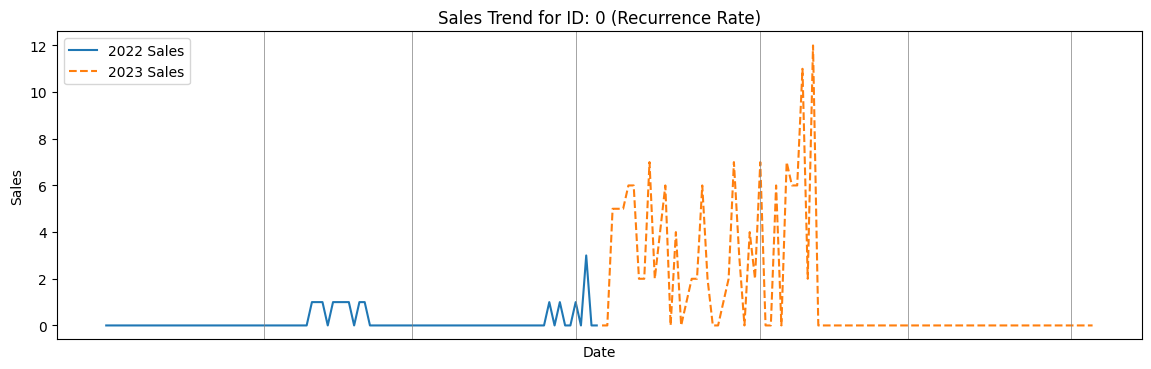

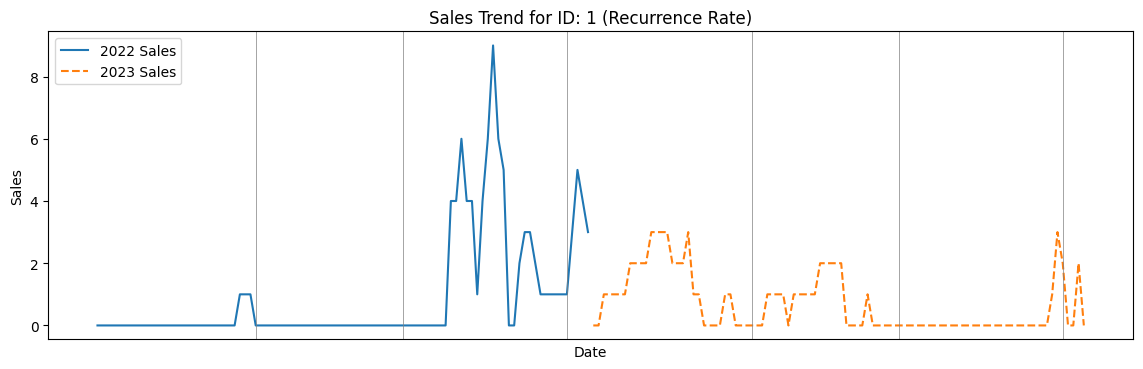

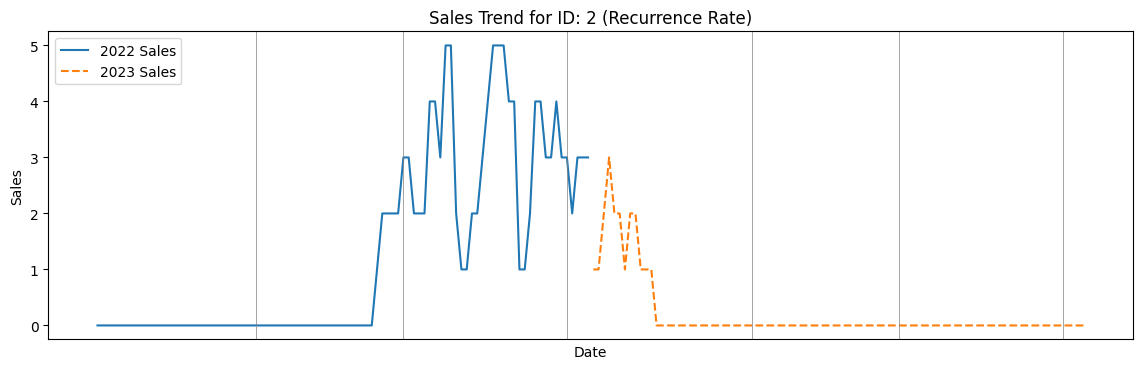

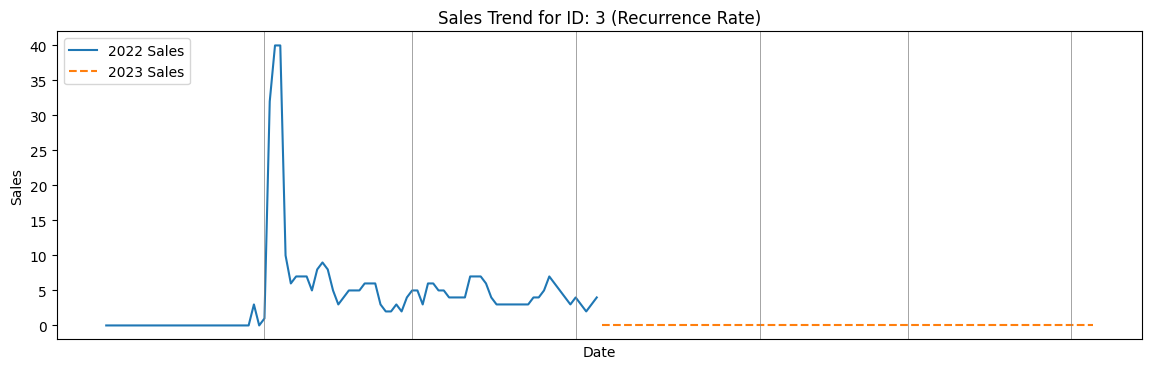

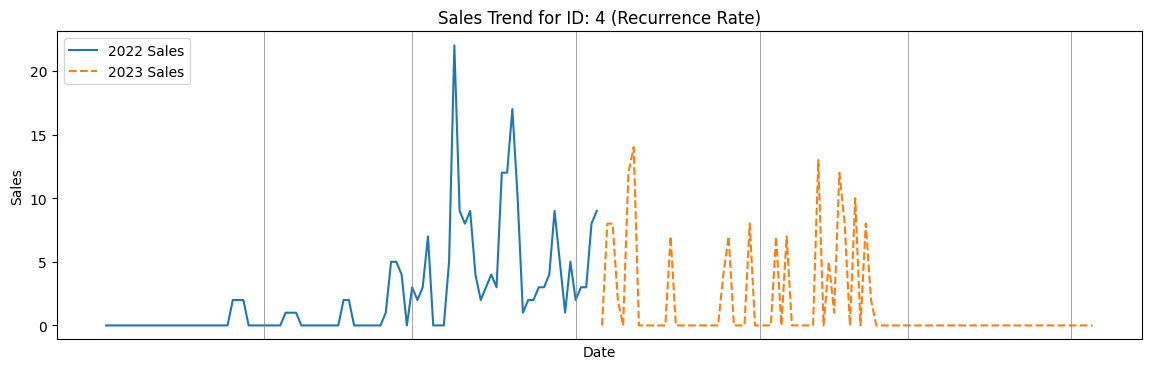

In [ ]:
# 상관 계수 계산
correlation_similarities_sample = []
for idx in filtered_sample_2022.index:
    sales_2022 = filtered_sample_2022.loc[idx]
    sales_2023 = filtered_sample_2023.loc[idx]
    similarity = sales_2022.corr(sales_2023)
    correlation_similarities_sample.append((idx, similarity))

# 상관 계수가 높은 상위 5개의 ID 확인
top_correlation_similarities = sorted(correlation_similarities_sample, key=lambda x: x[1], reverse=True)[:5]

# 각 ID의 판매량을 그래프로 표시 (월별 구분선 추가)
for idx, _ in top_correlation_similarities:
    plt.figure(figsize=(14, 4))
    plt.plot(filtered_sample_2022.columns, filtered_sample_2022.loc[idx], label='2022 Sales')
    plt.plot(filtered_sample_2023.columns, filtered_sample_2023.loc[idx], label='2023 Sales', linestyle='--')

    # 월별 구분선 추가
    for month_end in ['2022-01-31', '2022-02-28', '2022-03-31', '2023-01-31', '2023-02-28', '2023-03-31']:
        plt.axvline(x=month_end, color='gray', linestyle='-', linewidth=0.5)

    plt.title(f"Sales Trend for ID: {idx} (Recurrence Rate)")
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.xticks([])  # x축 레이블 제거
    plt.legend()
    plt.show()

In [ ]:
def recurrence_rate(matrix):
    return np.sum(matrix) / (matrix.shape[0] * matrix.shape[1])
def recurrence_plot(x, y, epsilon=0.1):
    distances = cdist(x.reshape(-1, 1), y.reshape(-1, 1), 'euclidean')
    return distances < epsilon

# 모든 ID에 대한 재발 비율 계산
recurrence_rates_sample = []
for idx in filtered_sample_2022.index:
    sales_2022 = filtered_sample_2022.loc[idx].values
    sales_2023 = filtered_sample_2023.loc[idx].values
    recurrence_matrix = recurrence_plot(sales_2022, sales_2023)
    recurrence_rate_value = recurrence_rate(recurrence_matrix)
    recurrence_rates_sample.append((idx, recurrence_rate_value))

# 재발 비율이 높은 상위 5개의 ID 확인
top_recurrence_rates = sorted(recurrence_rates_sample, key=lambda x: x[1], reverse=True)[:5]

# 결과 확인
# 각 ID의 판매량을 그래프로 표시
for idx, _ in top_recurrence_rates:
    plt.figure(figsize=(14, 4))
    plt.plot(filtered_sample_2022.columns, filtered_sample_2022.loc[idx], label='2022 Sales')
    plt.plot(filtered_sample_2023.columns, filtered_sample_2023.loc[idx], label='2023 Sales', linestyle='--')
    plt.title(f"Sales Trend for ID: {idx} (Cosine Similarity)")
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.xticks([])  # x축 레이블 제거
    plt.legend()
    plt.show()

<ipython-input-37-aeff952c196b>:12: RuntimeWarning: invalid value encountered in double_scalars
  seasonal_similarity = np.dot(s_2022, s_2023) / (np.linalg.norm(s_2022) * np.linalg.norm(s_2023))


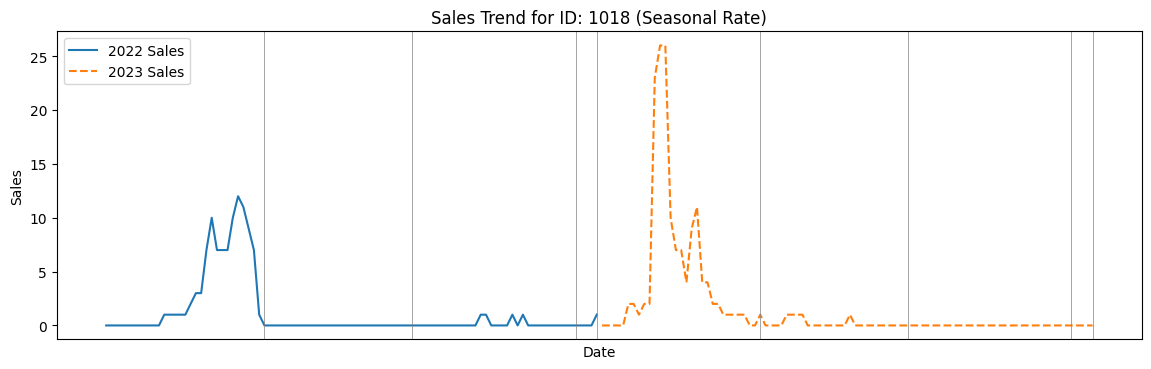

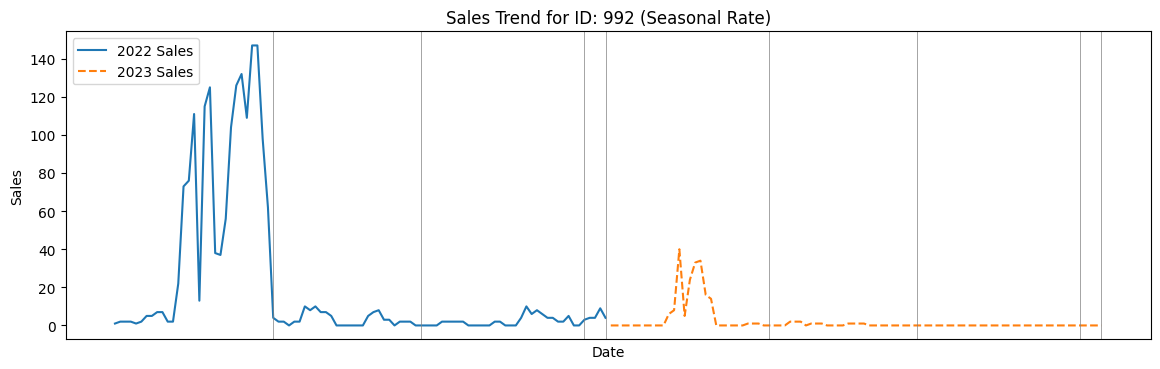

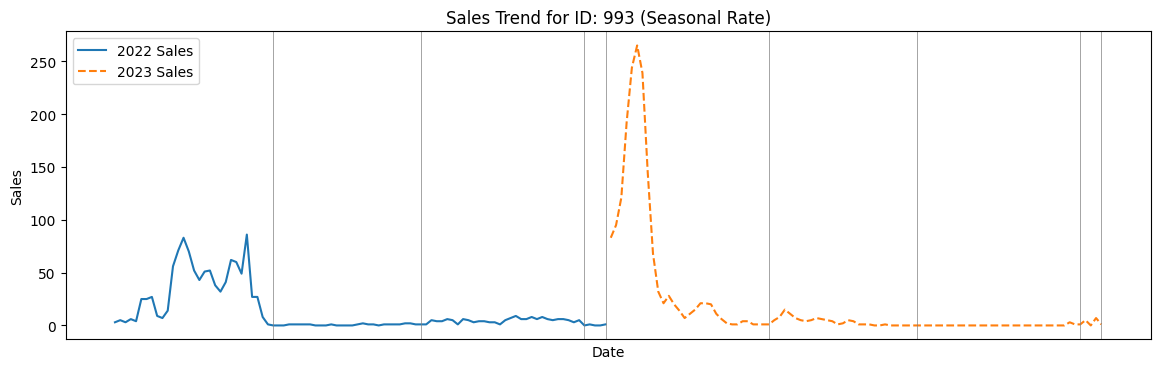

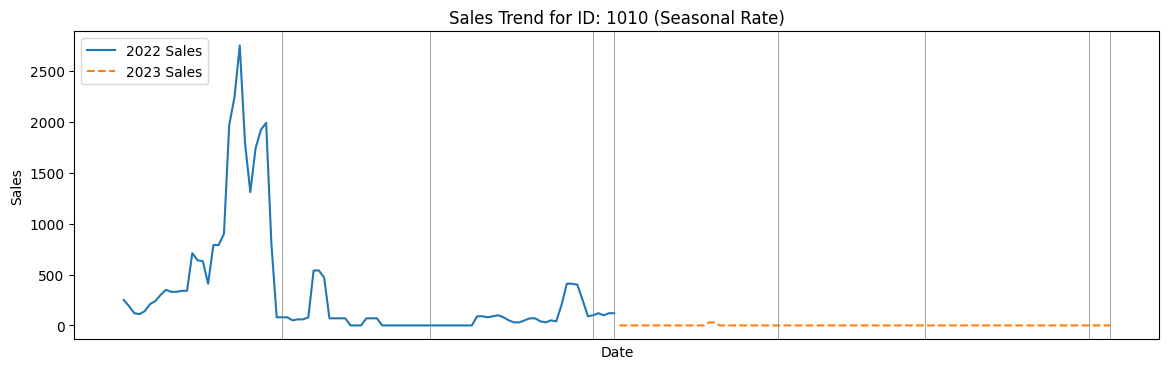

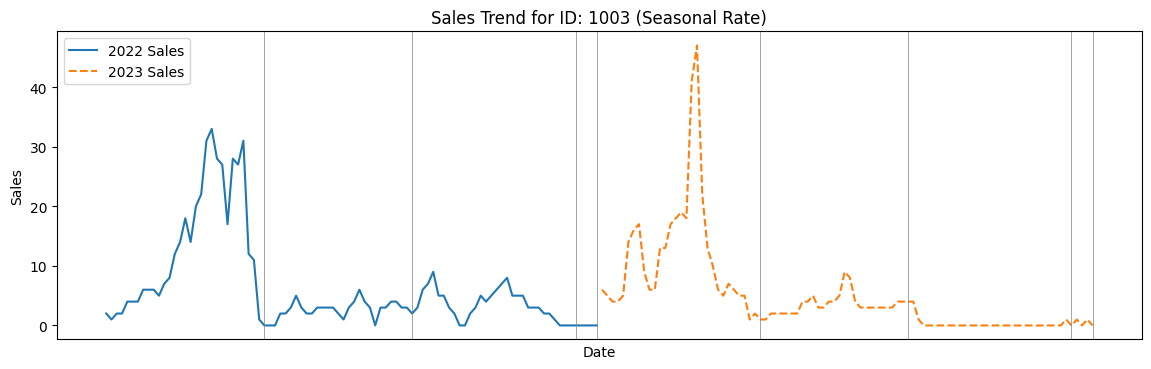

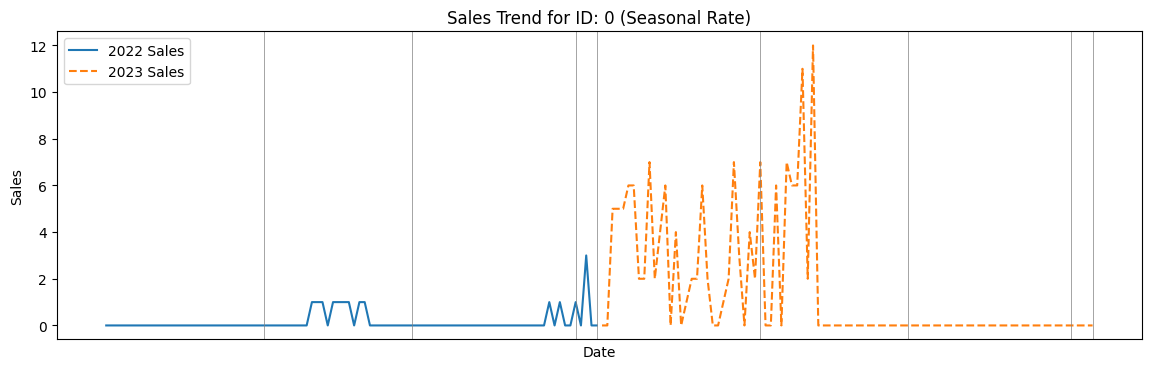

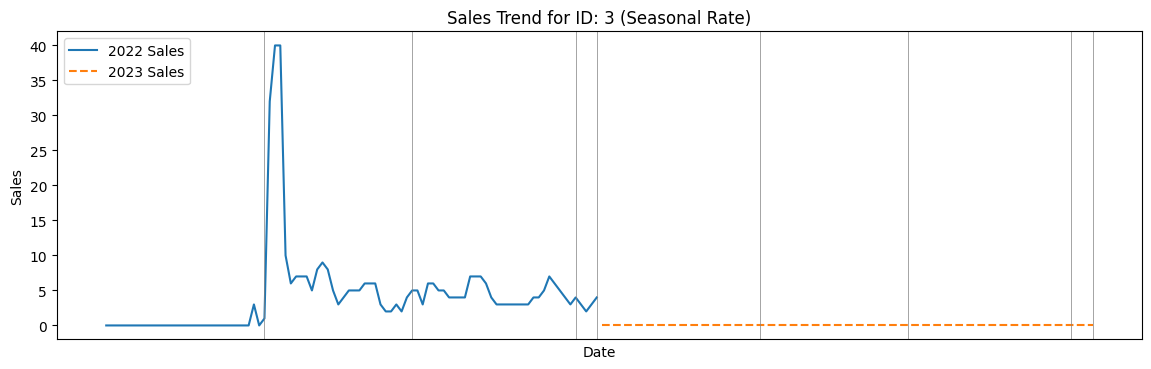

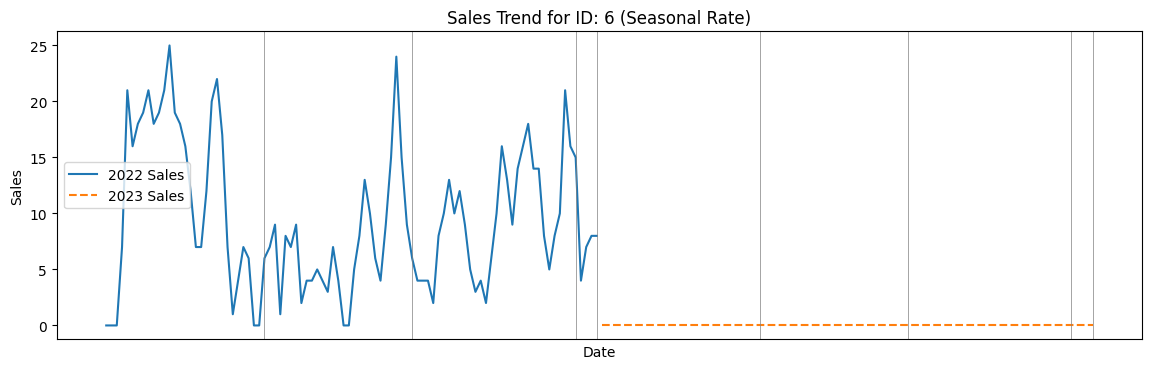

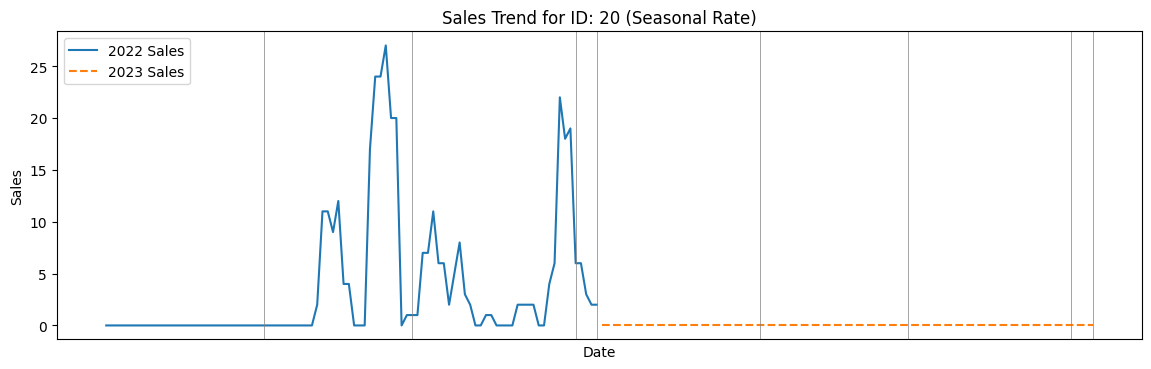

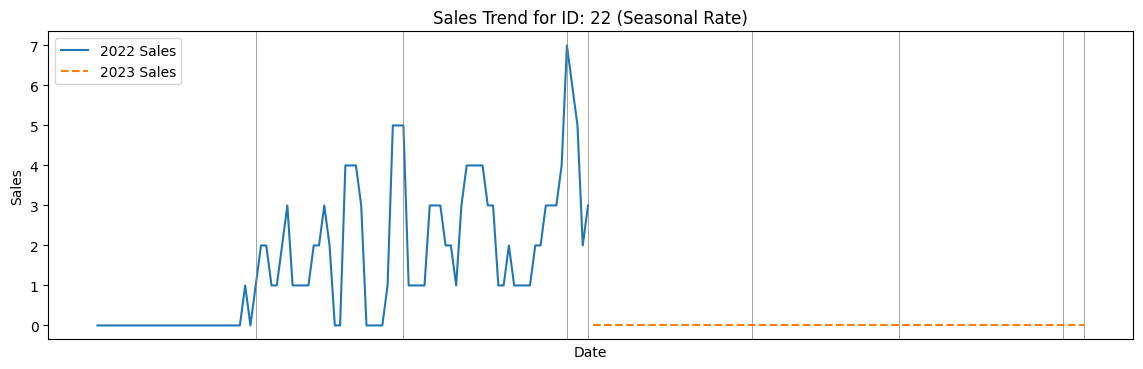

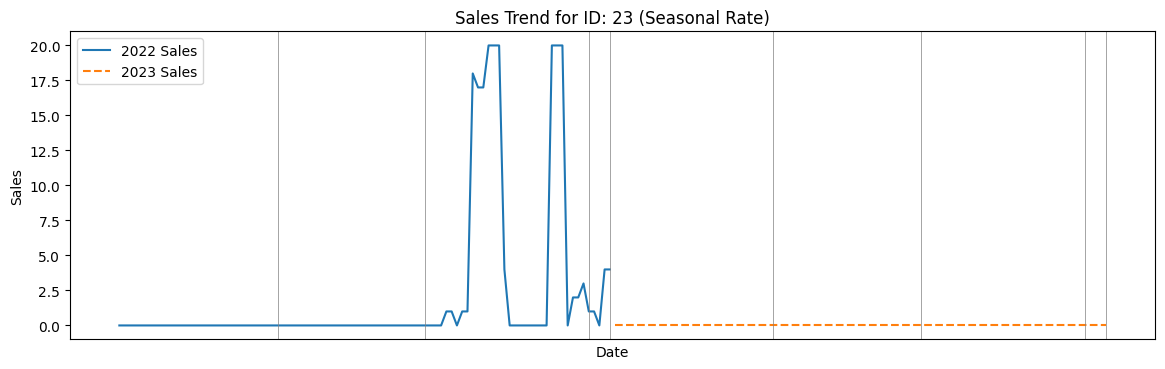

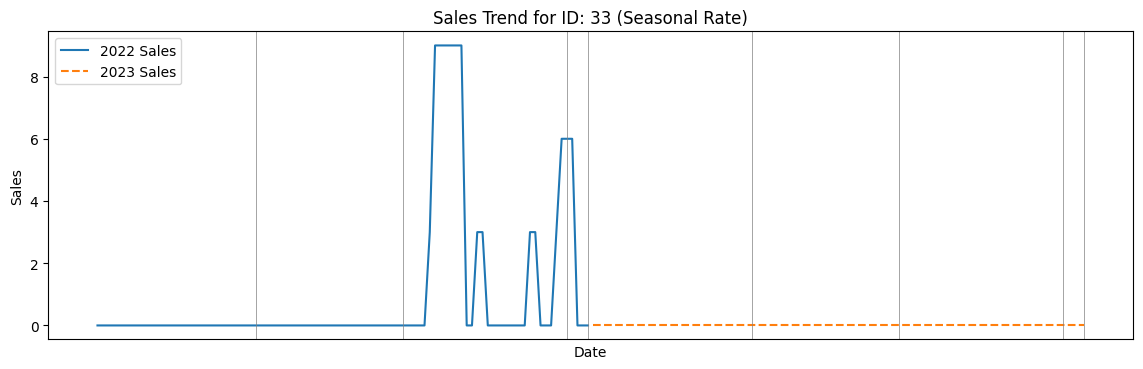

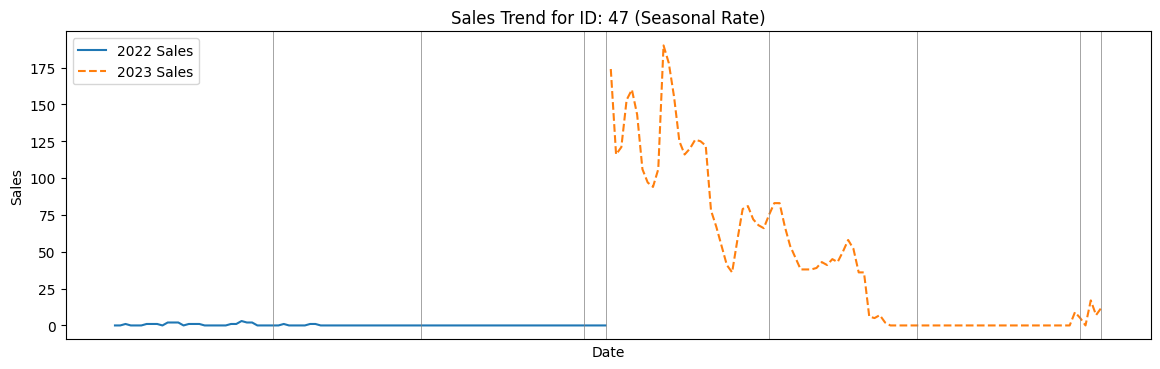

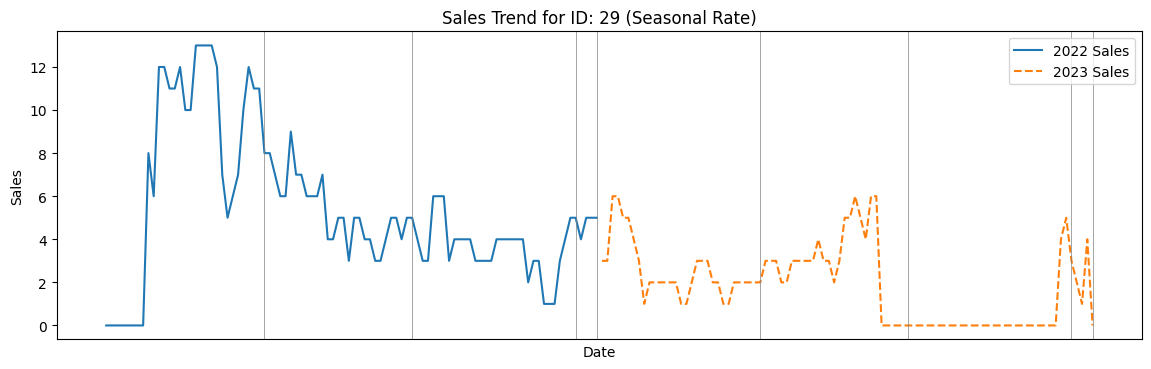

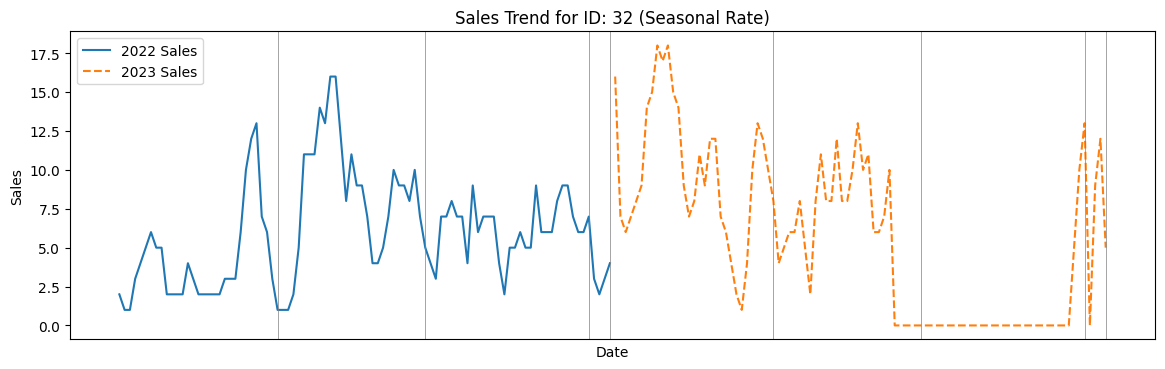

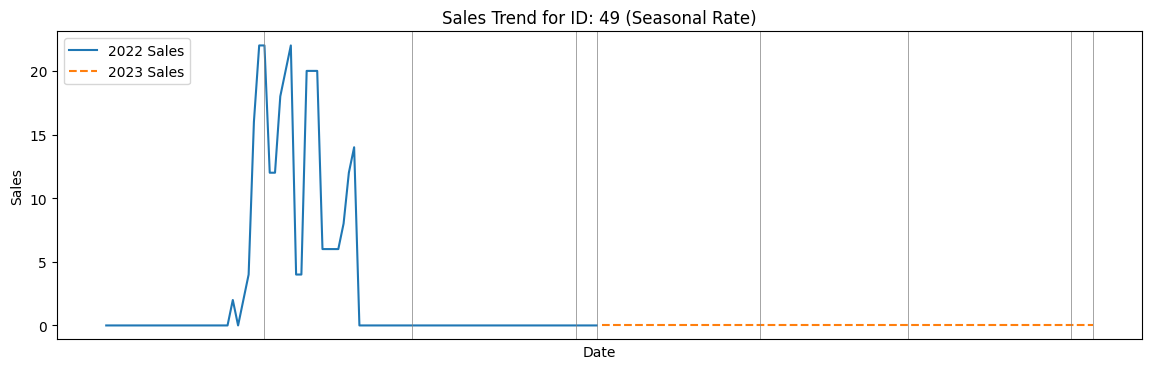

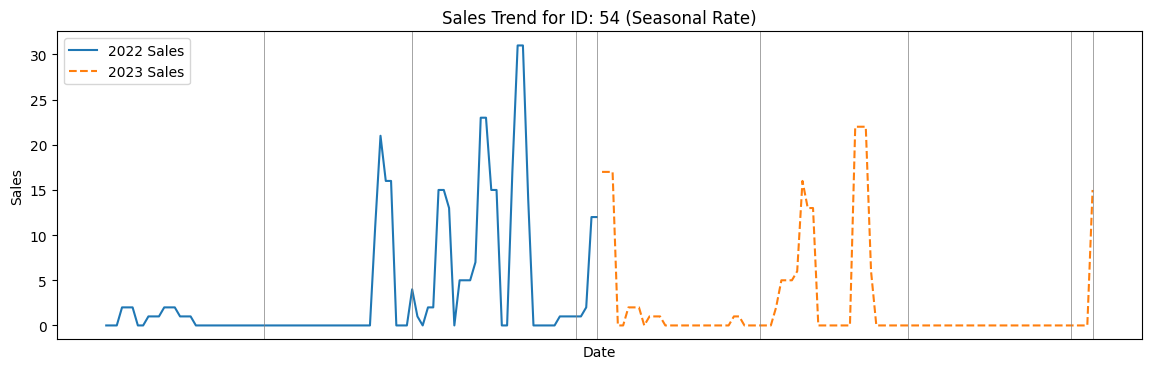

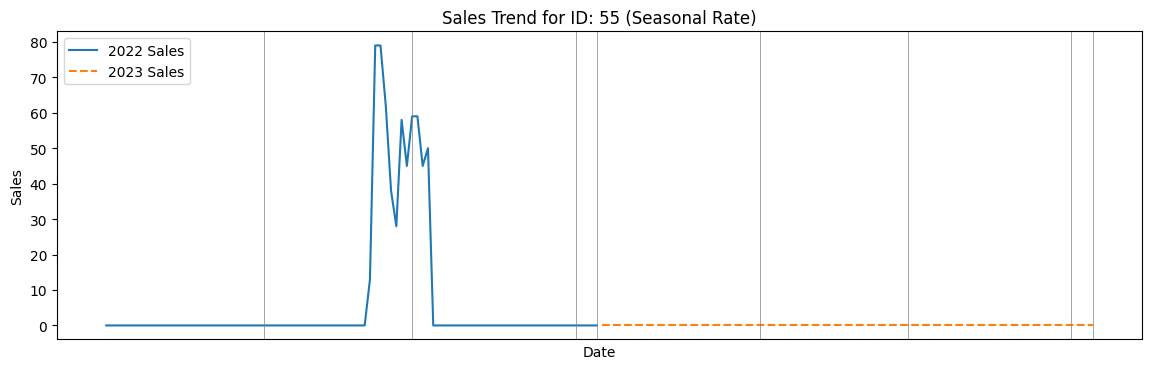

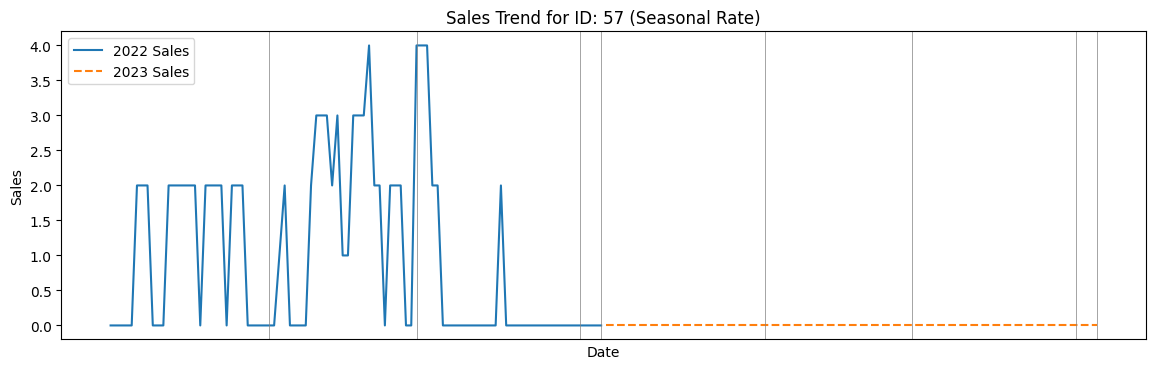

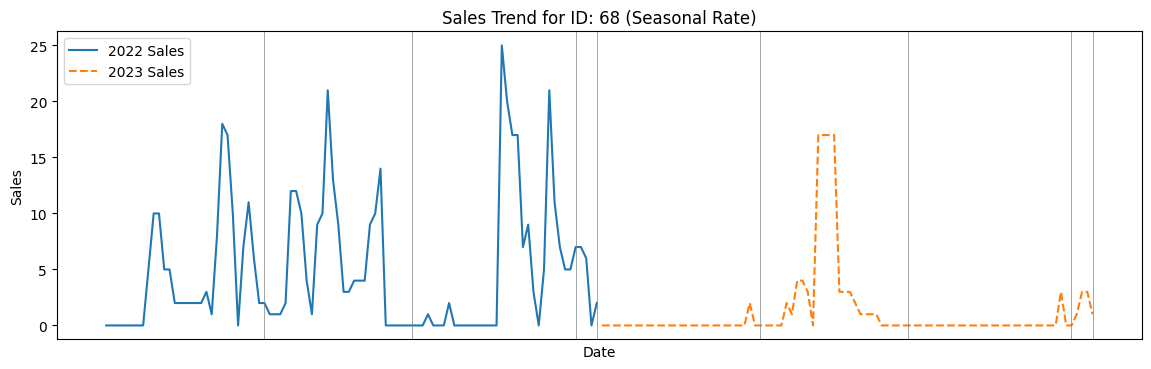

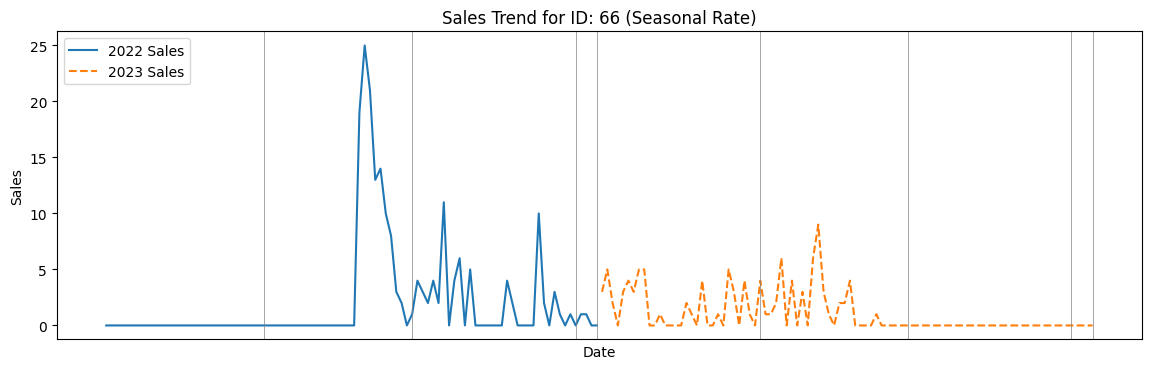

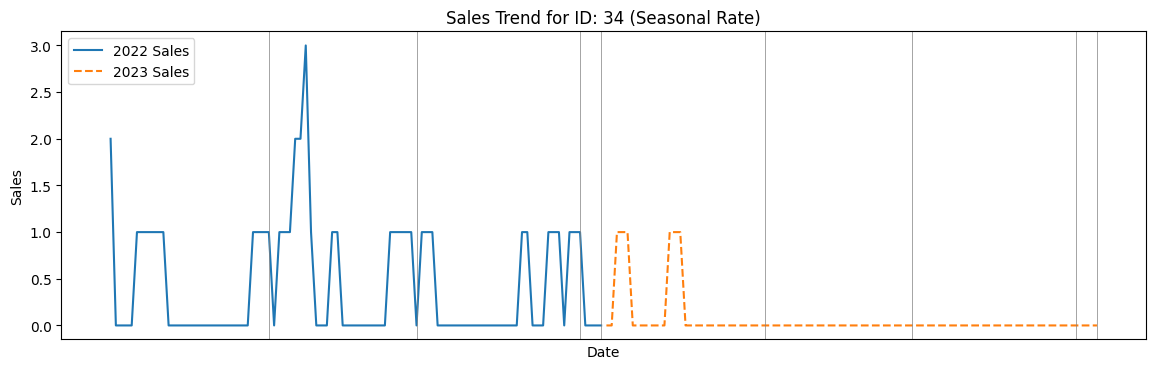

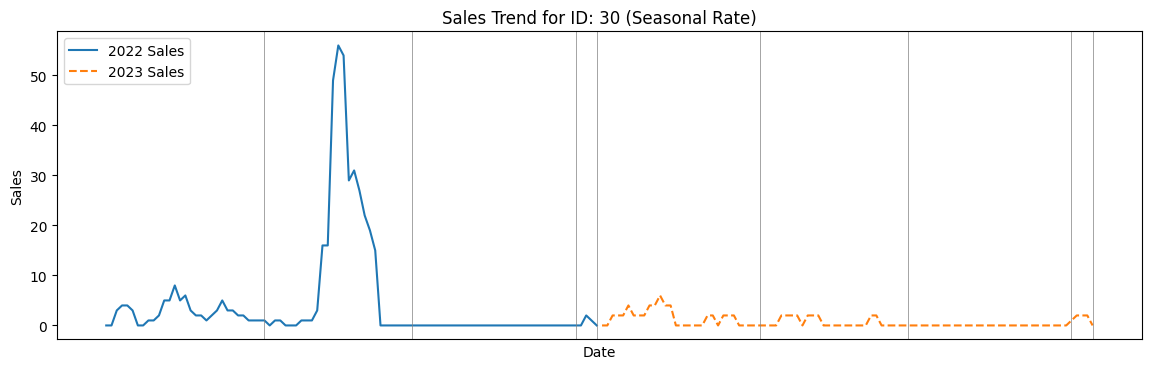

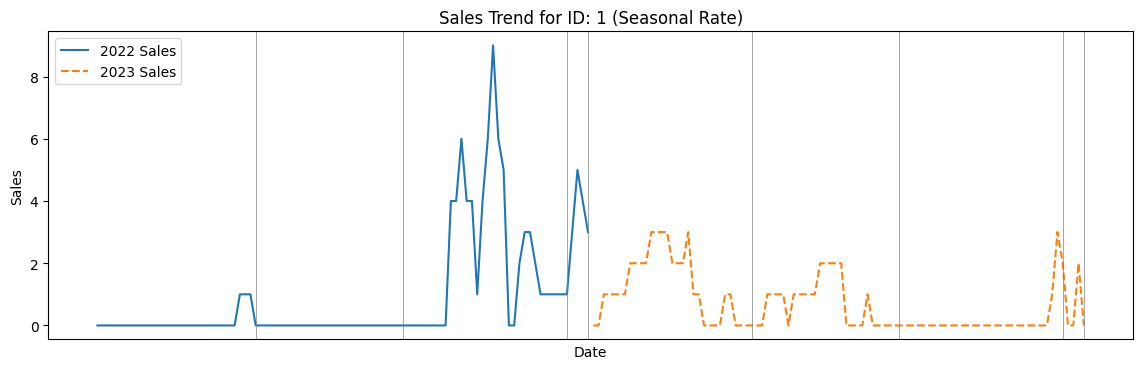

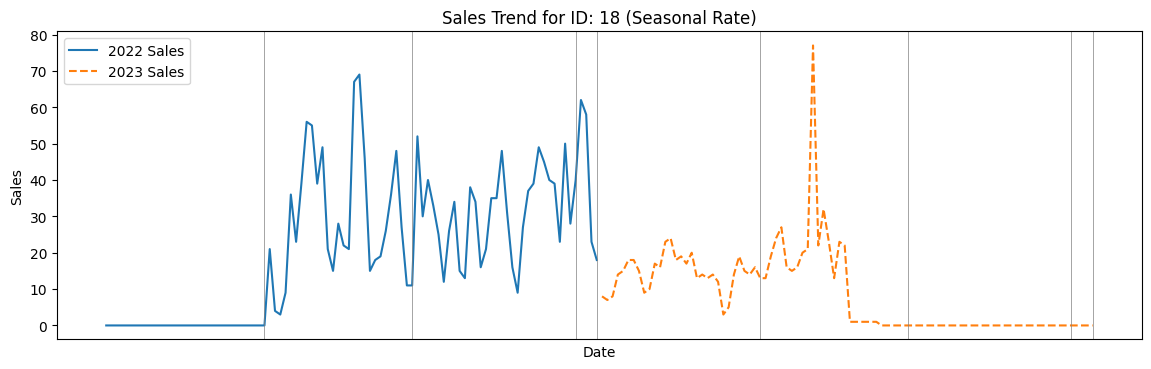

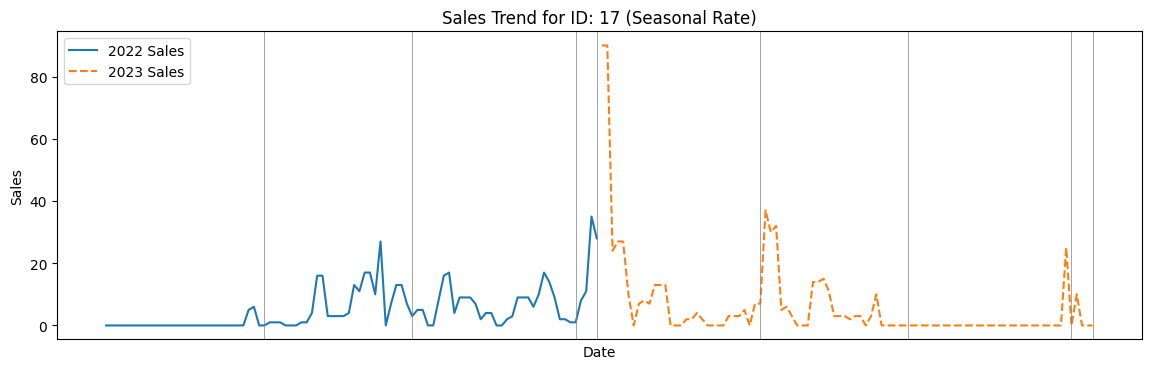

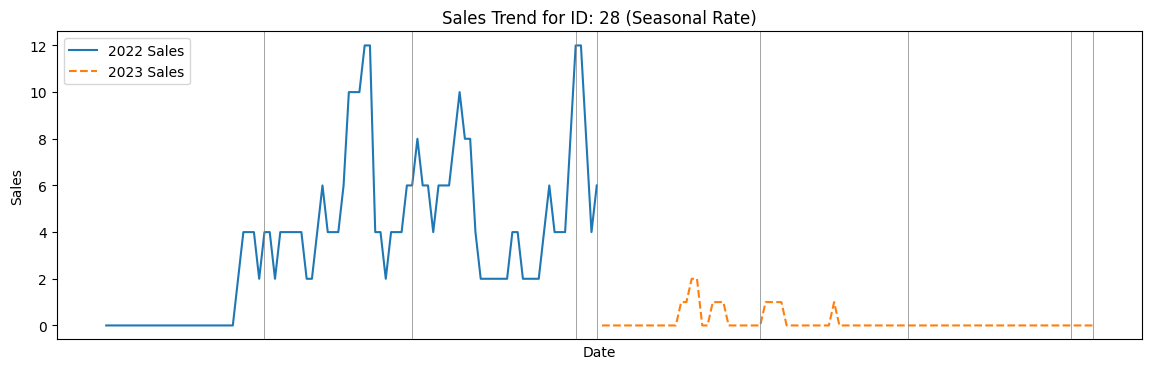

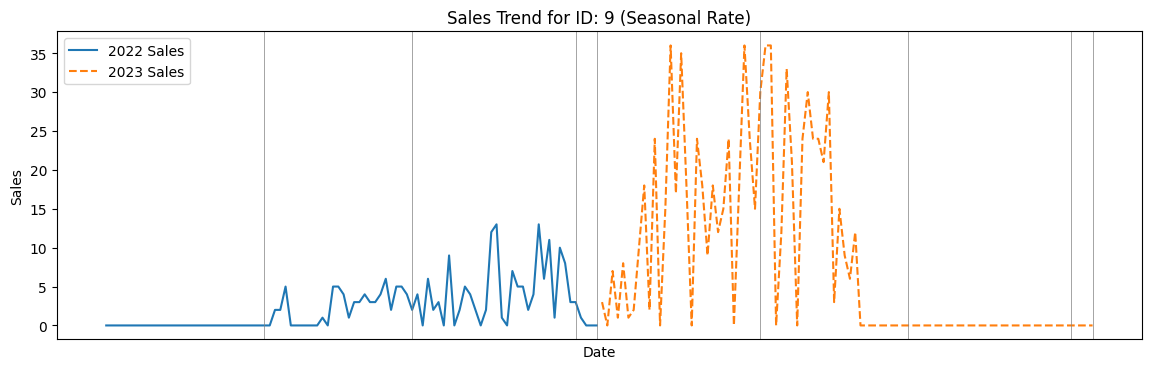

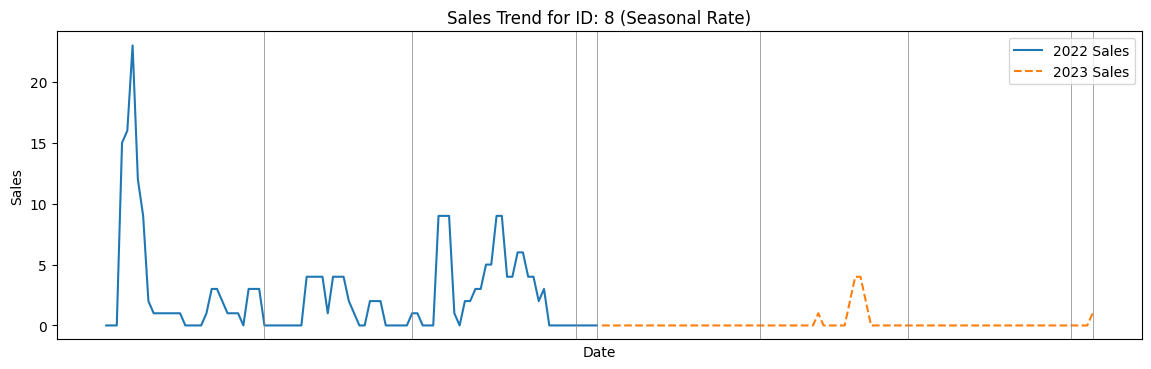

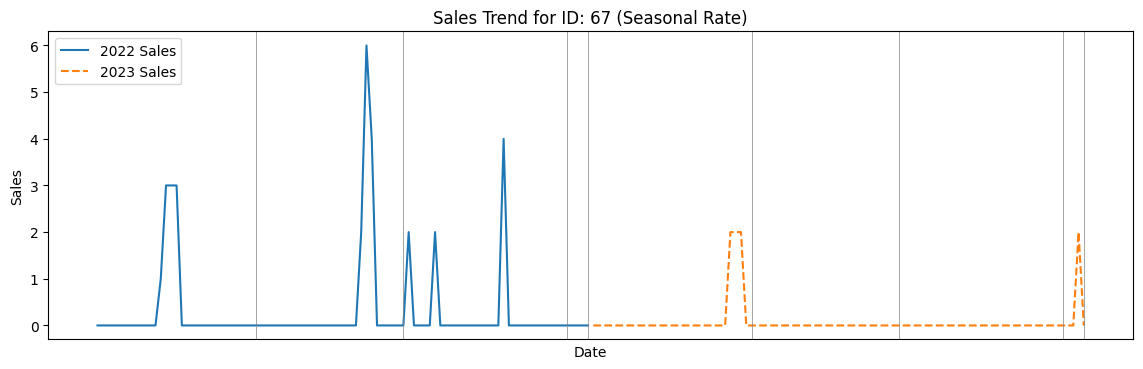

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

# 월별 평균을 사용하여 시즌성 성분 추출
seasonal_2022 = filtered_sample_2022.groupby(by=lambda x: x.split("-")[1], axis=1).mean()
seasonal_2023 = filtered_sample_2023.groupby(by=lambda x: x.split("-")[1], axis=1).mean()

# 시즌성 성분의 유사도 계산
seasonal_similarities_sample = []
for idx in seasonal_2022.index:
    s_2022 = seasonal_2022.loc[idx].values
    s_2023 = seasonal_2023.loc[idx].values
    seasonal_similarity = np.dot(s_2022, s_2023) / (np.linalg.norm(s_2022) * np.linalg.norm(s_2023))
    seasonal_similarities_sample.append((idx, seasonal_similarity))

# 시즌성 유사도가 높은 상위 5개의 ID 확인
top_seasonal_similarities = sorted(seasonal_similarities_sample, key=lambda x: x[1], reverse=True)[:30]
# 각 ID의 판매량을 그래프로 표시 (월별 구분선 추가)
# 각 ID의 판매량을 그래프로 표시 (월별 구분선 추가)
for idx, _ in top_seasonal_similarities:
    plt.figure(figsize=(14, 4))
    plt.plot(filtered_sample_2022.columns, filtered_sample_2022.loc[idx], label='2022 Sales')
    plt.plot(filtered_sample_2023.columns, filtered_sample_2023.loc[idx], label='2023 Sales', linestyle='--')

    # 월별 구분선 추가
    for month_end in ['2022-01-31', '2022-02-28', '2022-03-31', '2022-04-04', '2023-01-31', '2023-02-28', '2023-03-31','2023-04-04']:
        plt.axvline(x=month_end, color='gray', linestyle='-', linewidth=0.5)

    plt.title(f"Sales Trend for ID: {idx} (Seasonal Rate)")
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.xticks([])  # x축 레이블 제거
    plt.legend()
    plt.show()



In [ ]:
# 지정된 기간 내의 날짜별로 모든 값이 0인 ID들의 개수 계산
zero_ids_count_by_date = {}
specified_period_full = date_columns_as_dates[(date_columns_as_dates >= '2023-02-23') & (date_columns_as_dates <= '2023-04-04')]

for date in specified_period_full:
    date_str = date.strftime('%Y-%m-%d')
    zero_ids_count_by_date[date_str] = (train[date_str] == 0).sum()

zero_ids_count_by_date


{'2023-02-23': 15060,
 '2023-02-24': 15101,
 '2023-02-25': 15111,
 '2023-02-26': 15136,
 '2023-02-27': 15134,
 '2023-02-28': 15127,
 '2023-03-01': 15085,
 '2023-03-02': 15079,
 '2023-03-03': 15068,
 '2023-03-04': 15091,
 '2023-03-05': 15111,
 '2023-03-06': 15147,
 '2023-03-07': 15245,
 '2023-03-08': 15270,
 '2023-03-09': 15259,
 '2023-03-10': 15261,
 '2023-03-11': 15320,
 '2023-03-12': 15331,
 '2023-03-13': 15438,
 '2023-03-14': 15422,
 '2023-03-15': 15415,
 '2023-03-16': 15389,
 '2023-03-17': 15387,
 '2023-03-18': 15382,
 '2023-03-19': 15406,
 '2023-03-20': 15418,
 '2023-03-21': 15399,
 '2023-03-22': 15393,
 '2023-03-23': 15374,
 '2023-03-24': 15385,
 '2023-03-25': 15398,
 '2023-03-26': 15414,
 '2023-03-27': 15414,
 '2023-03-28': 15405,
 '2023-03-29': 12085,
 '2023-03-30': 12097,
 '2023-03-31': 12243,
 '2023-04-01': 12414,
 '2023-04-02': 12354,
 '2023-04-03': 11862,
 '2023-04-04': 11867}

In [ ]:
train

ID                제품             대분류             중분류  \
0          0  B002-00001-00001  B002-C001-0002  B002-C002-0007   
1          1  B002-00002-00001  B002-C001-0003  B002-C002-0008   
2          2  B002-00002-00002  B002-C001-0003  B002-C002-0008   
3          3  B002-00002-00003  B002-C001-0003  B002-C002-0008   
4          4  B002-00003-00001  B002-C001-0001  B002-C002-0001   
...      ...               ...             ...             ...   
15885  15885  B002-03799-00002  B002-C001-0003  B002-C002-0008   
15886  15886  B002-03799-00003  B002-C001-0003  B002-C002-0008   
15887  15887  B002-03799-00004  B002-C001-0003  B002-C002-0008   
15888  15888  B002-03799-00005  B002-C001-0003  B002-C002-0008   
15889  15889  B002-03799-00010  B002-C001-0002  B002-C002-0004   

                  소분류         브랜드  2022-01-01  2022-01-02  2022-01-03  \
0      B002-C003-0038  B002-00001           0           0           0   
1      B002-C003-0044  B002-00002           0           0           0   
2      B002-C003-0044  B002-00002           0           0           0   
3      B002-C003-0044  B002-00002           0           0           0   
4      B002-C003-0003  B002-00003           0           0           0   
...               ...         ...         ...         ...         ...   
15885  B002-C003-0042  B002-03799           0           0           0   
15886  B002-C003-0044  B002-03799           0           0           0   
15887  B002-C003-0044  B002-03799           0           0           0   
15888  B002-C003-0044  B002-03799           0           0           0   
15889  B002-C003-0020  B002-03799           0           0           0   

       2022-01-04  ...  2023-03-26  2023-03-27  2023-03-28  2023-03-29  \
0               0  ...           0           0           0           0   
1               0  ...           0           0           0           1   
2               0  ...           0           0           0           0   
3               0  ...           0           0           0           0   
4               0  ...           0           0           0           0   
...           ...  ...         ...         ...         ...         ...   
15885           0  ...           0           0           0           0   
15886           0  ...           0           0           0           3   
15887           0  ...           0           0           0           0   
15888           0  ...           0           0           0           0   
15889           0  ...           0           0           0           0   

       2023-03-30  2023-03-31  2023-04-01  2023-04-02  2023-04-03  2023-04-04  
0               0           0           0           0           0           0  
1               3           2           0           0           2           0  
2               0           0           0           0           0           0  
3               0           0           0           0           0           0  
4               0           0           0           0           0           0  
...           ...         ...         ...         ...         ...         ...  
15885           0           0           0           0           0           0  
15886           0           2           4           1           1           3  
15887           0           0           0           0           0           0  
15888           0           0           0           0           0           2  
15889           0           0           0           0           0           0  

[15890 rows x 465 columns]

In [ ]:
specified_period_full

DatetimeIndex(['2023-02-23', '2023-02-24', '2023-02-25', '2023-02-26',
               '2023-02-27', '2023-02-28', '2023-03-01', '2023-03-02',
               '2023-03-03'],
              dtype='datetime64[ns]', freq=None)

In [ ]:
train.loc[0,'2023-02-23' : '2023-03-24']

2023-02-23    0
2023-02-24    0
2023-02-25    0
2023-02-26    0
2023-02-27    0
2023-02-28    0
2023-03-01    0
2023-03-02    0
2023-03-03    0
2023-03-04    0
2023-03-05    0
2023-03-06    0
2023-03-07    0
2023-03-08    0
2023-03-09    0
2023-03-10    0
2023-03-11    0
2023-03-12    0
2023-03-13    0
2023-03-14    0
2023-03-15    0
2023-03-16    0
2023-03-17    0
2023-03-18    0
2023-03-19    0
2023-03-20    0
2023-03-21    0
2023-03-22    0
2023-03-23    0
2023-03-24    0
Name: 0, dtype: object

In [ ]:
zero_counts_by_index = {}

for index in train.index:
    values_in_period = train.loc[index, '2023-02-23': '2023-03-28']
    zero_or_not = np.where((values_in_period == 0).all(), 1, 0)
    zero_counts_by_index[index] = zero_or_not
total_sum = sum(zero_counts_by_index.values())
print(total_sum)


14722


In [ ]:
zero_counts_by_index = {}

for index in train.index:
    values_in_period = train.loc[index, '2023-02-22': '2023-03-28']
    zero_or_not = np.where((values_in_period == 0).all(), 1, 0)
    zero_counts_by_index[index] = zero_or_not
total_sum = sum(zero_counts_by_index.values())
print(total_sum)


9765


In [ ]:
zero_counts_by_index = {}

for index in train.index:
    values_in_period = train.loc[index, '2023-02-23': '2023-03-29']
    zero_or_not = np.where((values_in_period == 0).all(), 1, 0)
    zero_counts_by_index[index] = zero_or_not
total_sum = sum(zero_counts_by_index.values())
print(total_sum)


11527


In [ ]:
zero_counts_by_index = {}

for index in train.index:
    values_in_period = train.loc[index, '2023-01-01': '2023-02-01']
    zero_or_not = np.where((values_in_period == 0).all(), 1, 0)
    zero_counts_by_index[index] = zero_or_not
total_sum = sum(zero_counts_by_index.values())
print(total_sum)


6698


In [ ]:
zero_counts_by_index = {}

for index in train.index:
    values_in_period = train.loc[index, '2022-12-01': '2023-01-01']
    zero_or_not = np.where((values_in_period == 0).all(), 1, 0)
    zero_counts_by_index[index] = zero_or_not
total_sum = sum(zero_counts_by_index.values())
print(total_sum)


6778


In [ ]:
zero_counts_by_index = {}

for index in train.index:
    values_in_period = train.loc[index, '2022-03-01': '2022-04-01']
    zero_or_not = np.where((values_in_period == 0).all(), 1, 0)
    zero_counts_by_index[index] = zero_or_not
total_sum = sum(zero_counts_by_index.values())
print(total_sum)


6506


In [ ]:
zero_counts_by_index = {}

for index in train.index:
    values_in_period = train.loc[index, '2022-02-01': '2022-03-01']
    zero_or_not = np.where((values_in_period == 0).all(), 1, 0)
    zero_counts_by_index[index] = zero_or_not
total_sum = sum(zero_counts_by_index.values())
print(total_sum)


7226


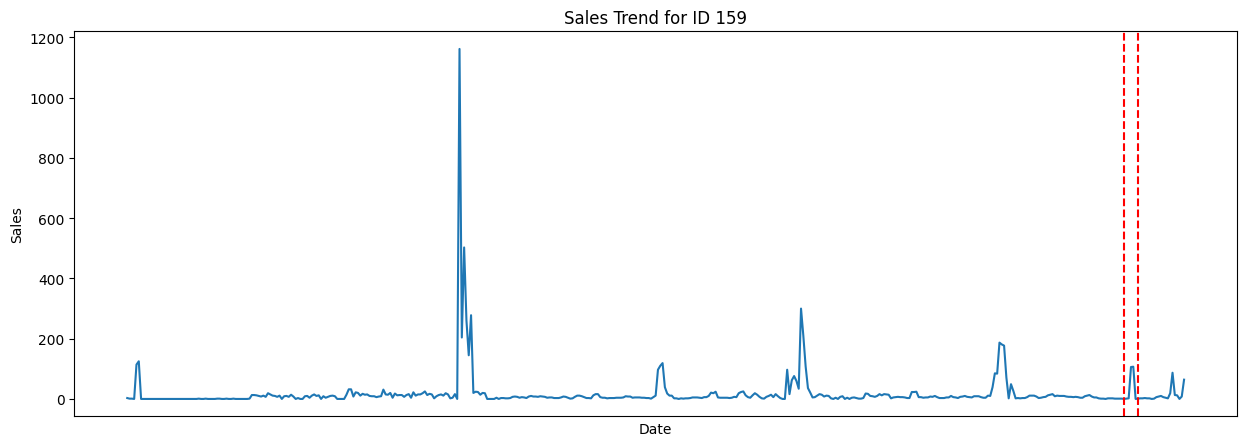

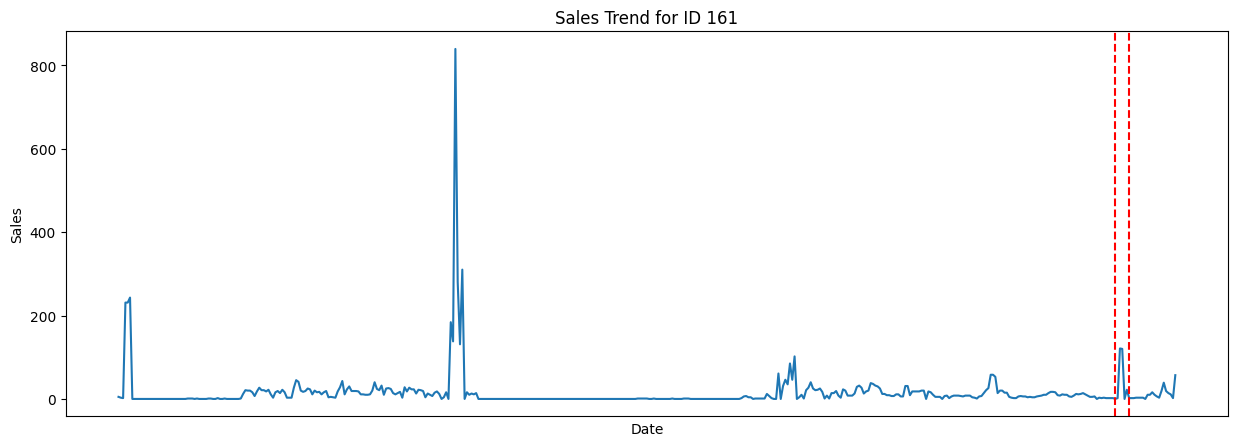

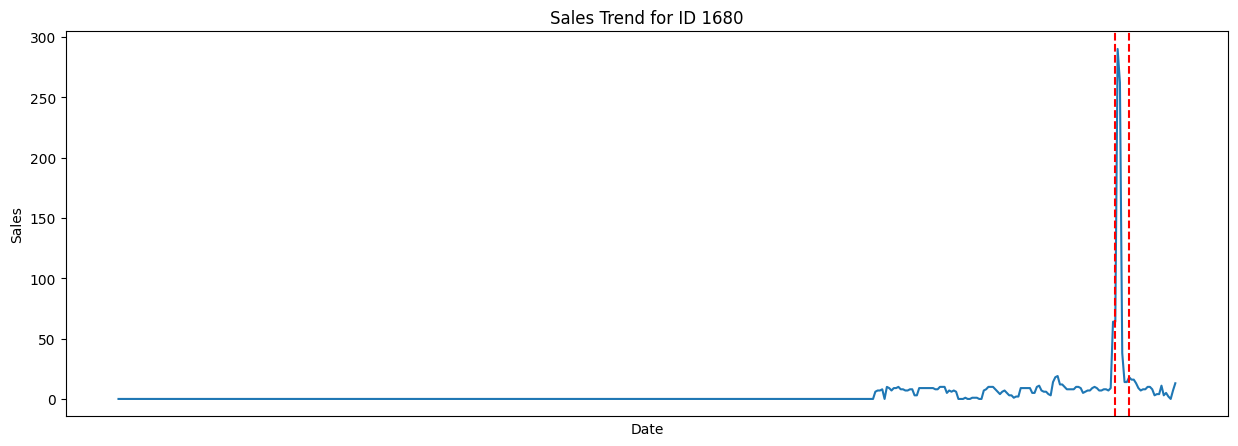

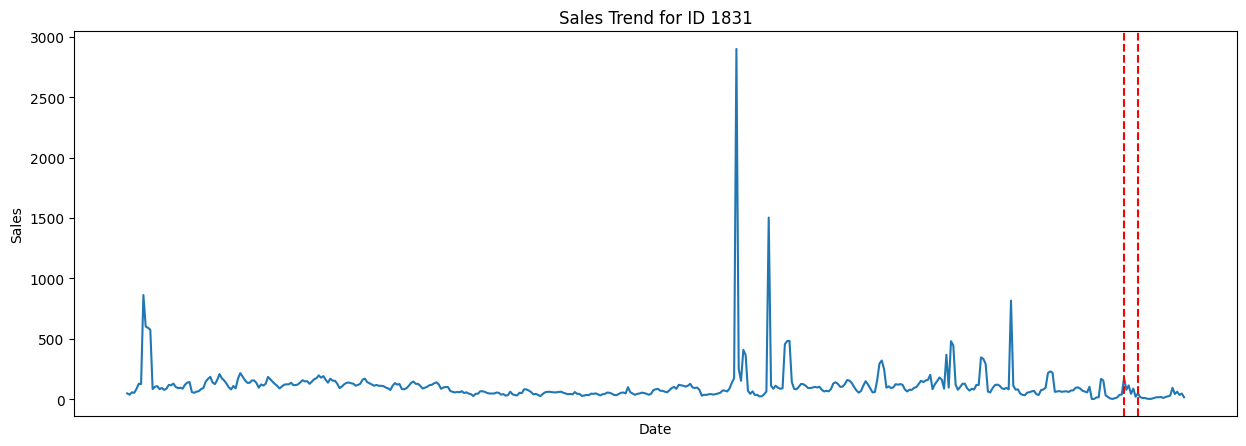

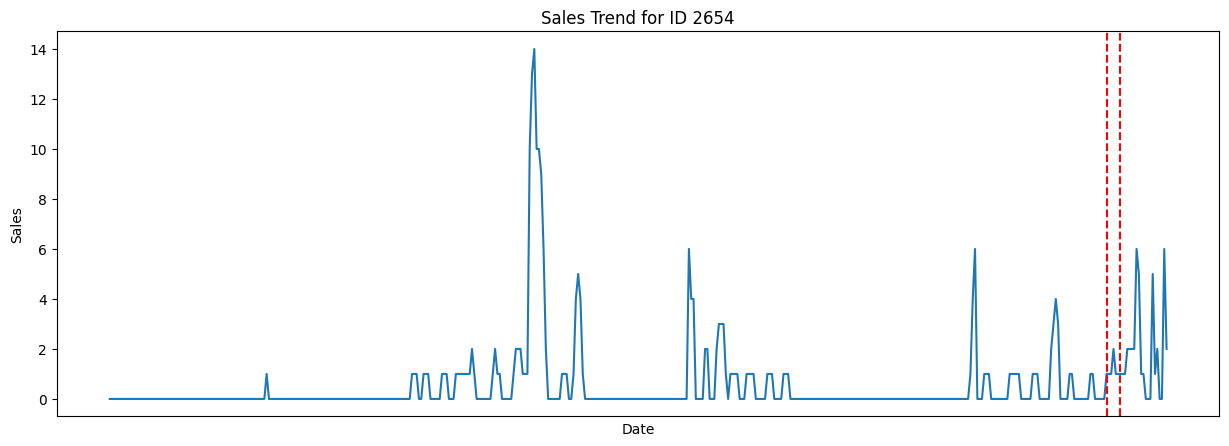

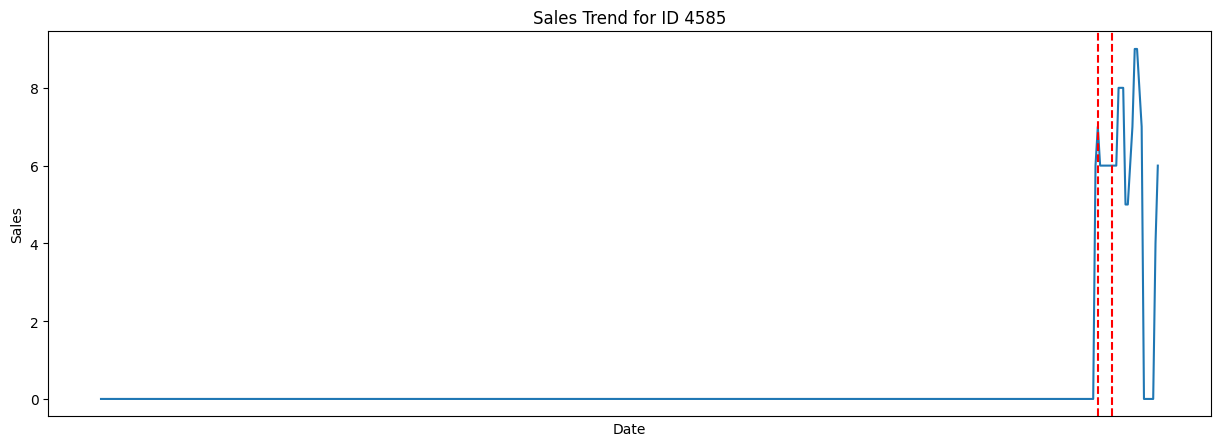

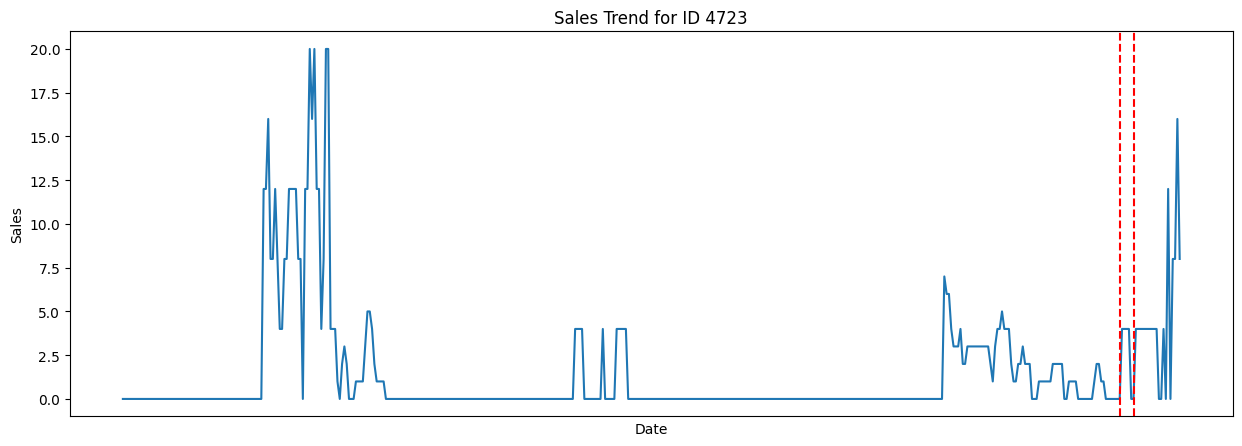

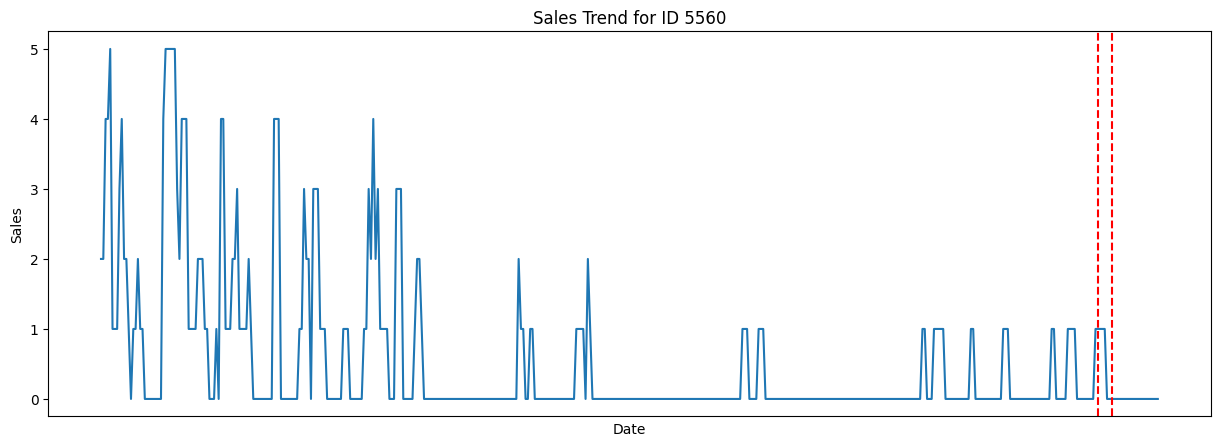

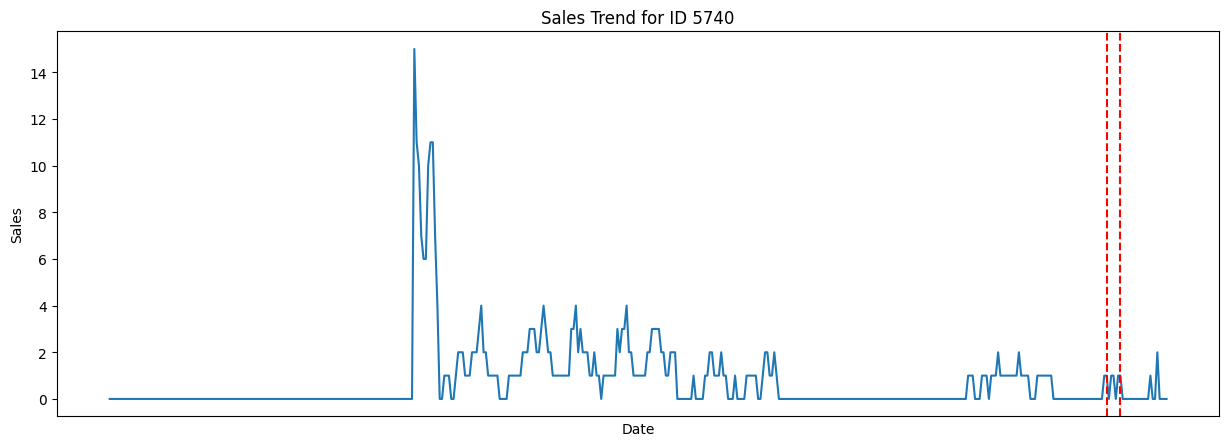

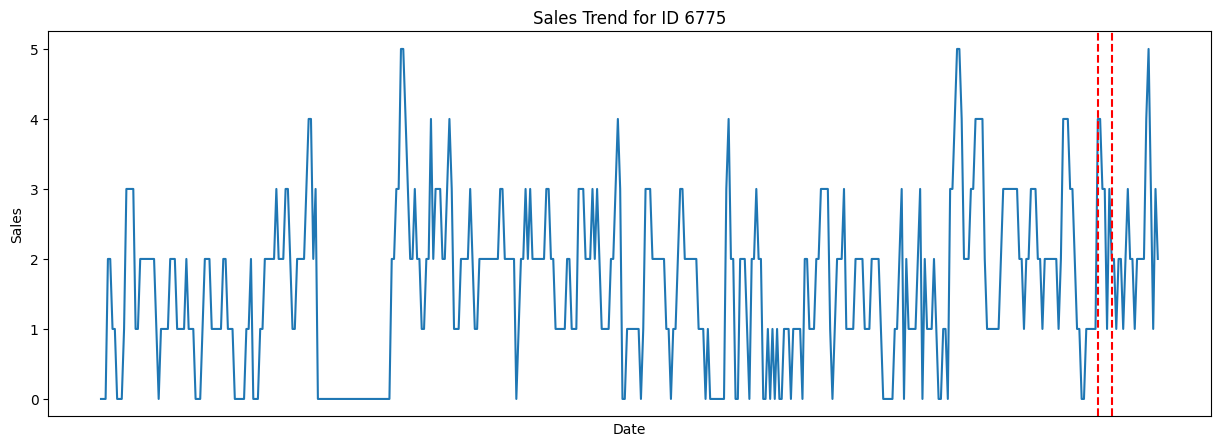

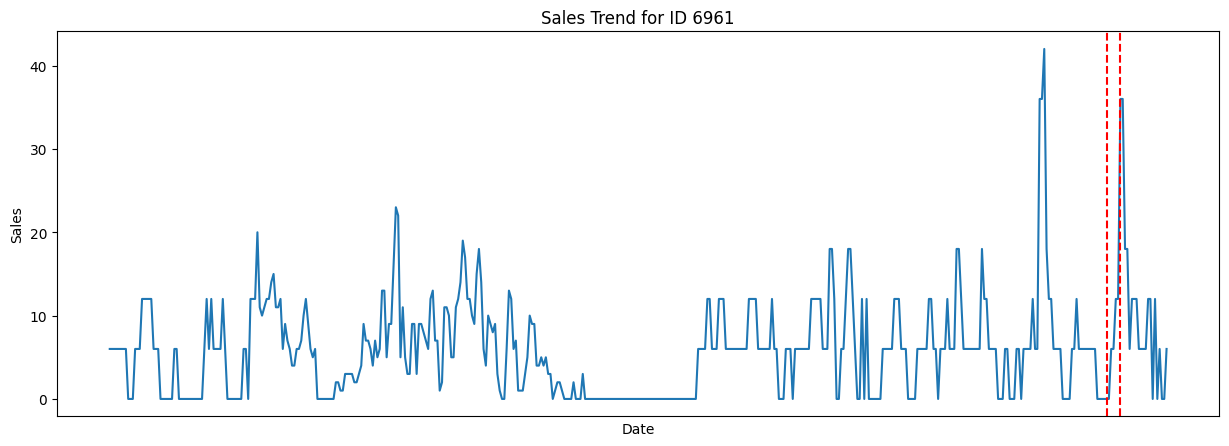

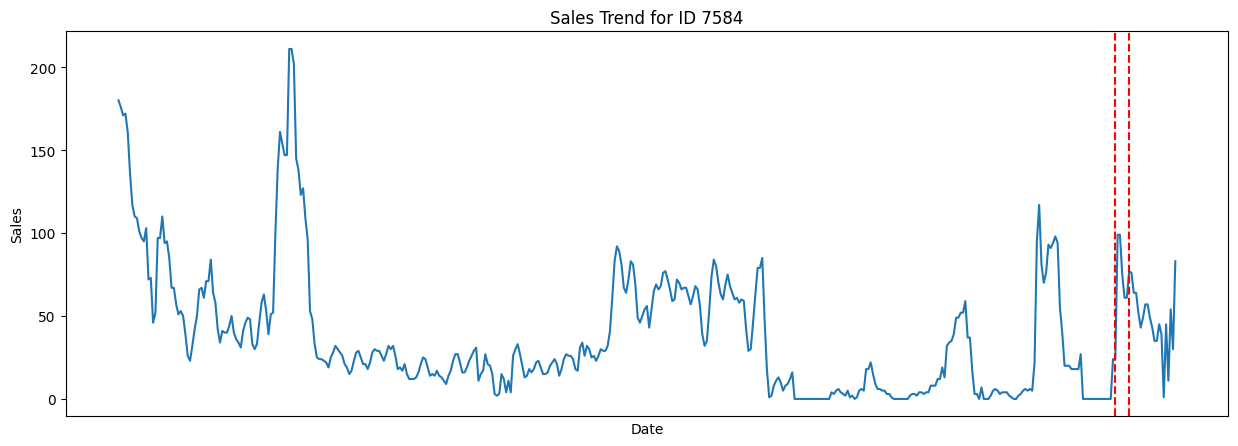

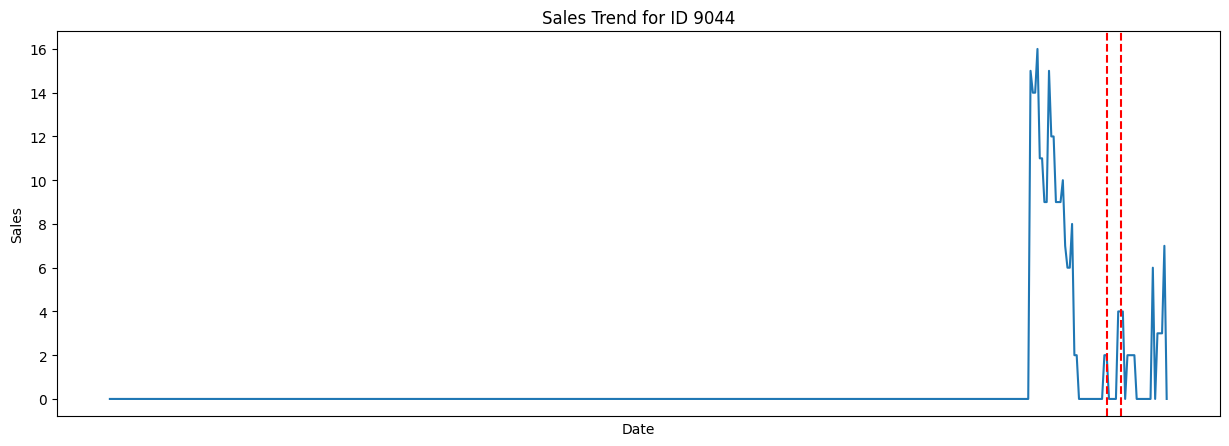

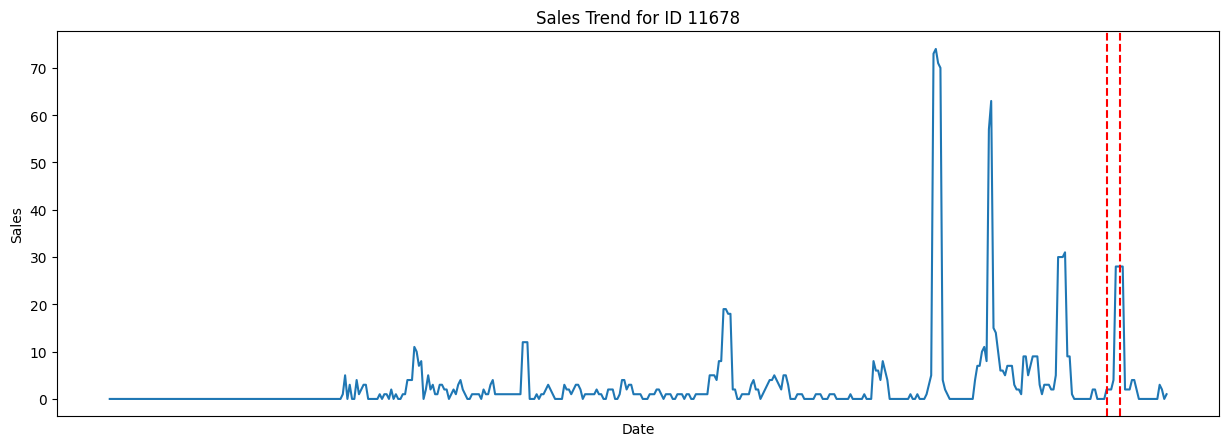

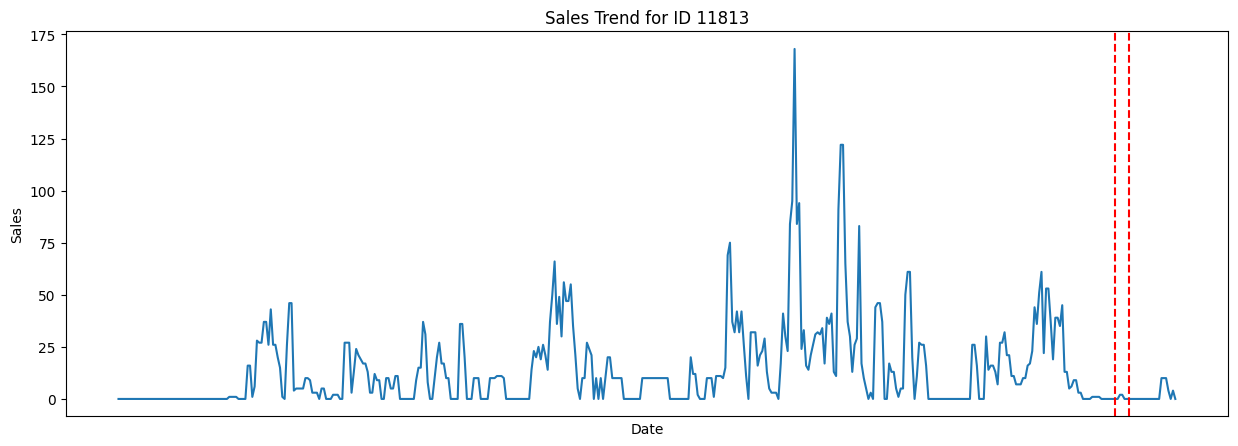

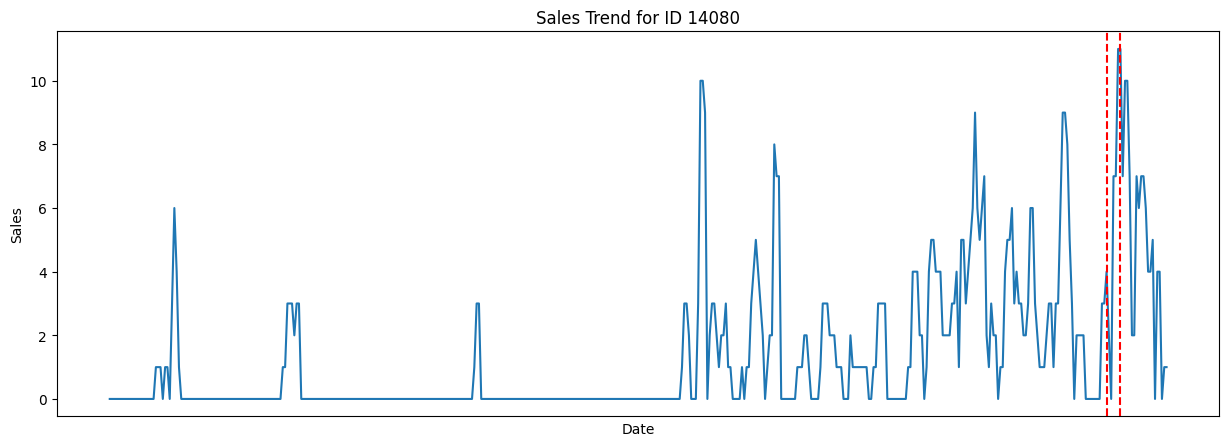

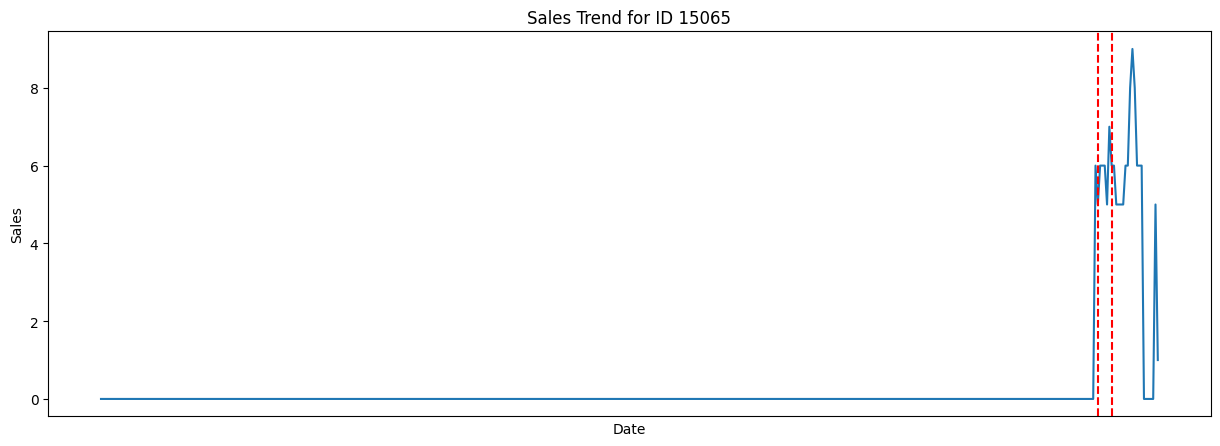

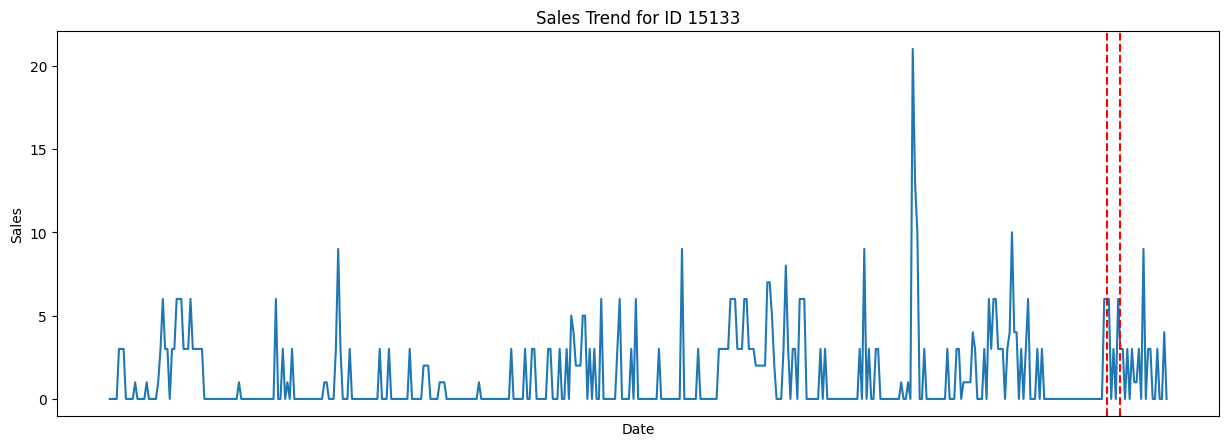

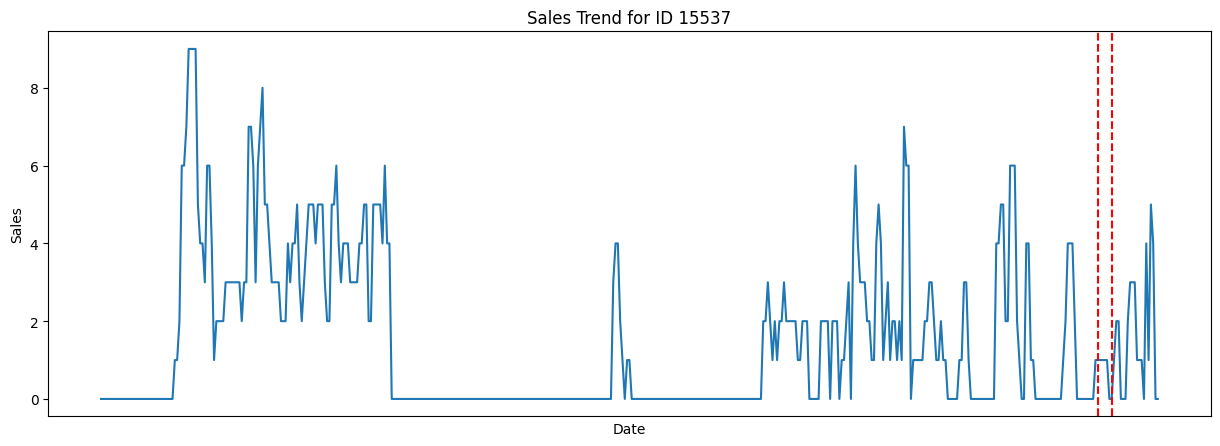

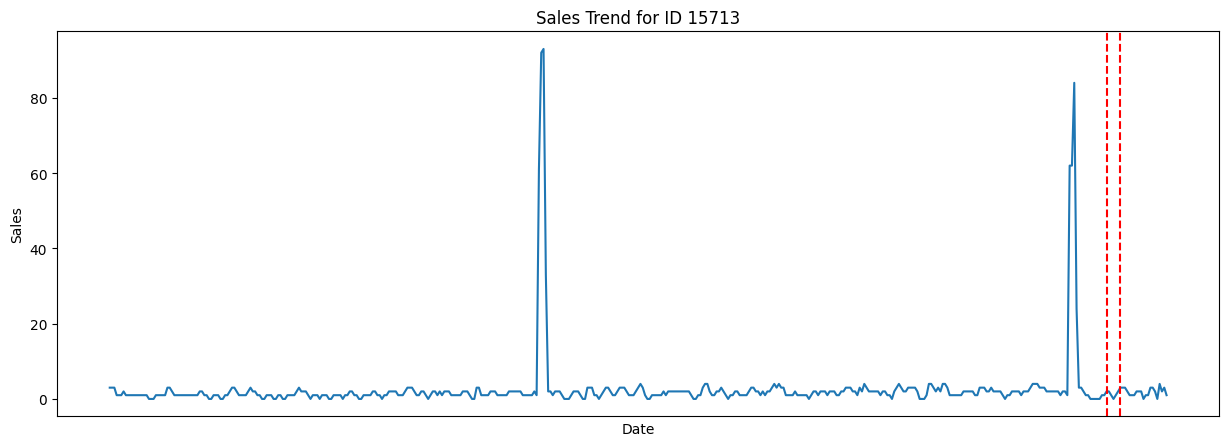

In [ ]:
# Correct the date range format with leading zeros
target_week_dates = [f"2023-03-{day:02d}" for day in range(9, 16)]
previous_week_dates = [f"2023-03-{day:02d}" for day in range(2, 9)]

# Calculate the total sales for the target week and the previous week
train['target_week_sales'] = train[target_week_dates].sum(axis=1)
train['previous_week_sales'] = train[previous_week_dates].sum(axis=1)

# Calculate the growth rate (if previous week sales is 0, set growth rate to 0)
train['growth_rate'] = train['target_week_sales'] / train['previous_week_sales']
train['growth_rate'].fillna(0, inplace=True)
train['growth_rate'] = train['growth_rate'].replace(float('inf'), 0)

# Filter the IDs with a growth rate of 400% or more
explosive_growth_ids = train[train['growth_rate'] >= 4]['ID']
import matplotlib.pyplot as plt

# Filter the data for the IDs with explosive growth
explosive_growth_data = train[train['ID'].isin(explosive_growth_ids)]

# Define the index range for the target week
start_index = train.columns.get_loc("2023-03-09")
end_index = train.columns.get_loc("2023-03-15")

# Plot the sales trend for each ID
for index, row in explosive_growth_data.iterrows():
    plt.figure(figsize=[15, 5])
    plt.plot(row[6:-3])
    plt.axvline(x=start_index-6, color='r', linestyle='--')  # Start of target week
    plt.axvline(x=end_index-6, color='r', linestyle='--')    # End of target week
    plt.title(f"Sales Trend for ID {row['ID']}")
    plt.xlabel("Date")
    plt.ylabel("Sales")
    plt.xticks([])  # Remove x-axis labels
    plt.show()


In [ ]:
# Correct the date range format with leading zeros
target_week_dates = [f"2022-03-{day:02d}" for day in range(17, 24)]
previous_week_dates = [f"2022-03-{day:02d}" for day in range(10, 17)]

# Calculate the total sales for the target week and the previous week
train['target_week_sales'] = train[target_week_dates].sum(axis=1)
train['previous_week_sales'] = train[previous_week_dates].sum(axis=1)

# Calculate the growth rate (if previous week sales is 0, set growth rate to 0)
train['growth_rate'] = train['target_week_sales'] / train['previous_week_sales']
train['growth_rate'].fillna(0, inplace=True)
train['growth_rate'] = train['growth_rate'].replace(float('inf'), 0)

# Filter the IDs with a growth rate of 400% or more
explosive_growth_ids = train[train['growth_rate'] >= 4]['ID']
import matplotlib.pyplot as plt

# Filter the data for the IDs with explosive growth
explosive_growth_data = train[train['ID'].isin(explosive_growth_ids)]

# Define the index range for the target week
start_index = train.columns.get_loc("2022-03-17")
end_index = train.columns.get_loc("2022-03-23")

# Plot the sales trend for each ID
for index, row in explosive_growth_data.iterrows():
    plt.figure(figsize=[15, 5])
    plt.plot(row[6:-3])
    plt.axvline(x=start_index-6, color='r', linestyle='--')  # Start of target week
    plt.axvline(x=end_index-6, color='r', linestyle='--')    # End of target week
    plt.title(f"Sales Trend for ID {row['ID']}")
    plt.xlabel("Date")
    plt.ylabel("Sales")
    plt.xticks([])  # Remove x-axis labels
    plt.show()


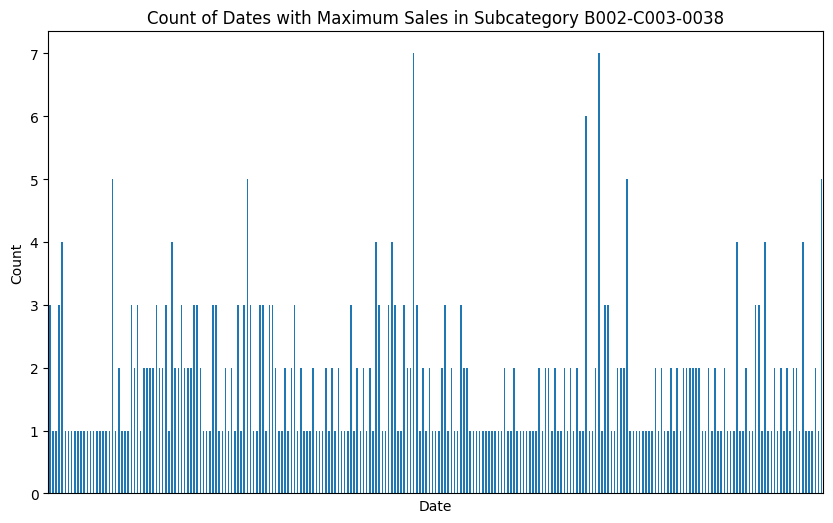

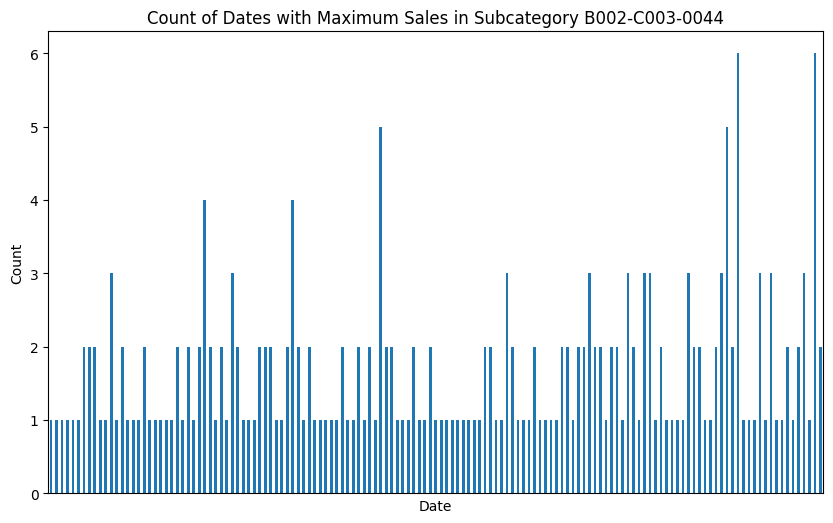

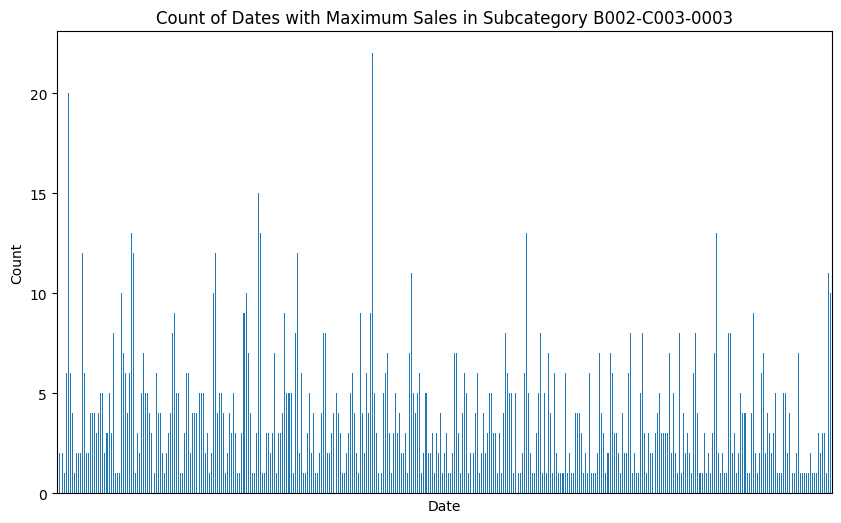

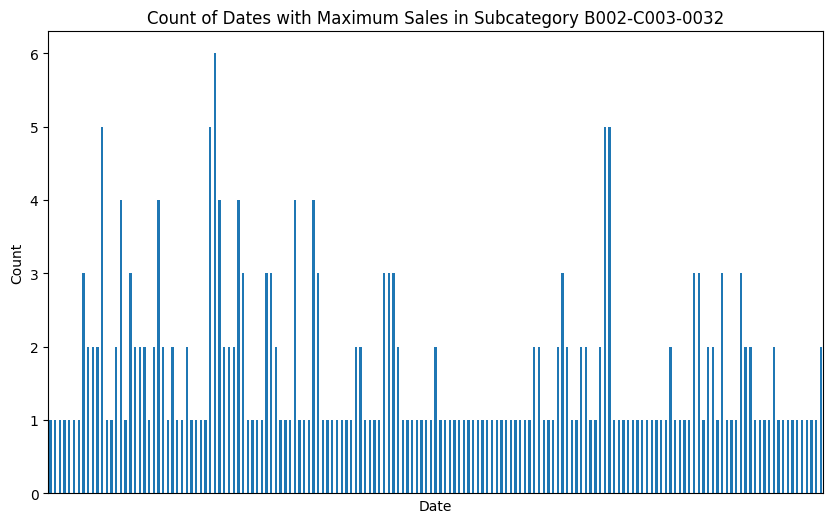

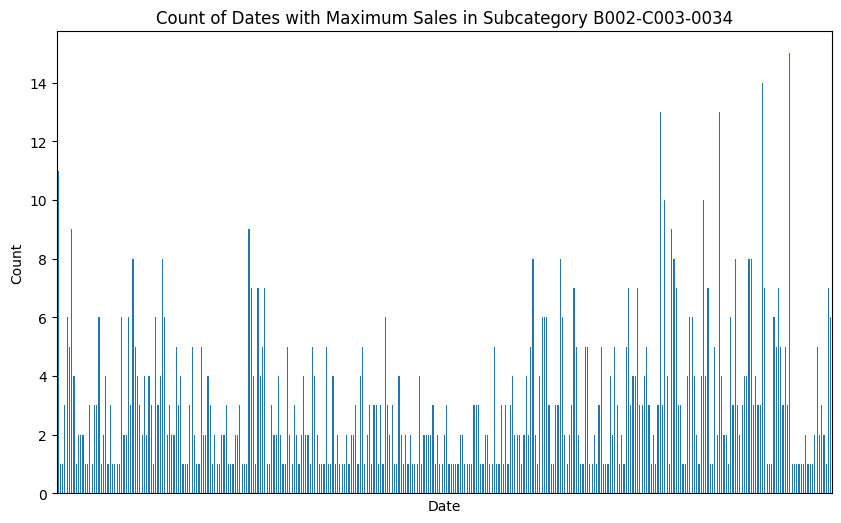

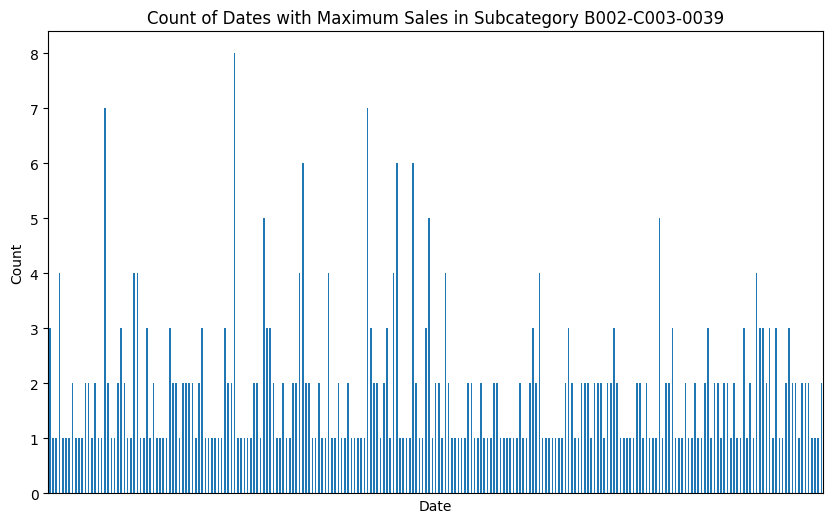

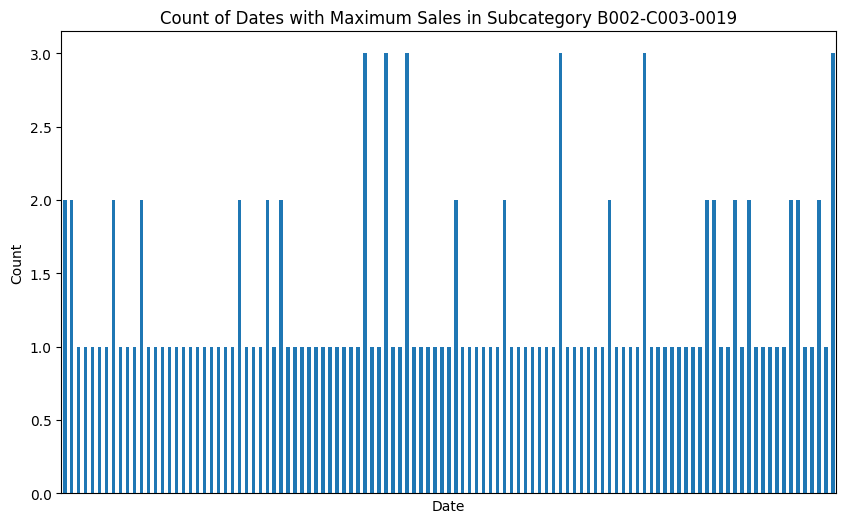

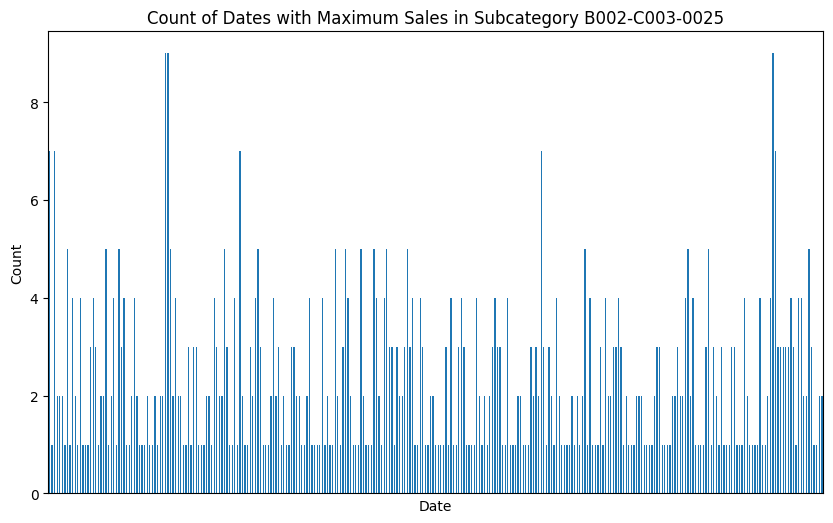

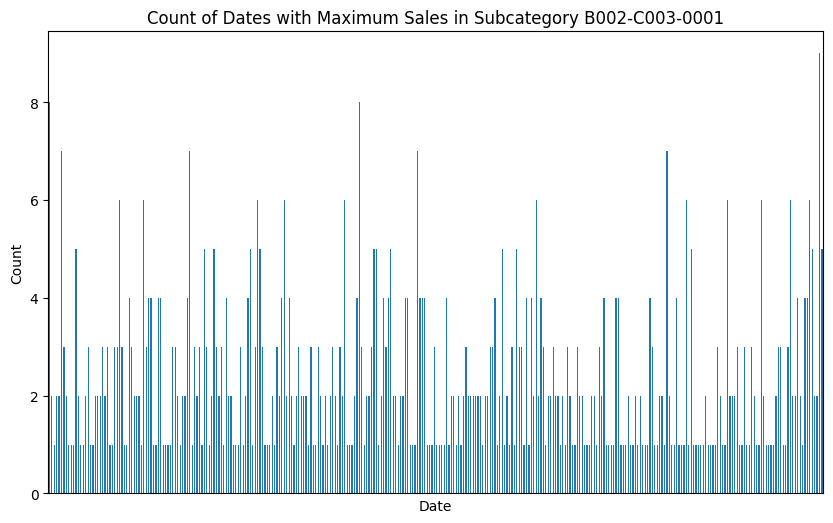

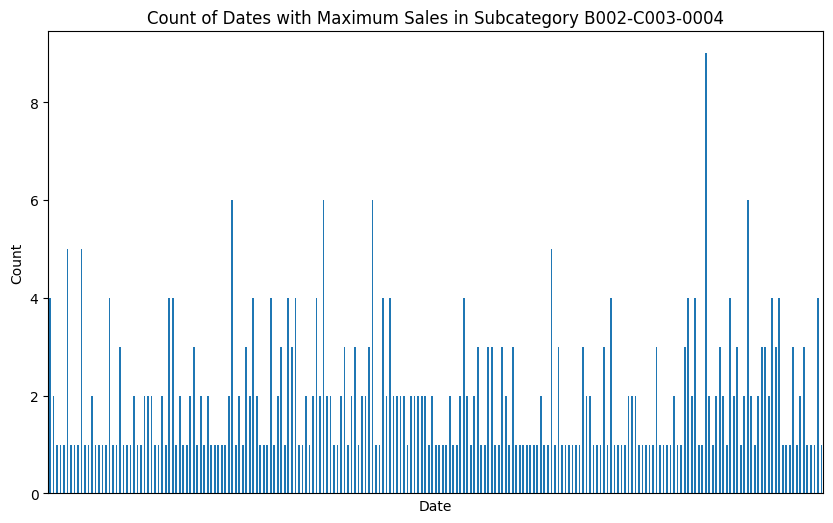

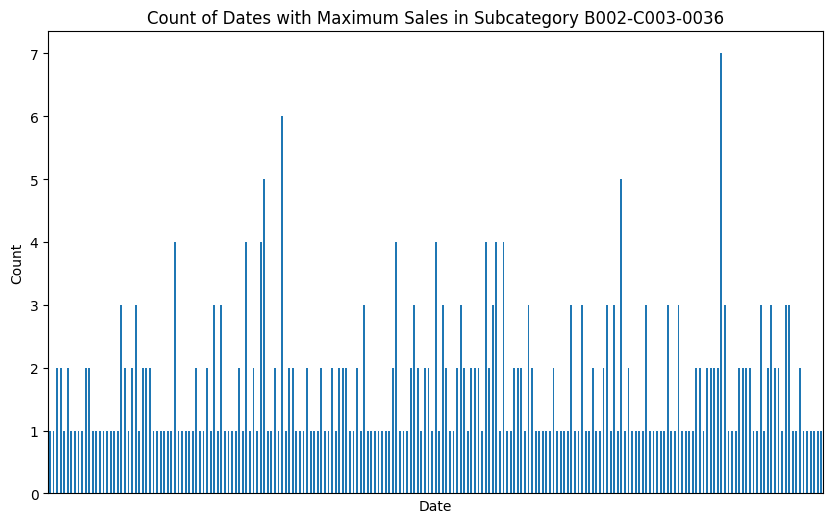

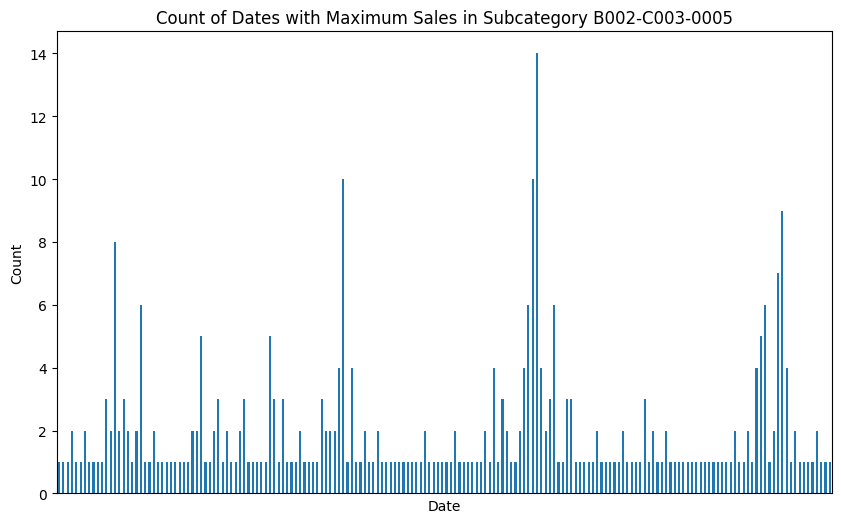

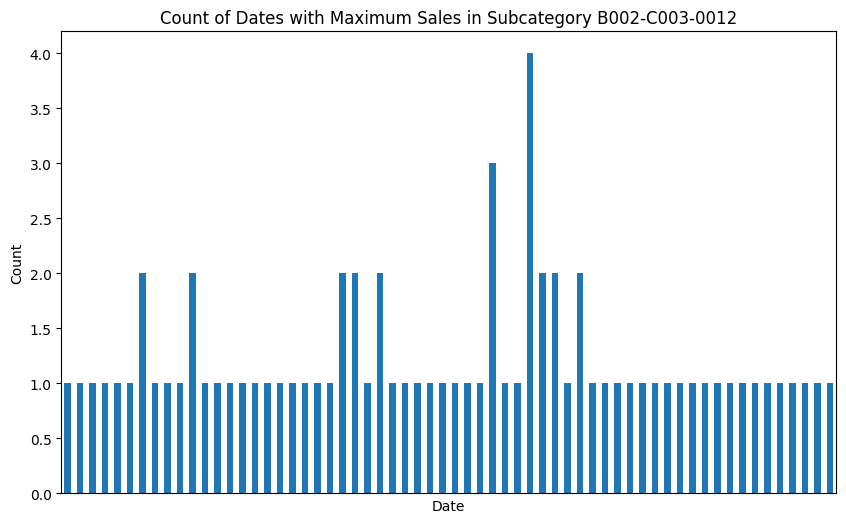

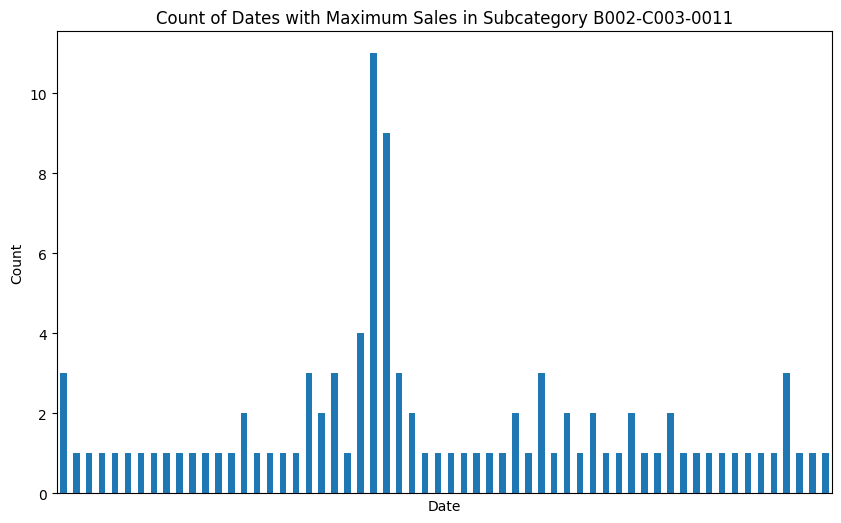

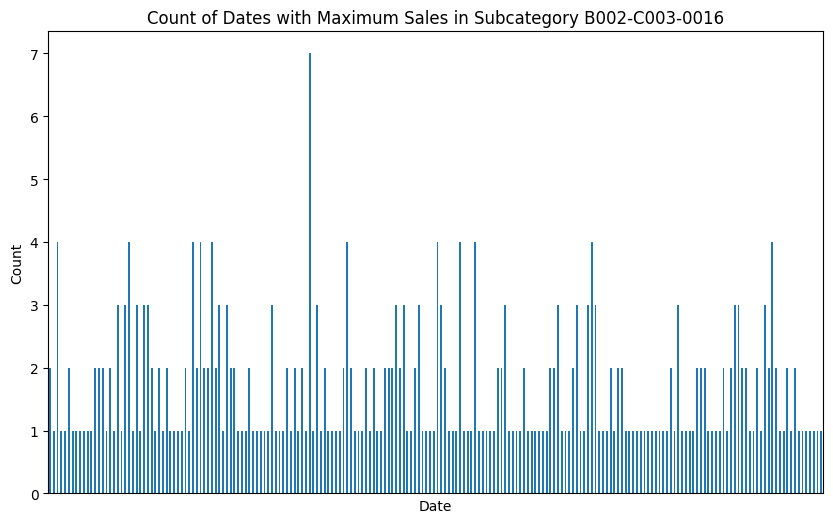

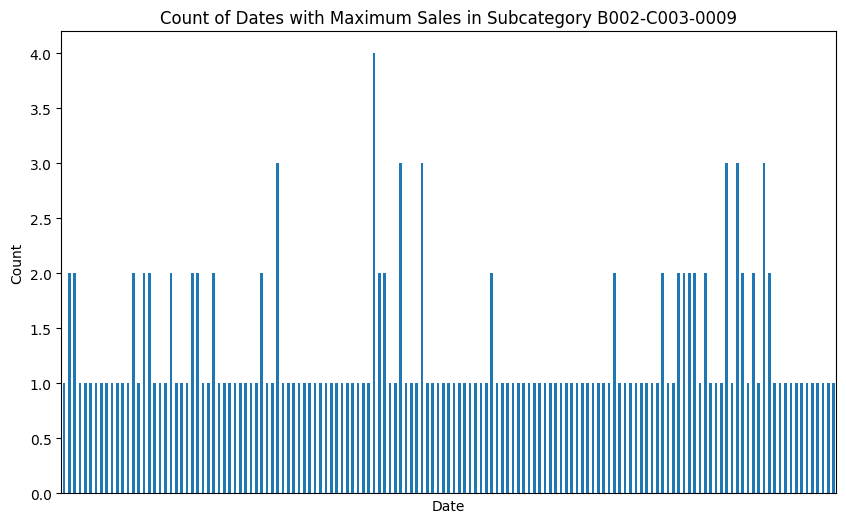

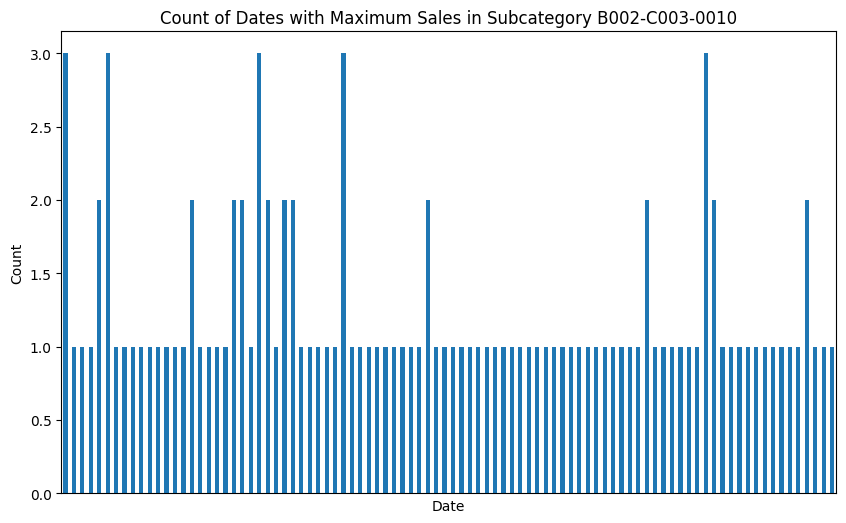

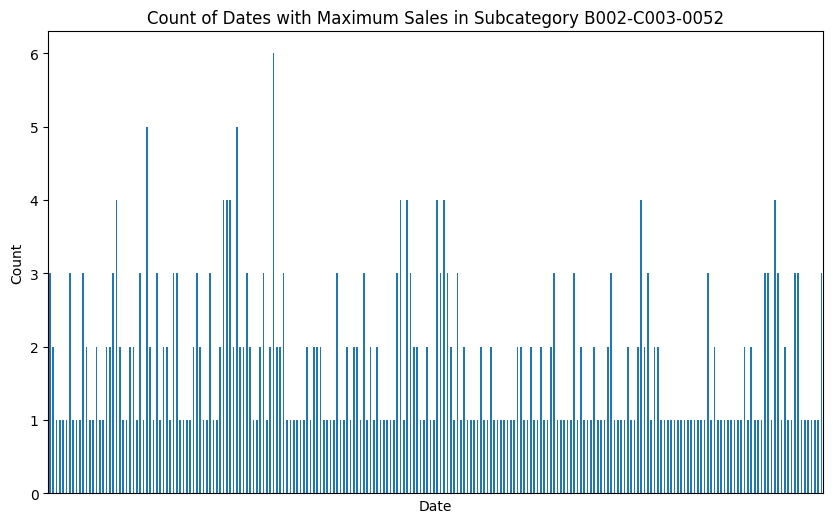

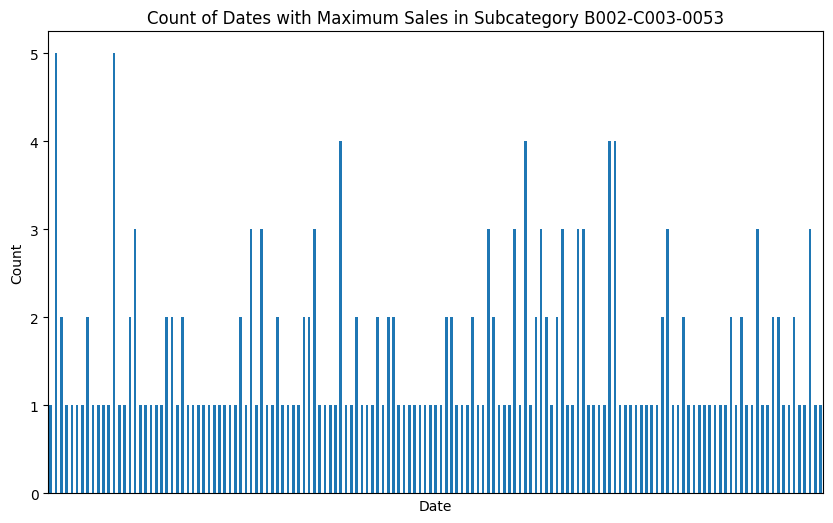

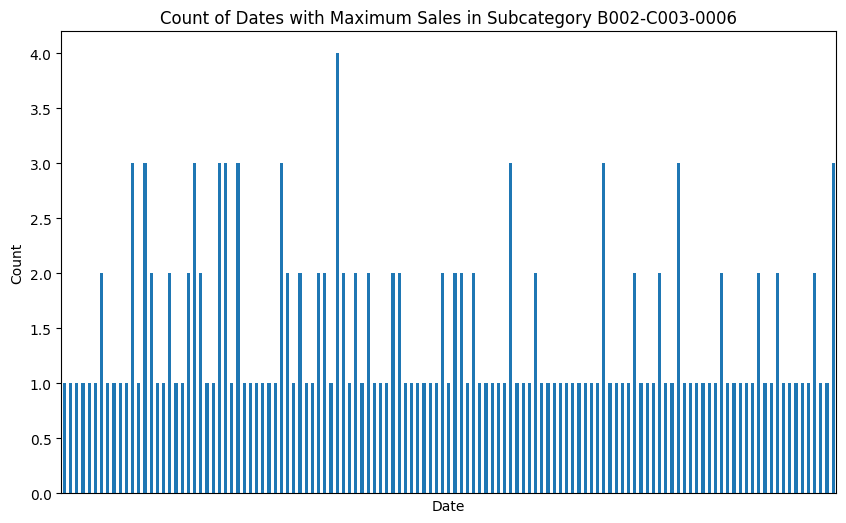

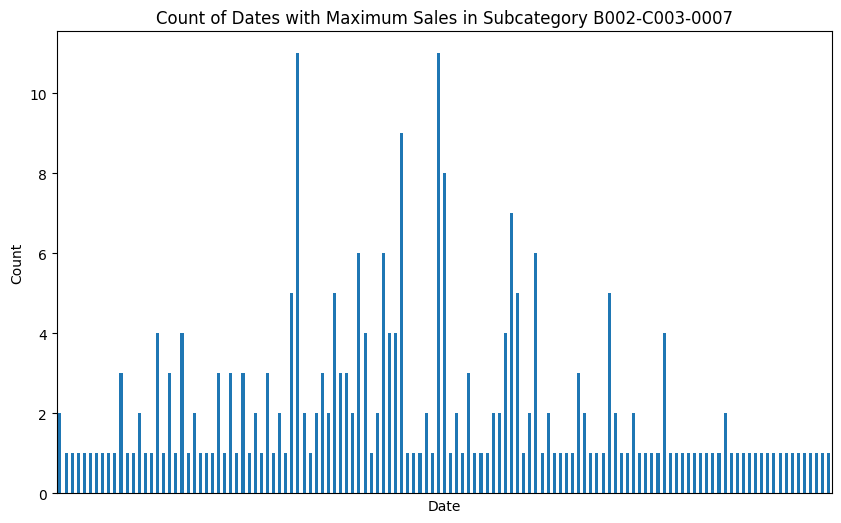

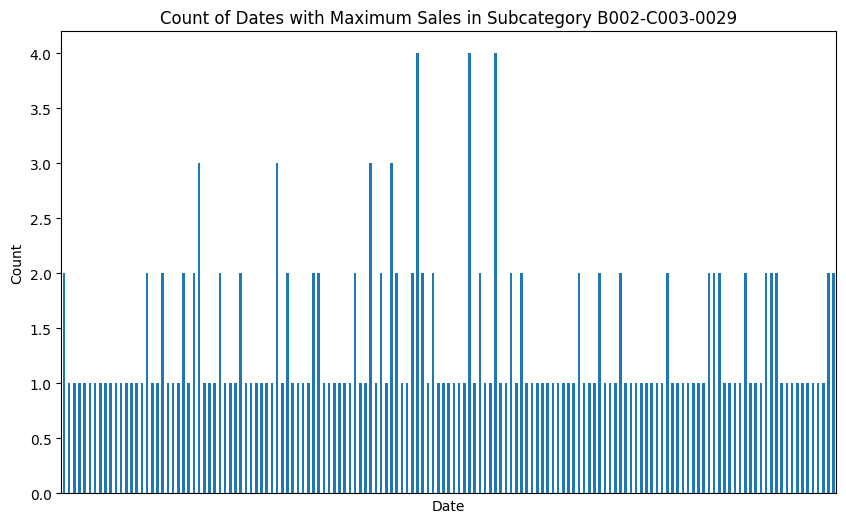

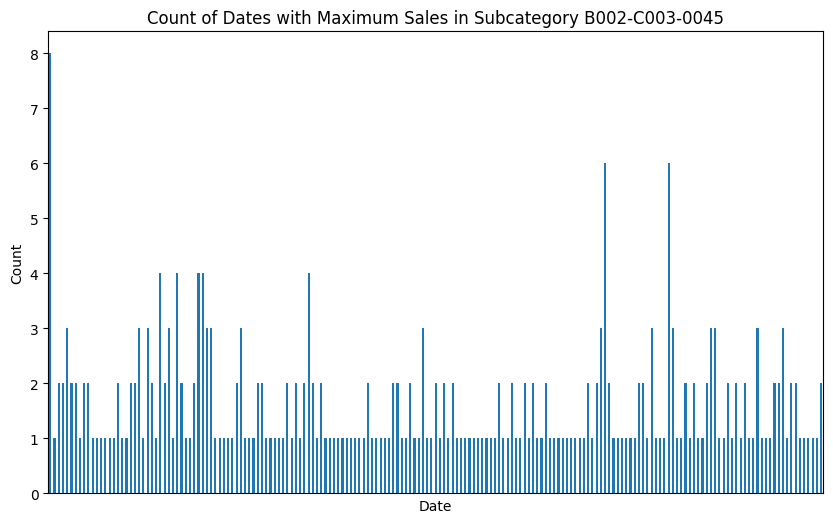

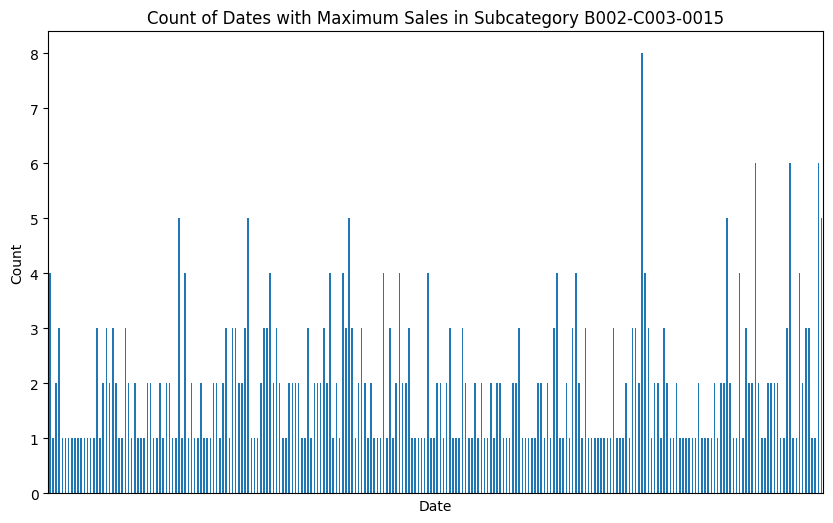

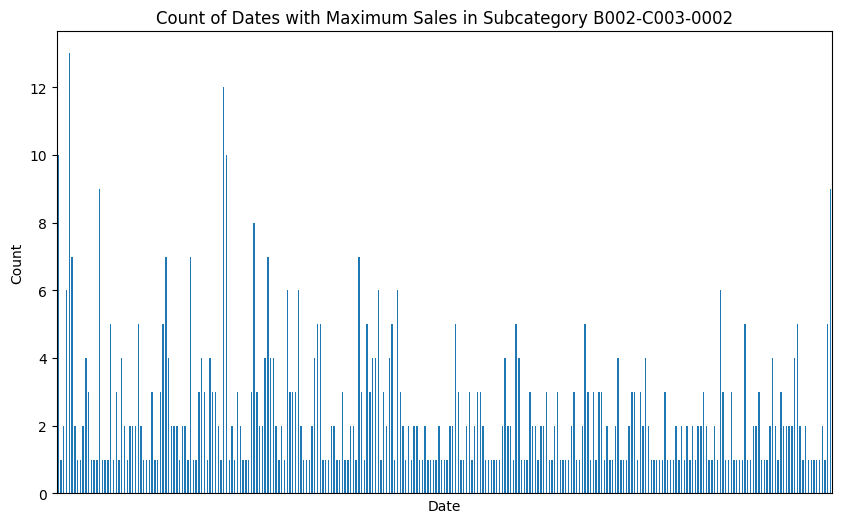

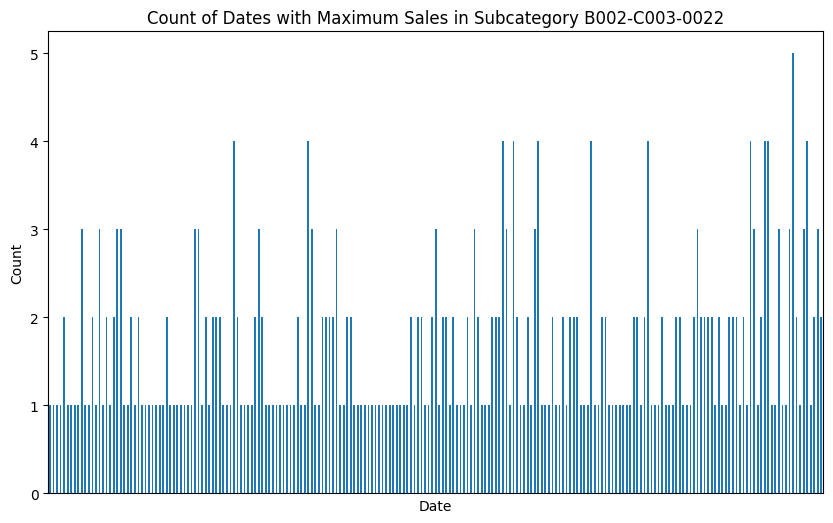

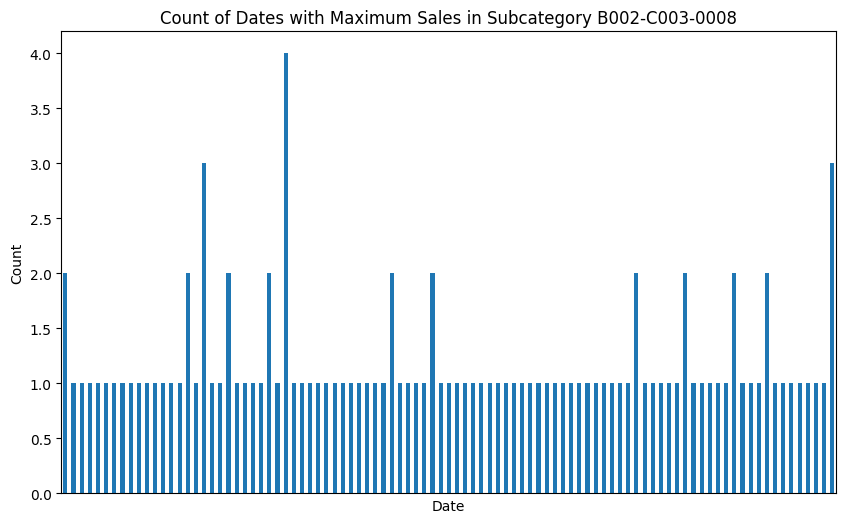

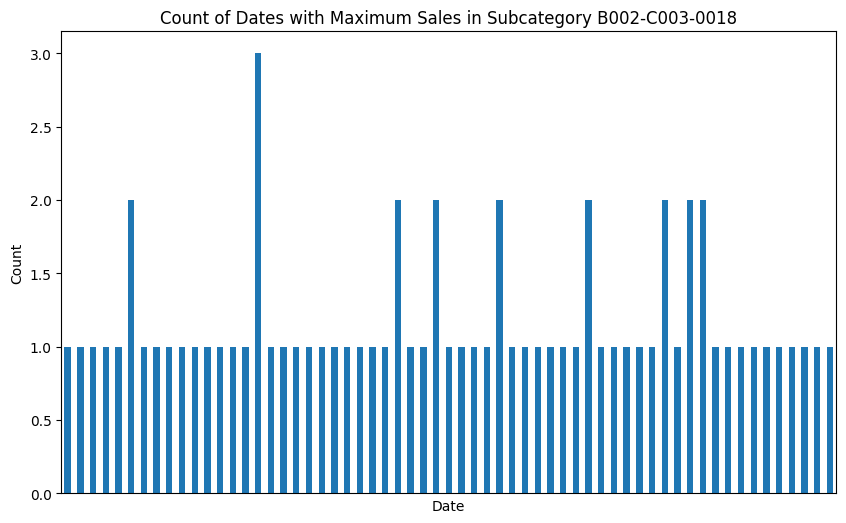

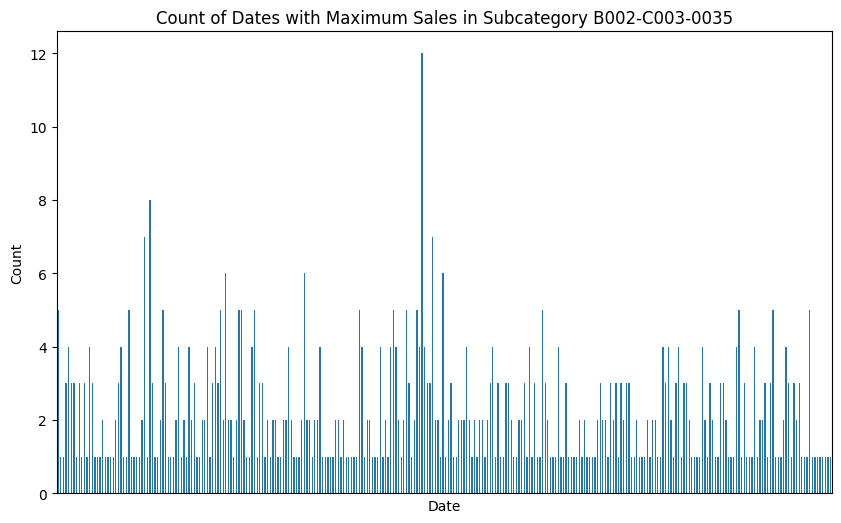

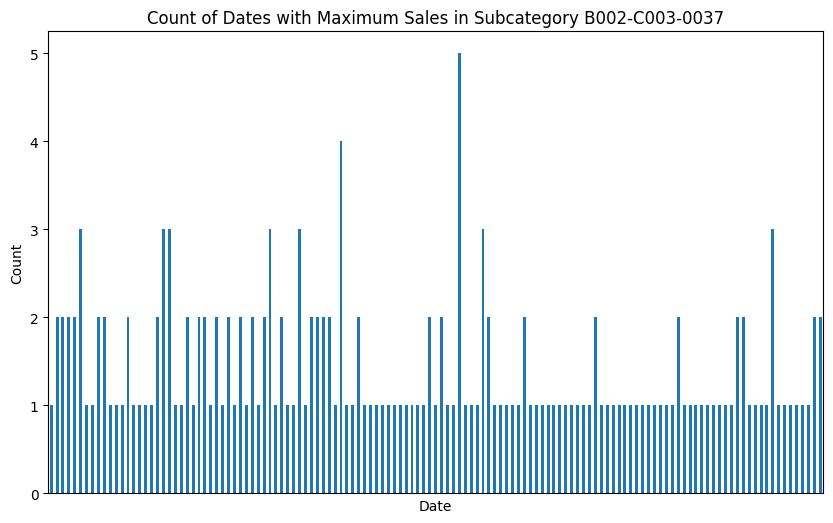

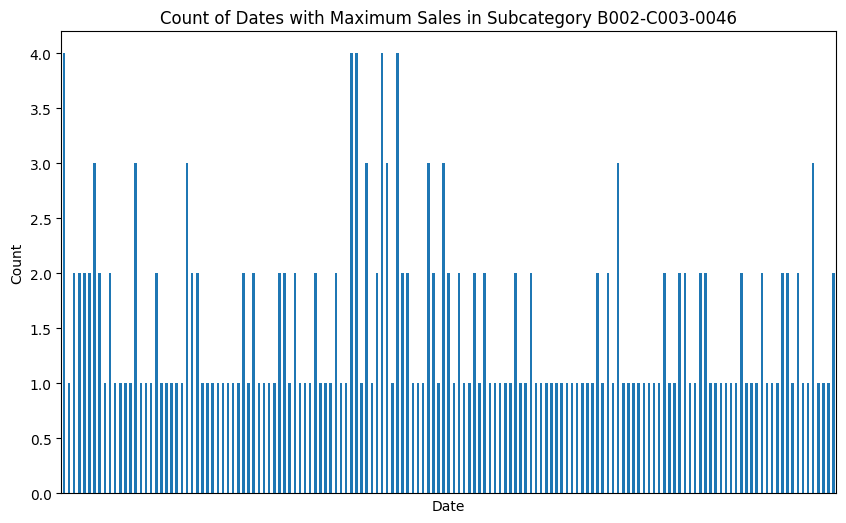

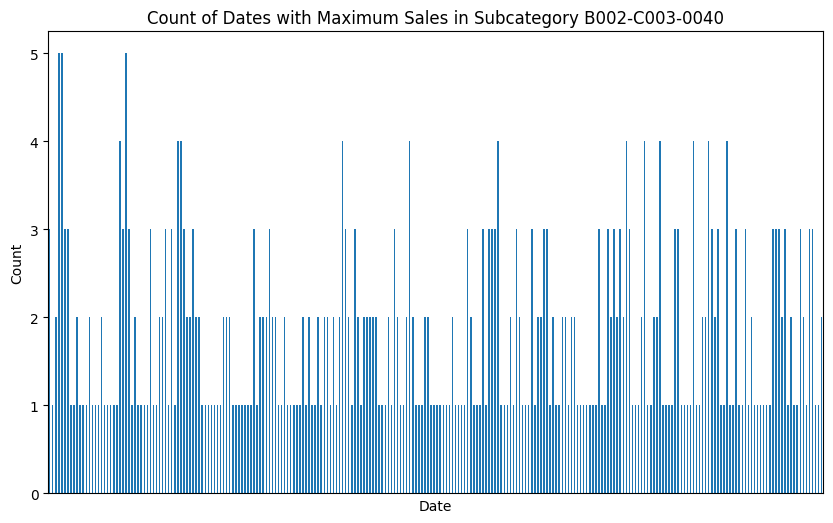

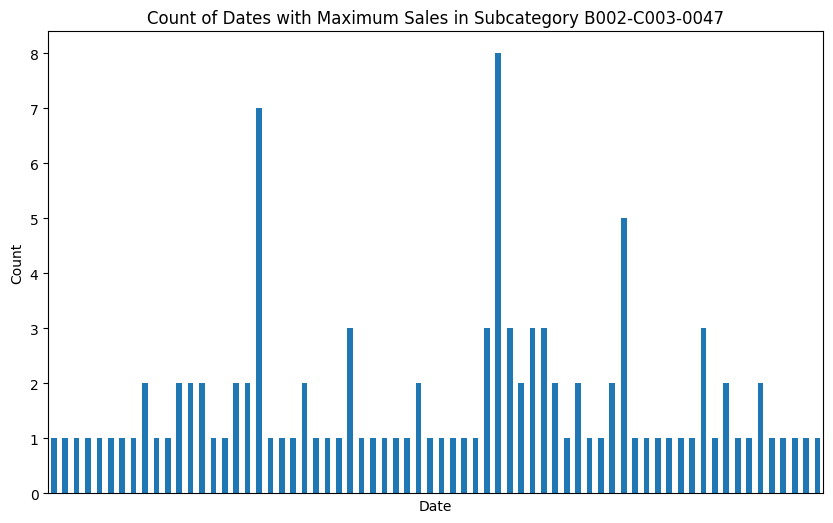

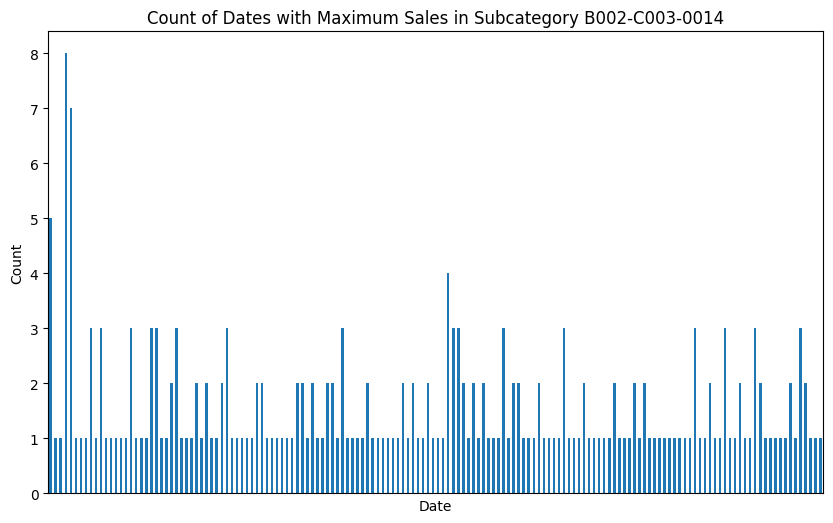

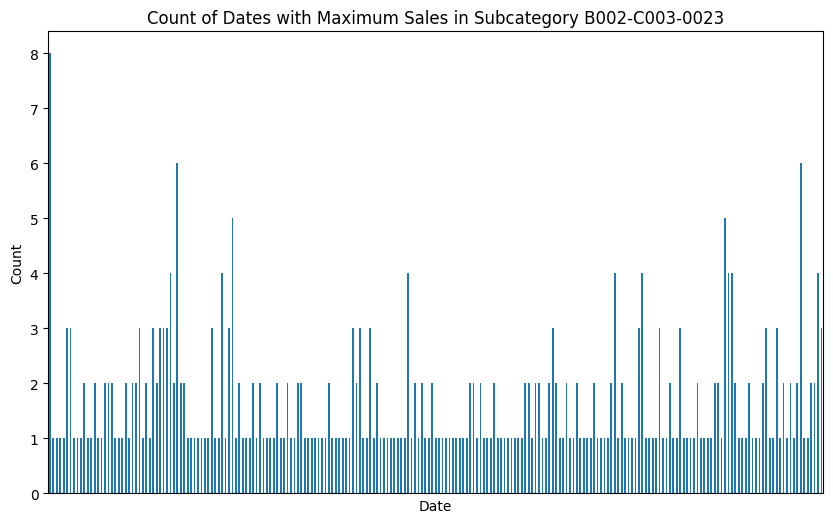

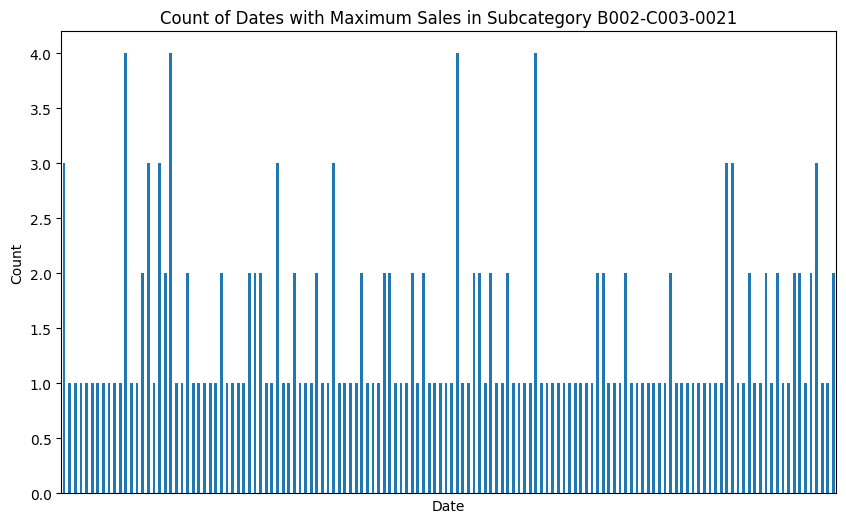

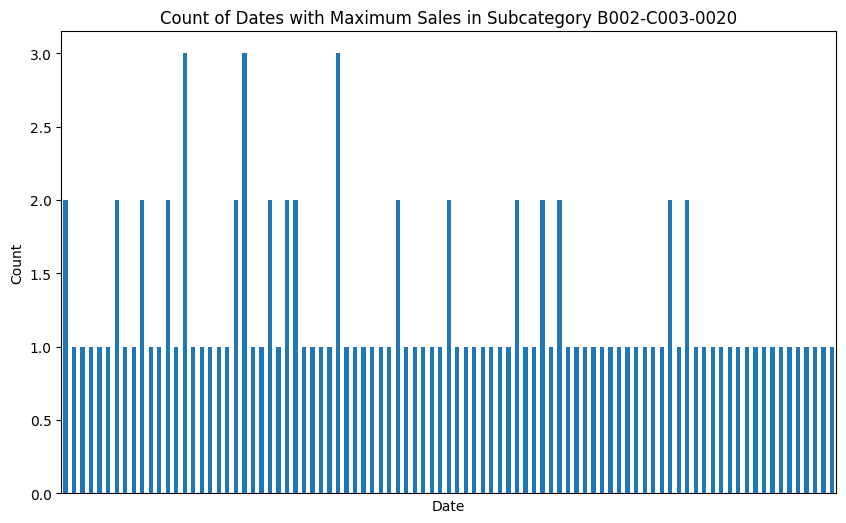

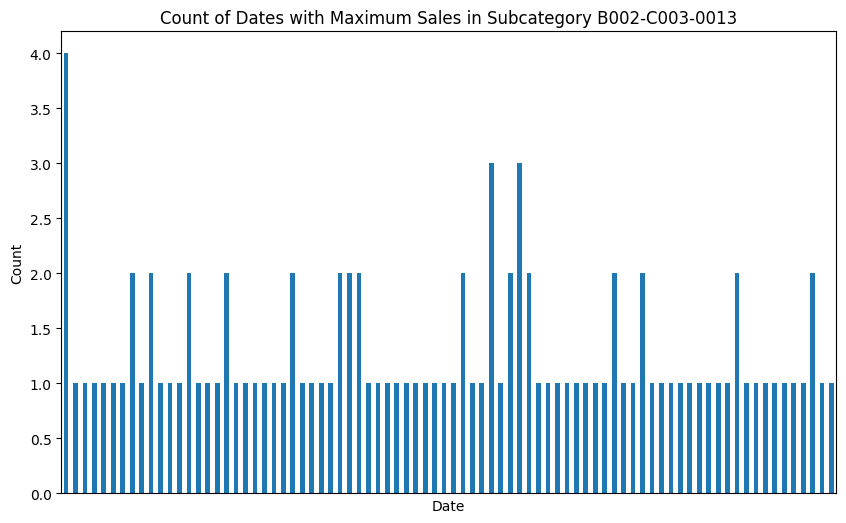

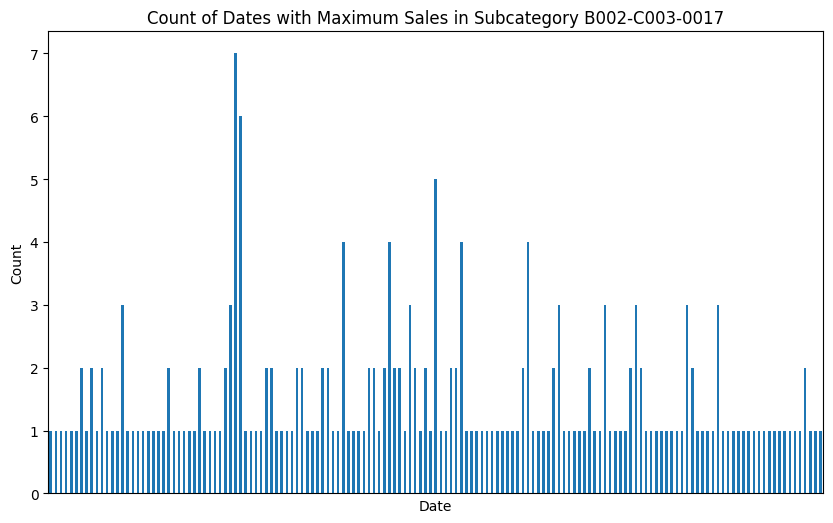

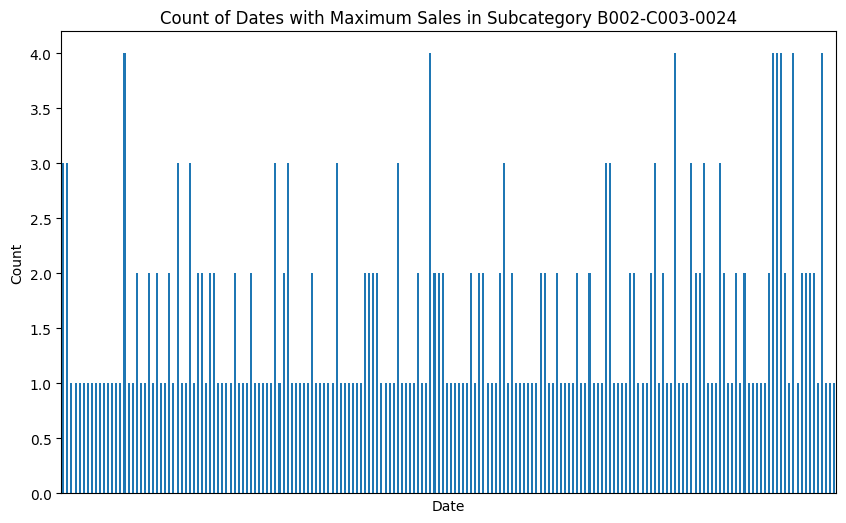

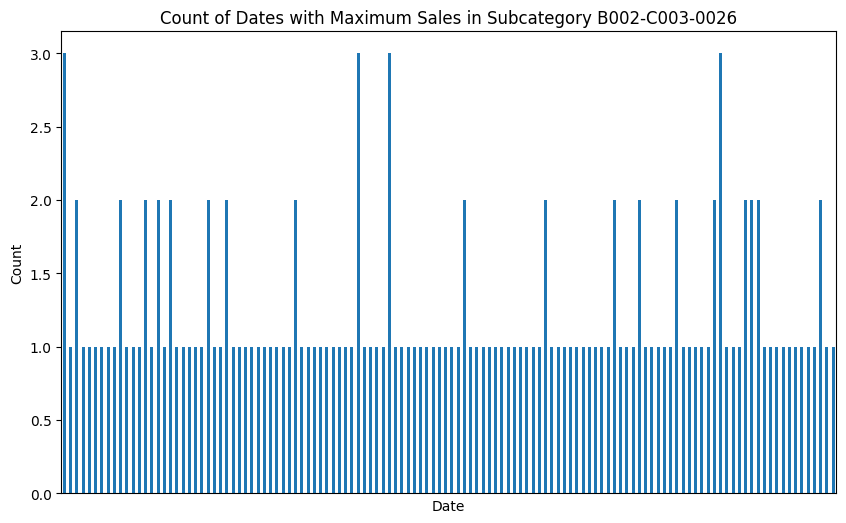

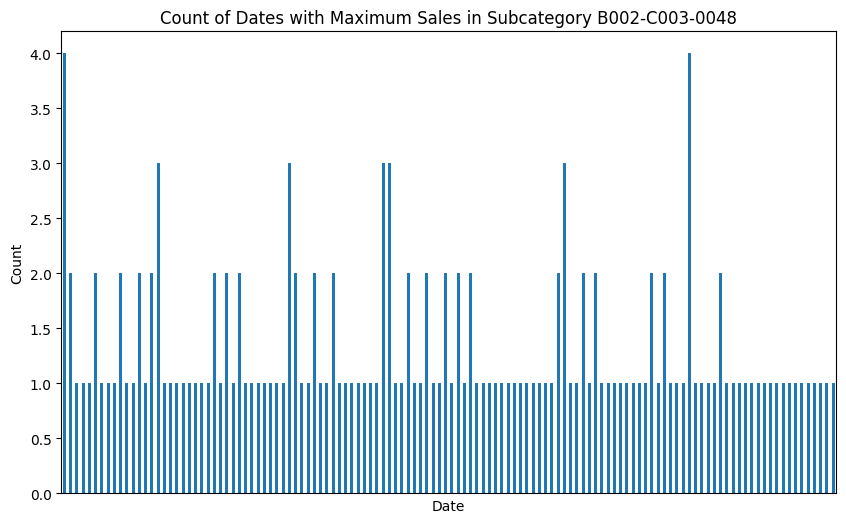

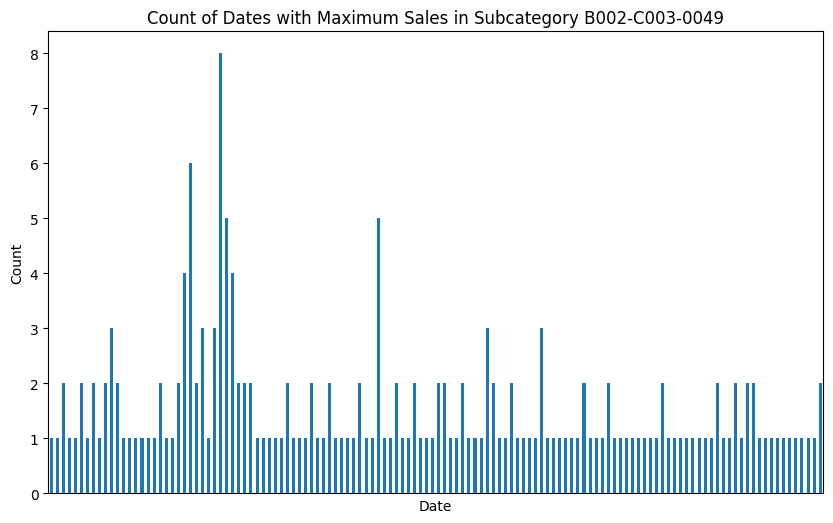

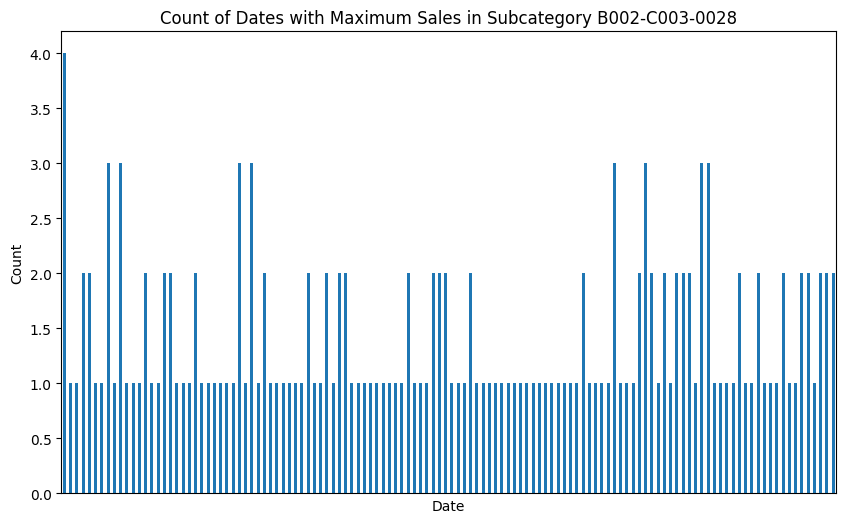

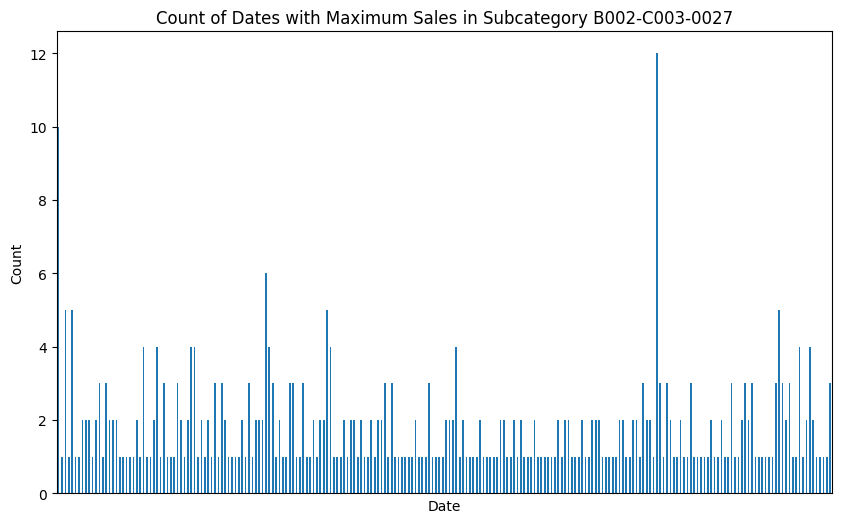

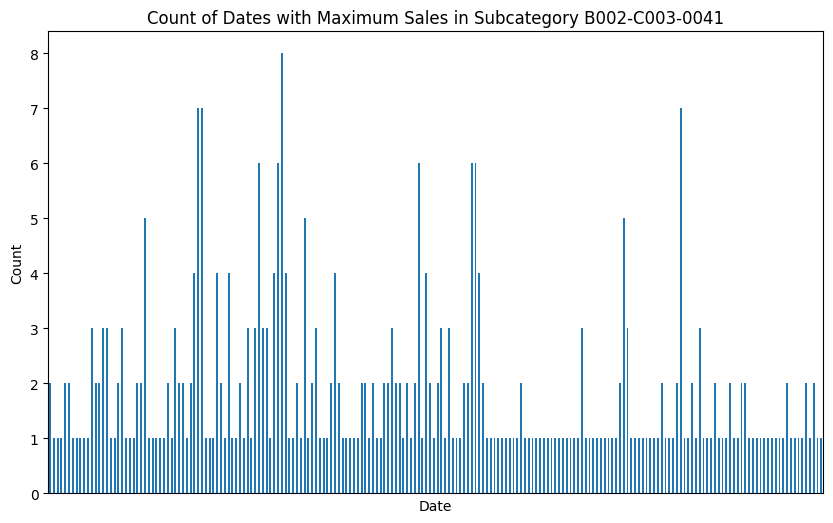

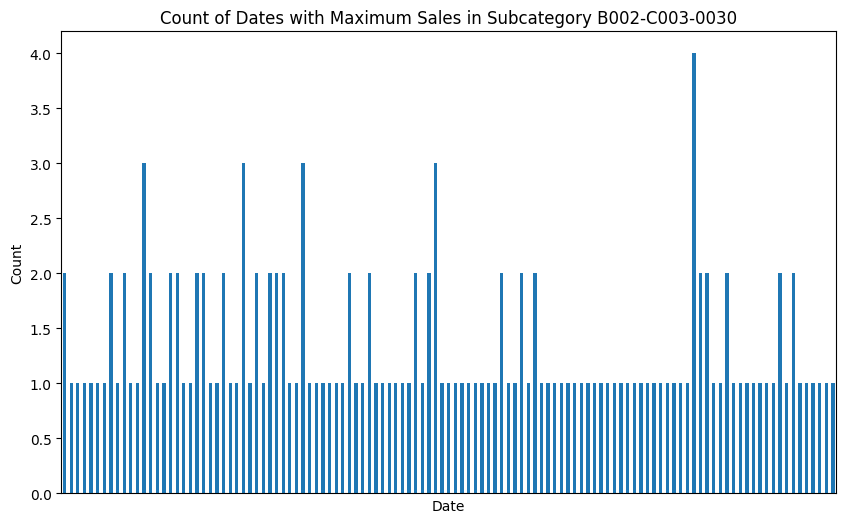

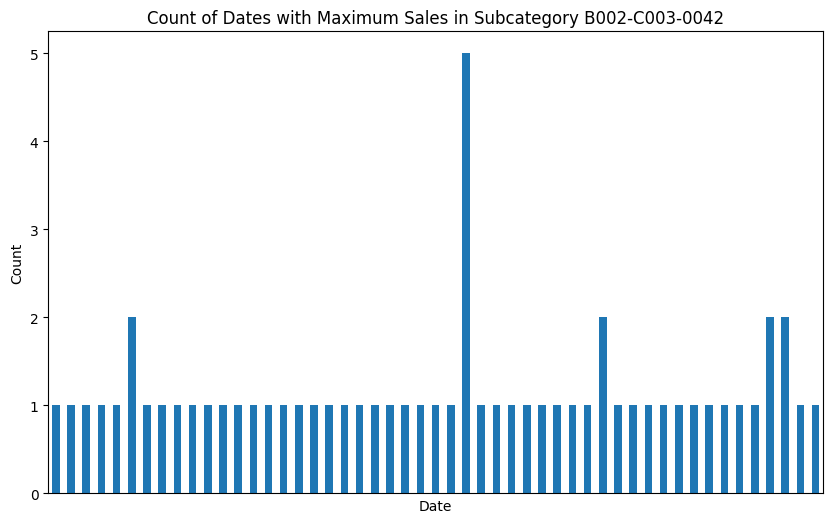

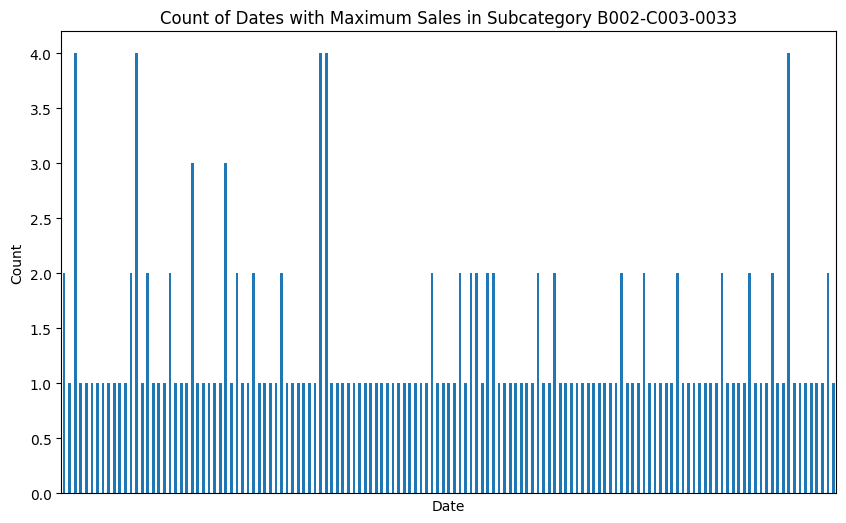

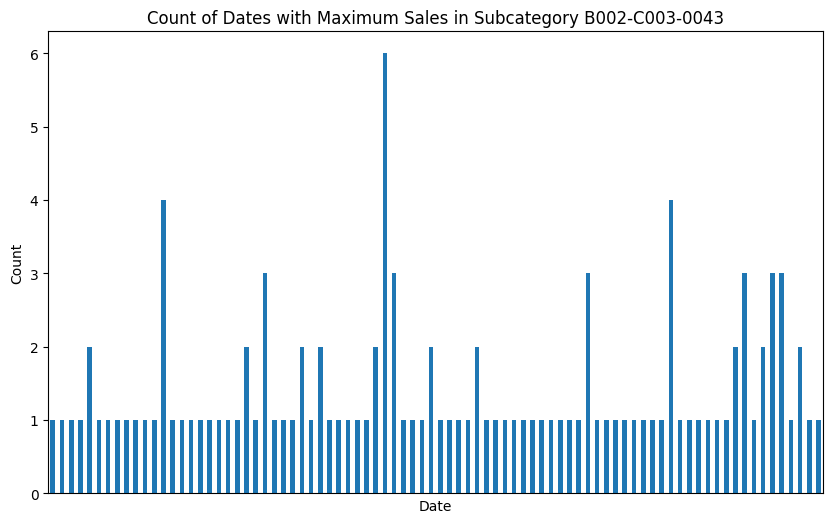

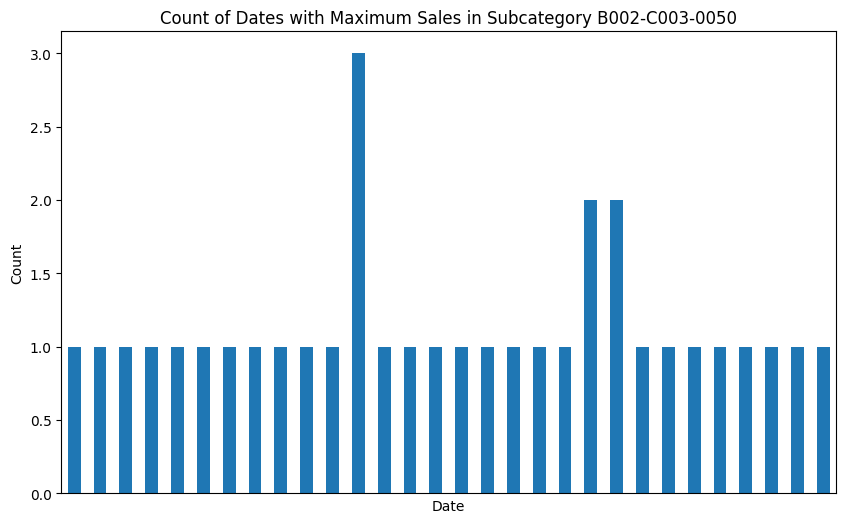

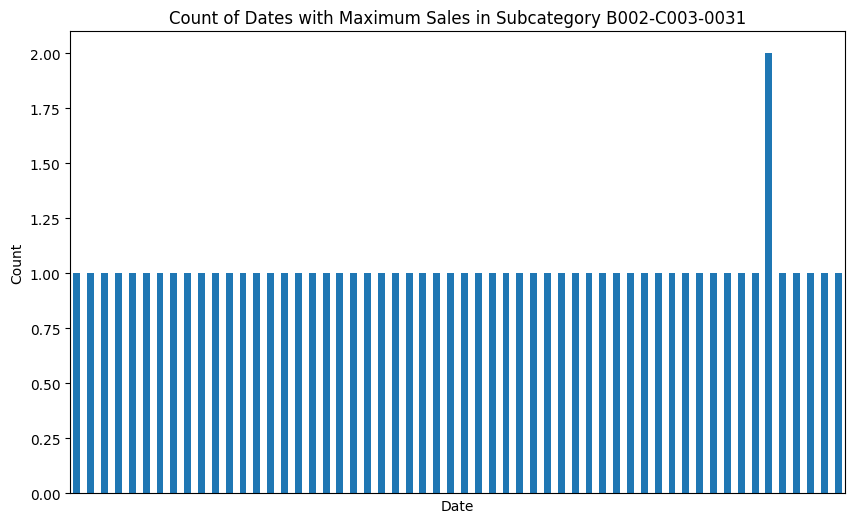

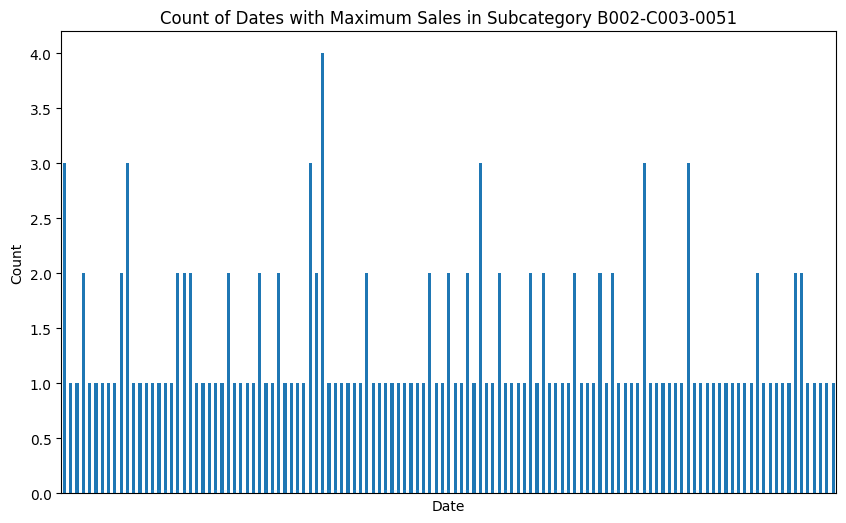

In [ ]:
# 날짜 칼럼을 datetime 형식으로 변환
date_columns_as_dates = pd.to_datetime(date_columns)
unique_subcategories = train['소분류'].unique()

# 각 소분류별로 플롯을 그립니다.
for subcategory in unique_subcategories:
    subcategory_data = train[train['소분류'] == subcategory]
    max_sales_dates_per_id = subcategory_data[date_columns].idxmax(axis=1).value_counts()

    # 날짜 순서대로 정렬
    max_sales_dates_per_id.index = pd.to_datetime(max_sales_dates_per_id.index)
    max_sales_dates_per_id = max_sales_dates_per_id.sort_index()

    plt.figure(figsize=(10, 6))
    max_sales_dates_per_id.plot(kind='bar')
    plt.xlabel('Date')
    plt.ylabel('Count')
    plt.title(f'Count of Dates with Maximum Sales in Subcategory {subcategory}')
    plt.xticks([])  # x축의 글자를 없앰
    plt.show()


In [ ]:
selected_ids  = [485,  1046,  3839,  3854,  3899,  4203,  4308,  4470,  4471,
        4775,  6542,  6799,  7144,  7161,  7853,  8702,  8708,  9714,
       11595, 11768, 11769, 12424, 12967, 12970, 14328, 14583,  3866,
        6964,  6973,  9553,  3900, 11610,  3836,  3934,  4658,  7925,
       12286,  2528,  2539,  2553,  3834, 12337, 13285,  4475, 15194,
         902,  3837, 11767,  3858,  5047,  5045,  5058,  9651, 12982,
        3901, 13795,  9642, 12983,   824,  3948, 14746,   898,  3829,
        7143, 11379, 12336,  3843,  1010,  4337,  4722, 12339, 12341,
       12655,  3359,  5108, 13870,  9992,  5776,  9912, 14579,   486,
        3840,  3863,  3869,  3870,  9989,  9991,  9993, 12426,  3481,
        3876, 12362, 12971,  7725,  9934,  9987,  3356,  3357, 12340,
       12351,  4872,  3855,  3881,  7169, 12304, 12654,  3877,  4395,
        5040,  6225,  9555, 14593,  2133,  4552, 12021, 10749,  9927,
       12347,  5037,  9111,  5426, 12285,  2631,  9507,  9505,  9506,
        2331, 12284,  3931,  9486, 14570,  3585,  8629,  9589, 12338,
        3832,  2788,  3421, 12980,  3830, 13839,  3859,  3878,  3882,
        3889,  3923,  5043,  9707,  3874,  6764, 11995, 13853, 14375,
        6719,  3084, 12975,  3532,  4334,  4405,  7148, 12353, 14580,
         527, 10477,  5621,  5694, 12333, 14578,  5691,  5692,  8707,
        1897,  5051,  8290,  3887,  6952,  3379,  3389,  3897,  2556,
        5030, 14588,  2789,  5054, 14584, 14602, 12973, 15721,  3886,
        3906,  3910,  3920,  5191,  3890,  6238,  9990, 11005, 13440,
        9996,  6235, 12566, 13284,  3838,  4511,  4512,  4514,  8530,
       12660, 13857, 13864,  5719,  1155,  5267,  6969, 14586, 12308,
        2060,  8937, 11381, 11394, 12986,  2517,  3846,  3862,  3885,
        3919, 10301, 11957, 12335,  4280,  4289,  7102, 11958, 14818,
        3844, 13446, 12433, 14781,  4513,  4195,  5492, 12334,  8445,
       14182, 11897, 14587,  6803,  3849,  8701, 12302, 14576,  1544,
        8983,  9799, 10035,   863,  5305,  3845,  3918,   159,   511,
         847,   879,   882,  3953,  3867,  2171, 14581,  3868,  7683,
       12345,  4510, 12346, 13866, 13867,  6142,  9484, 13145, 15472,
        9206, 12332,  8482,  9931,   885, 12355,  6951,  6968,  2718,
       10939, 13847,  3921,  8170,  4290,  7118, 12650,  1892,  7094,
       12249, 12344,  6759,  3850,  1153,  8093,  9997, 15547,  3847,
        3848,  5268, 11773, 10697, 10698,  3828, 12768, 12977, 12984,
        5971,  8889, 12239, 13838, 14374, 14783,  3504,  5073, 10732,
        8081,  6295,   991,  4516,  6288,  1184,  2735,  9125, 11238,
       13280, 14571, 14585, 12972,  4050, 13943,  4627,  4034, 11243,
        1626,  6806, 12652,  8528, 11994, 12942,  4643,  8086, 14592,
         494,   866,  9485, 12651,  2746,  8531, 14782,   848,   862,
         864, 14582,  1831,  9902, 12974,  4693, 12350, 12364, 12357,
       12981,  3896, 12991, 15024, 13724, 15228, 15233,  2063,  6953,
       12416, 12427,  2757,  3626,  8890, 12928,  3173, 12978,  2813,
       10953,  3726,  8273, 12281,  9499,  6965,  6991, 12028, 12442,
       14684,  5580,  6528,  9690, 12328, 12658,  9384,   362,  3088,
        3925, 11016, 11771, 11766, 13859, 13860, 11650,  3916,  8274,
        7729,  5062,  8954,  3681,  8218,  6954,  3924, 10486,  2003,
       13849,  6997,  7162, 13850, 15232, 15670, 11305,  3895,  3879,
        9988,  9712,  9121, 11385,  8961, 13848, 11302,   488,  4476,
       11338,  8637, 12886, 12979,   757,  8949, 13856,  8719,  8733,
        6765]
# Assuming '날짜' is in a string format, convert it to datetime
train['날짜'] = pd.to_datetime(train['날짜'])

skip_features = ['ID', '제품', '대분류', '중분류', '소분류', '브랜드']
for num in selected_ids:

    # ID로 데이터를 필터링
    subset = train[train['ID'] == num]

    # 각 feature에 대해
    for col in train.columns:

        # 숫자형 feature이고 skip_features 목록에 없으면
        if np.issubdtype(train[col].dtype, np.number) and col not in skip_features:

            # 새로운 그래프 생성
            plt.figure()

            # 그래프 그리기
            plt.plot(subset['날짜'], subset[col])
            plt.xlabel('날짜')
            plt.ylabel(col)
            plt.title(f"ID: {num}, feature: {col}")

            # 그래프 출력
            plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Assuming '날짜' is in a string format, convert it to datetime
train['날짜'] = pd.to_datetime(train['날짜'])

skip_features = ['ID', '제품', '대분류', '중분류', '소분류', '브랜드']

# For each unique '소분류'
for sub_category in train['소분류'].unique():

    # Selecting random 20 unique IDs within the sub-category
    unique_ids_sub_category = np.random.choice(train[train['소분류'] == sub_category]['ID'].unique(), 20, replace=False)

    # For each feature in the dataframe
    for col in train.columns:

        # If it's a numerical feature and not the target and not in the skip list
        if np.issubdtype(train[col].dtype, np.number) and col not in skip_features:

            # For each unique building number in the randomly selected IDs
            for num in unique_ids_sub_category:

                # Subset the dataframe by 'ID'
                subset = train[train['ID'] == num]

                # Create a new figure
                plt.figure()

                # Plot a line plot for this feature and the target
                plt.plot(subset['날짜'], subset[col])
                plt.xlabel('') # remove x-axis label
                plt.xticks([]) # remove x-axis ticks
                plt.ylabel(col)
                plt.title(f"ID: {num}, samll: {sub_category}")

                # Add vertical lines for specific date ranges
                plt.axvline(x=pd.Timestamp('2022-01-01'), color='r', linestyle='--')
                plt.axvline(x=pd.Timestamp('2022-04-05'), color='r', linestyle='--')
                plt.axvline(x=pd.Timestamp('2023-01-01'), color='r', linestyle='--')
                plt.axvline(x=pd.Timestamp('2023-04-05'), color='r', linestyle='--')

                # Show the plot
                plt.show()


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44050 (\N{HANGUL SYLLABLE GABS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


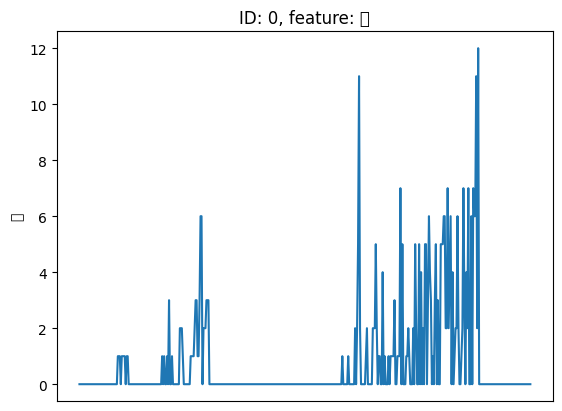

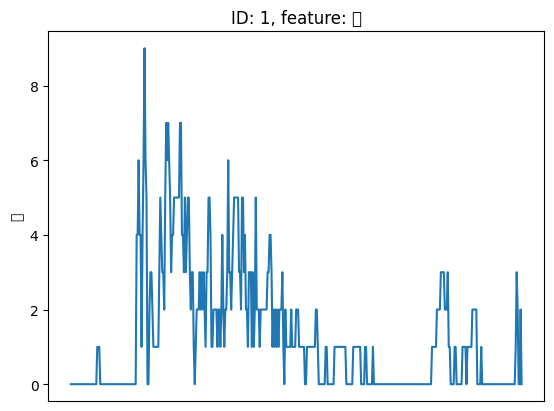

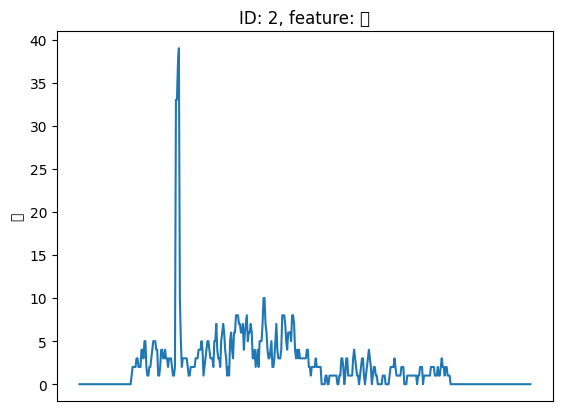

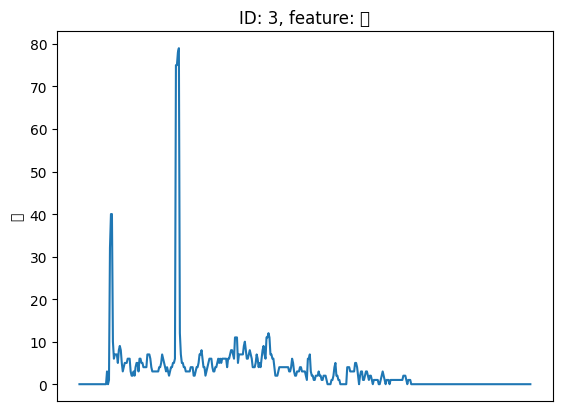

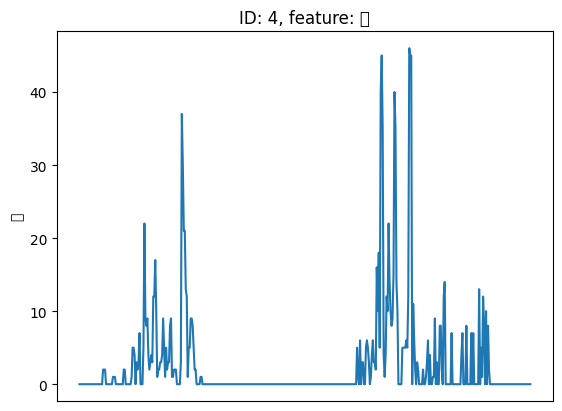

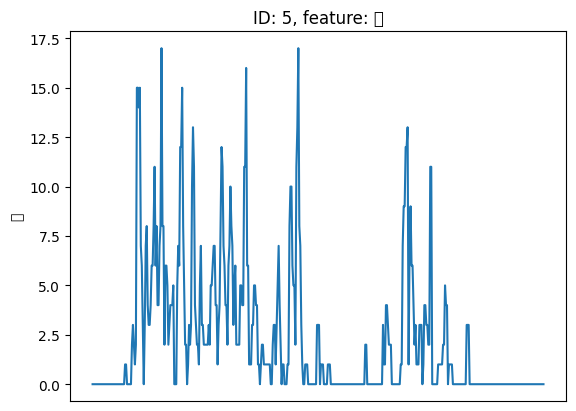

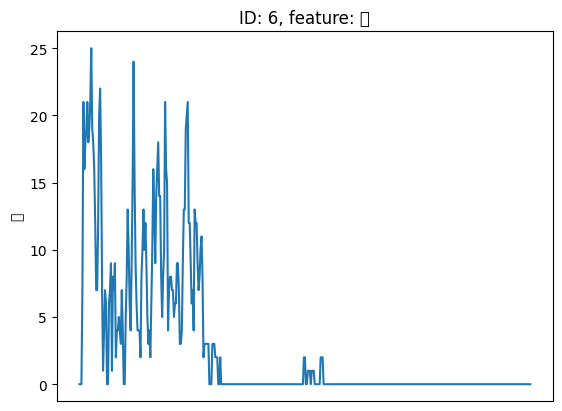

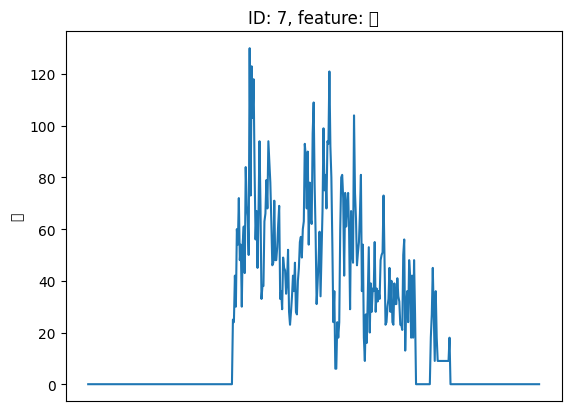

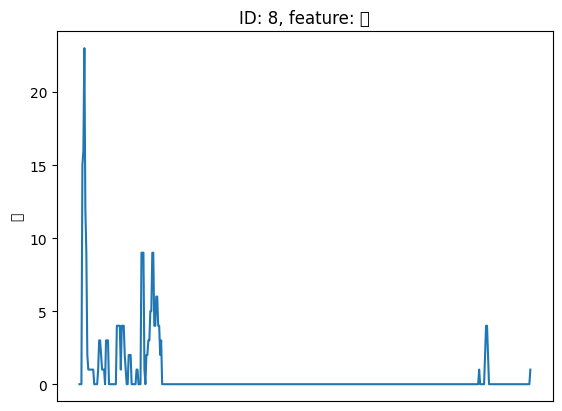

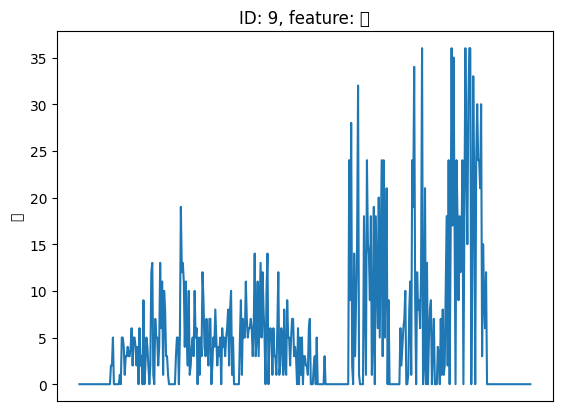

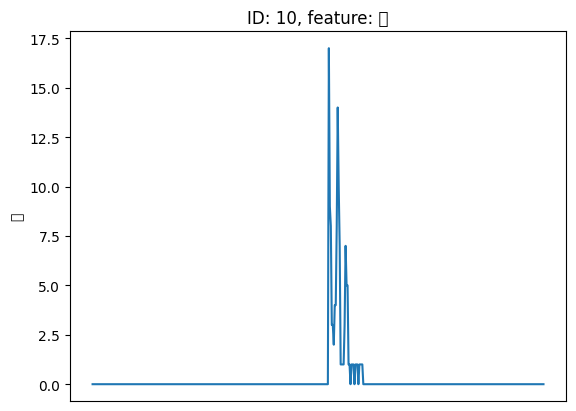

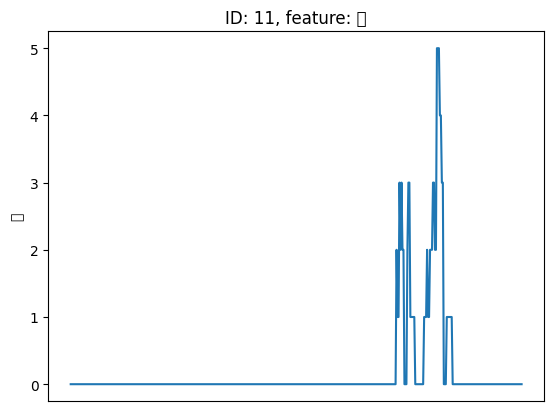

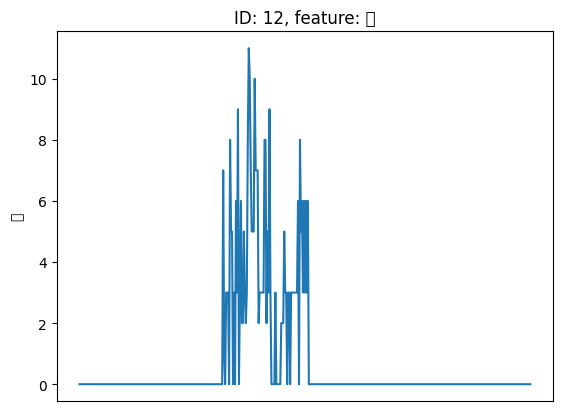

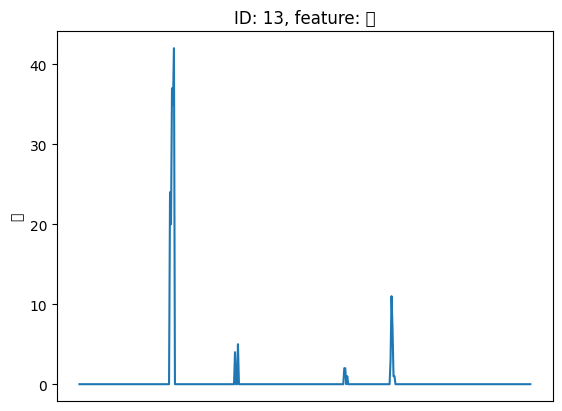

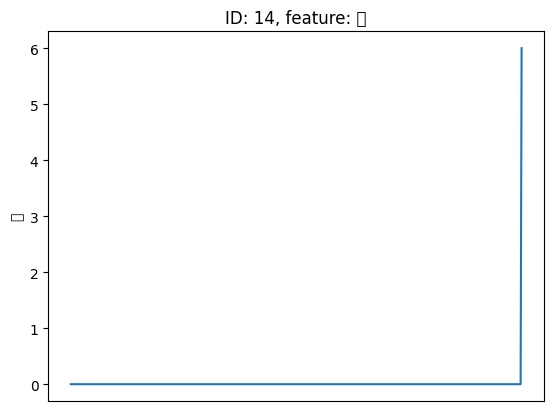

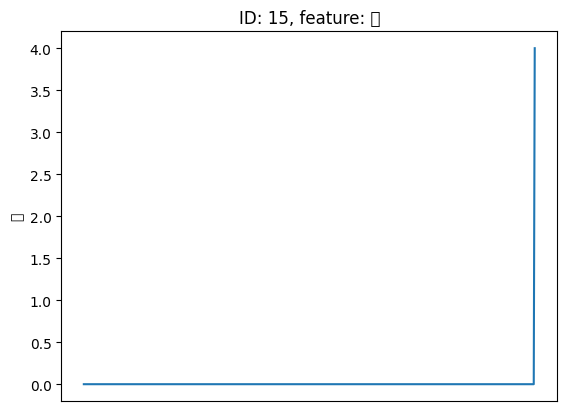

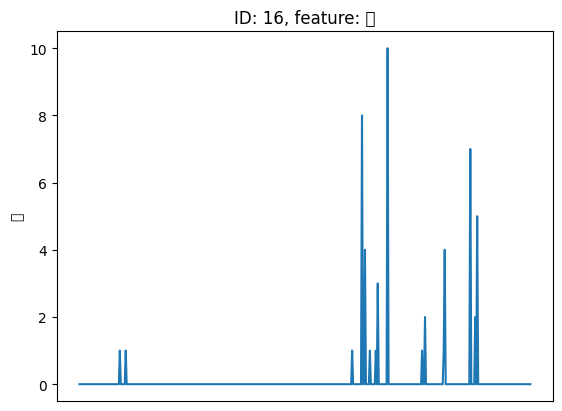

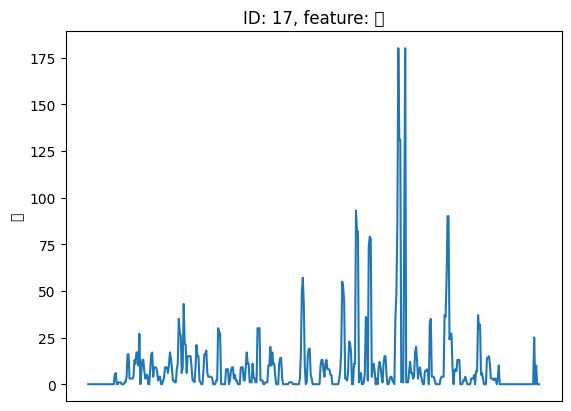

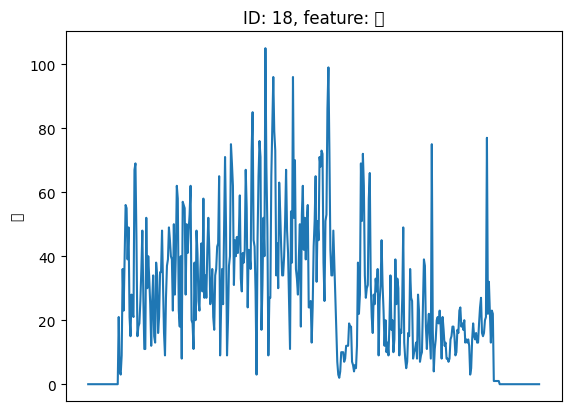

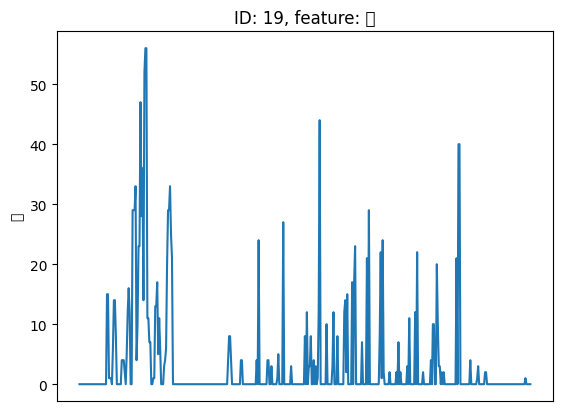

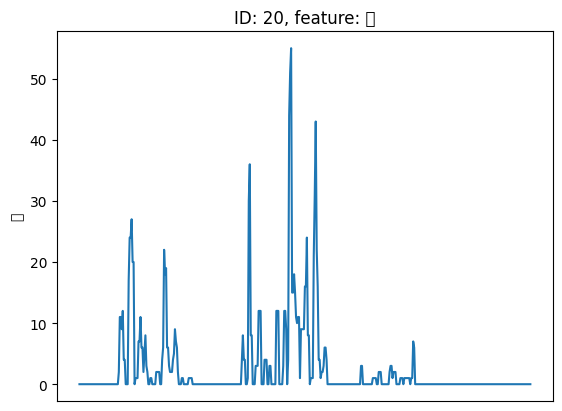

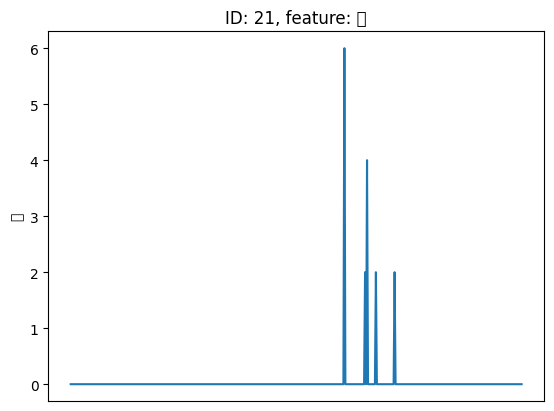

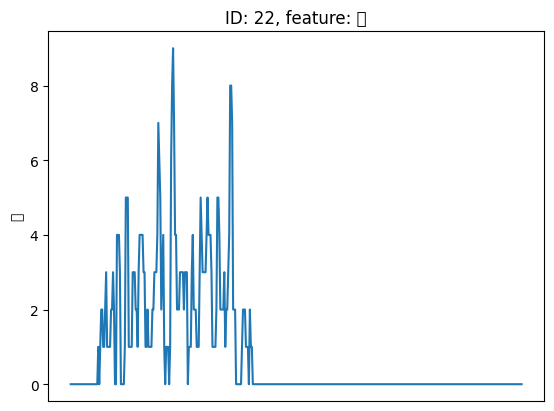

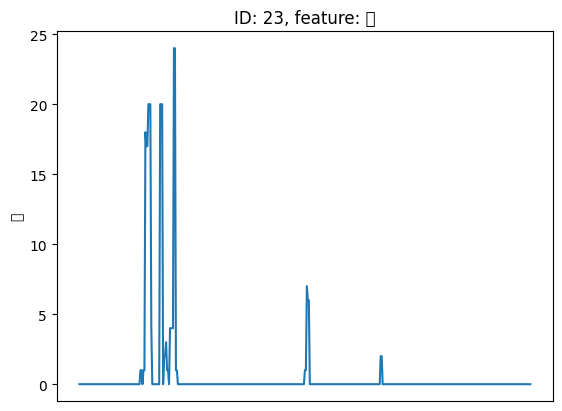

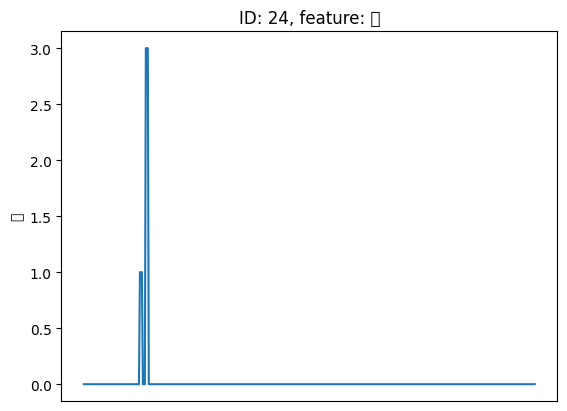

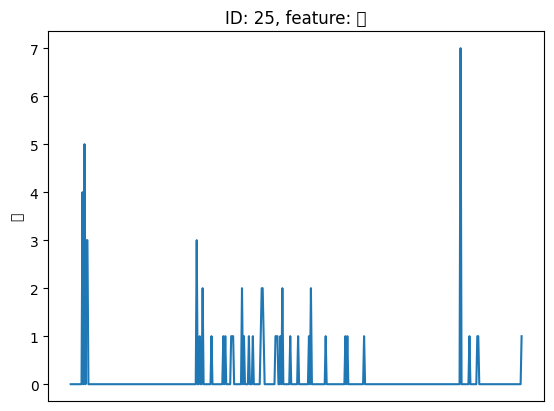

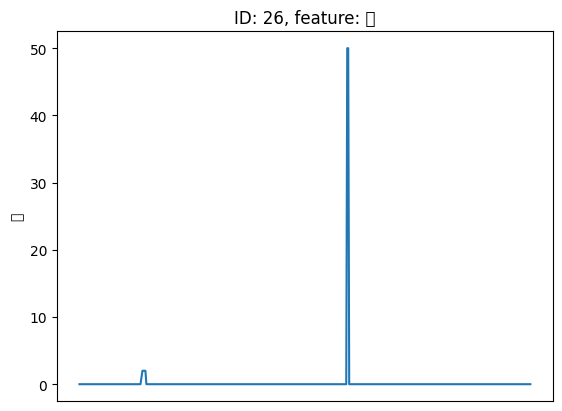

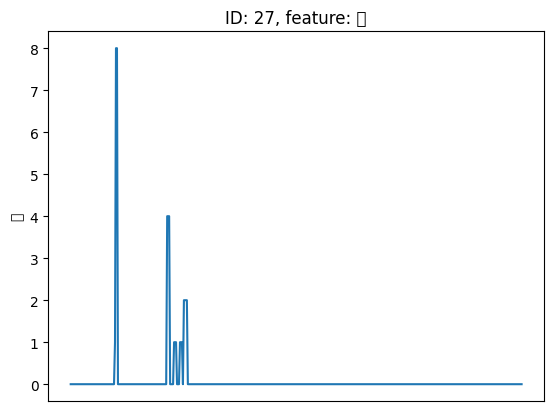

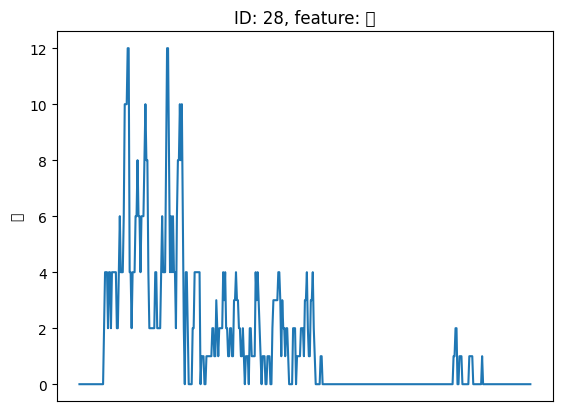

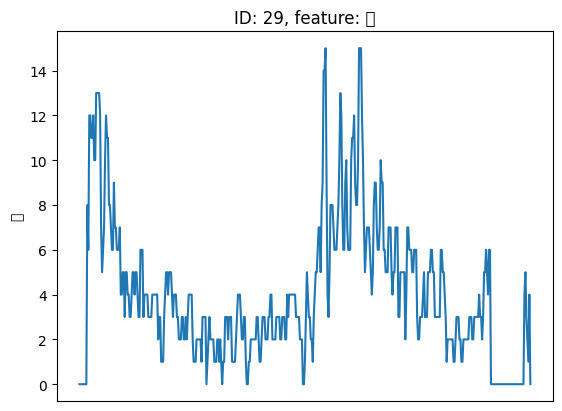

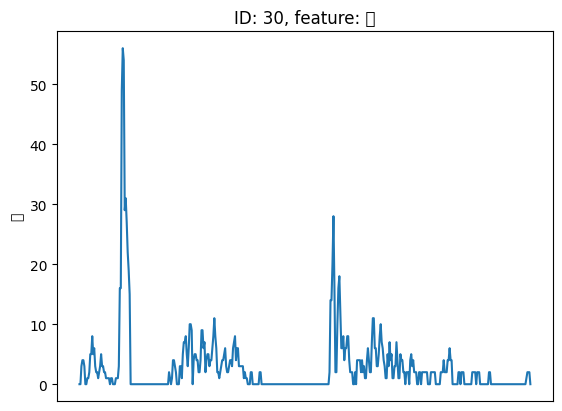

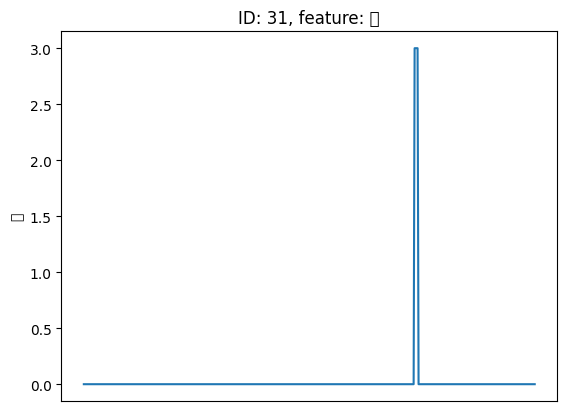

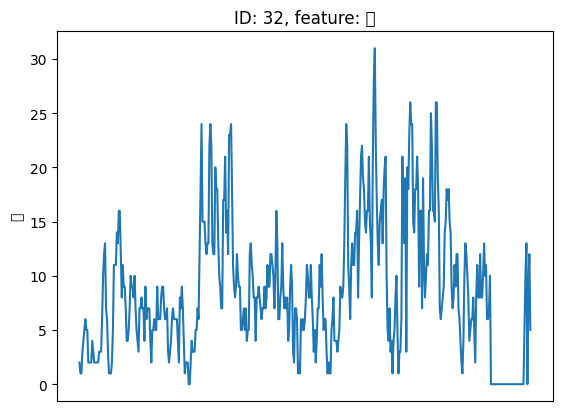

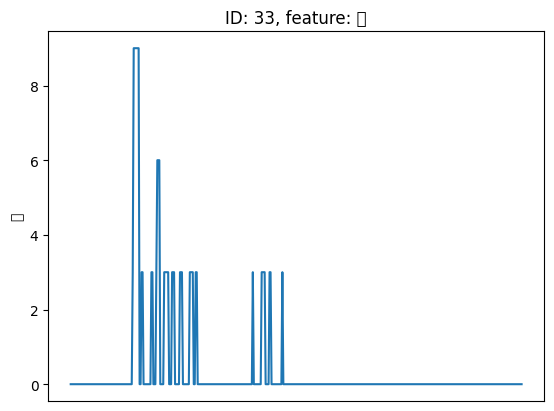

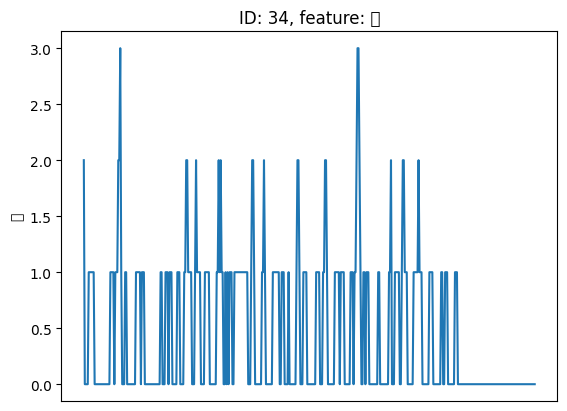

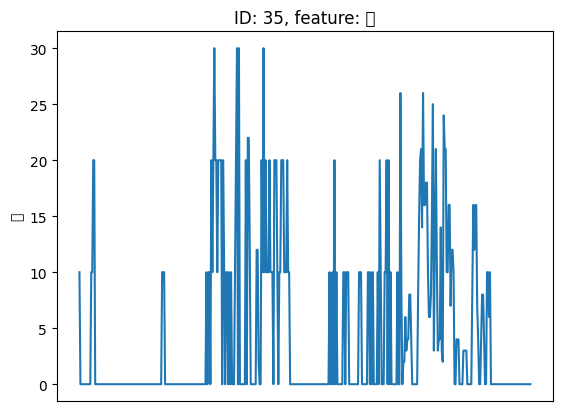

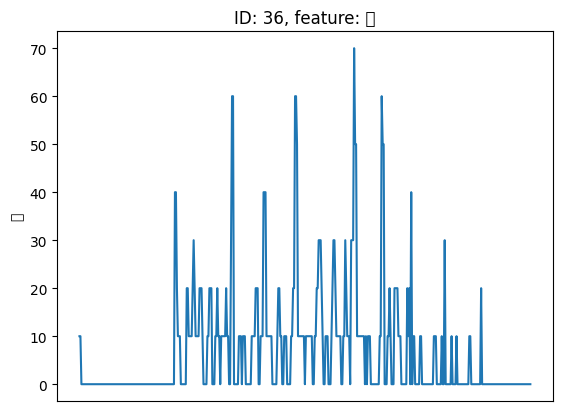

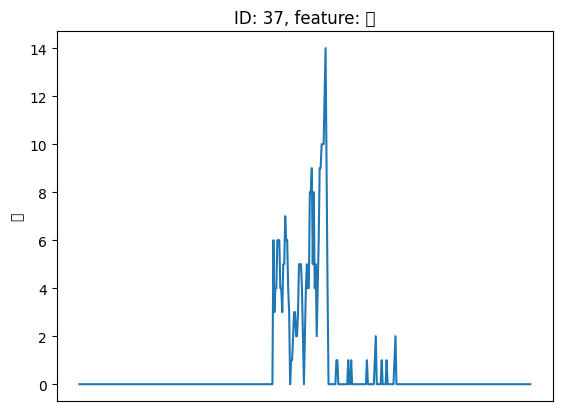

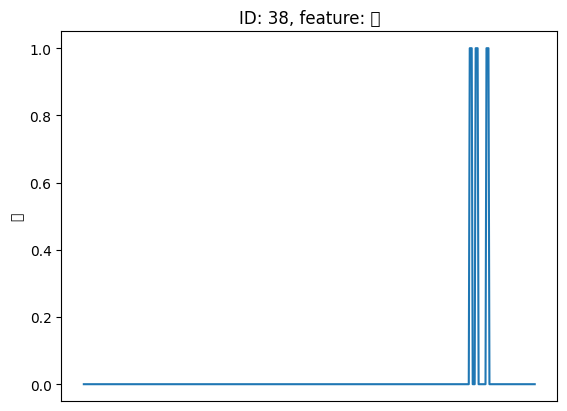

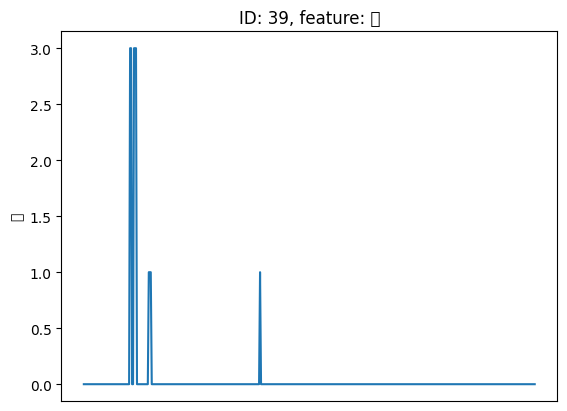

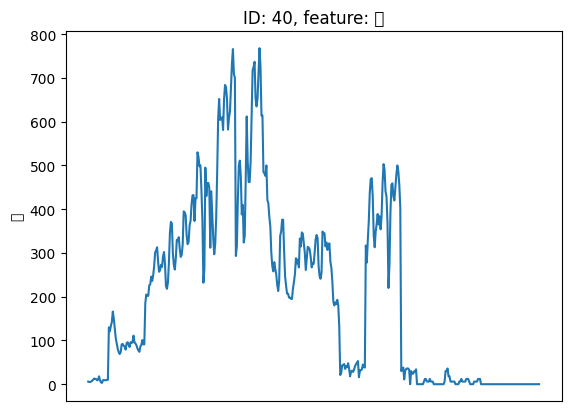

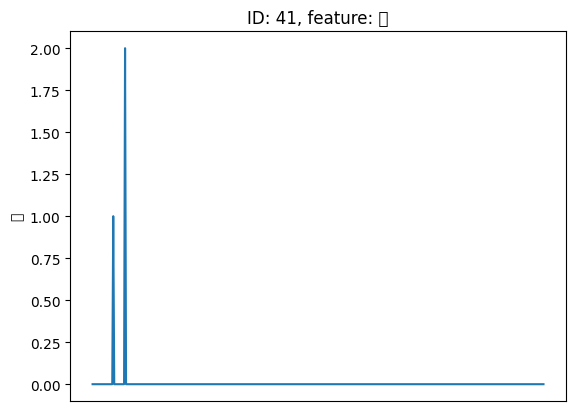

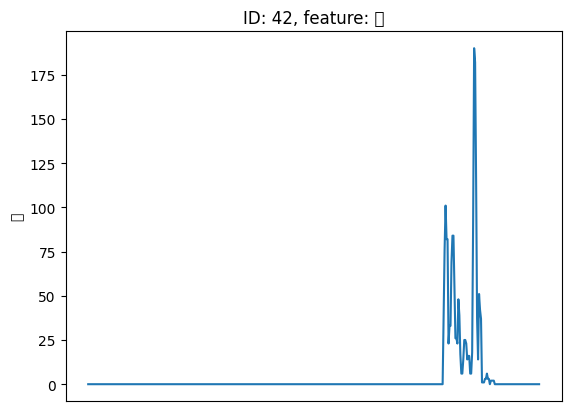

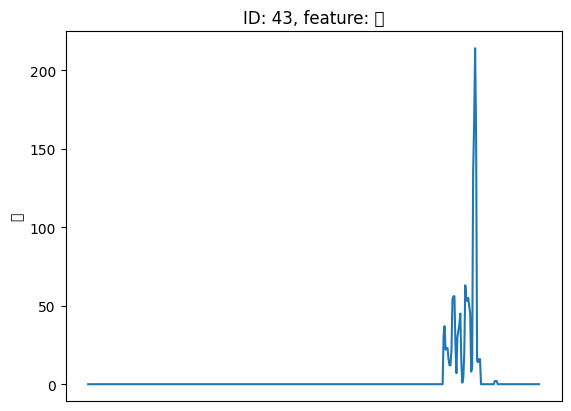

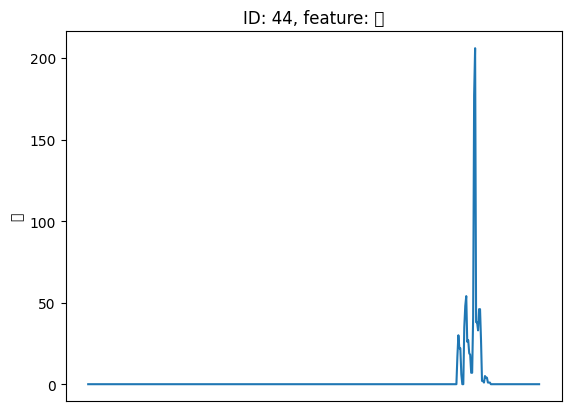

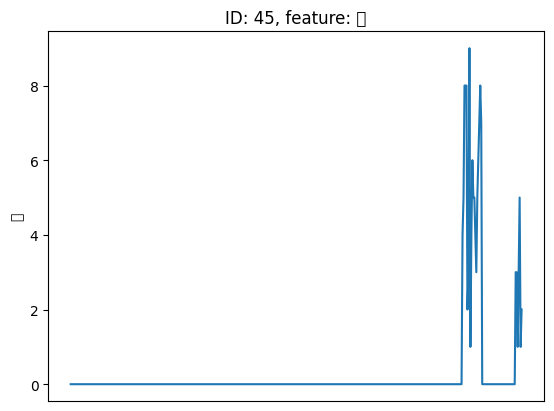

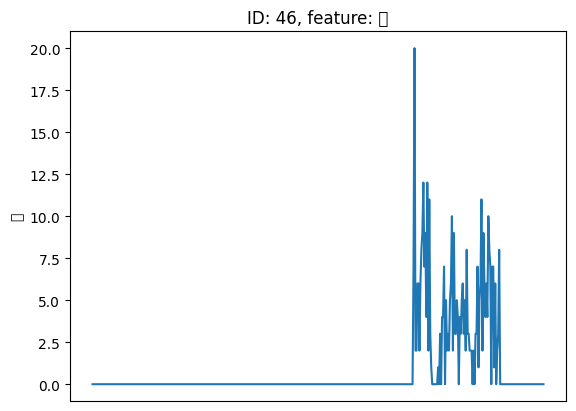

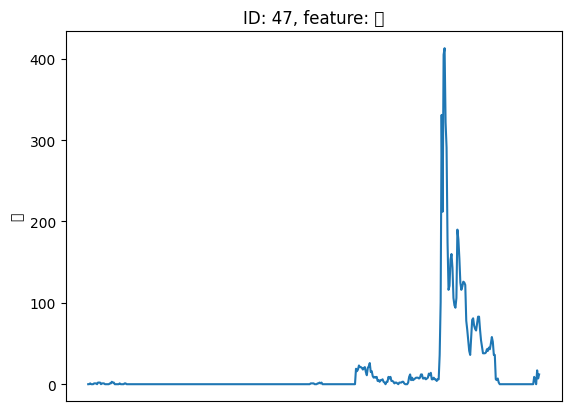

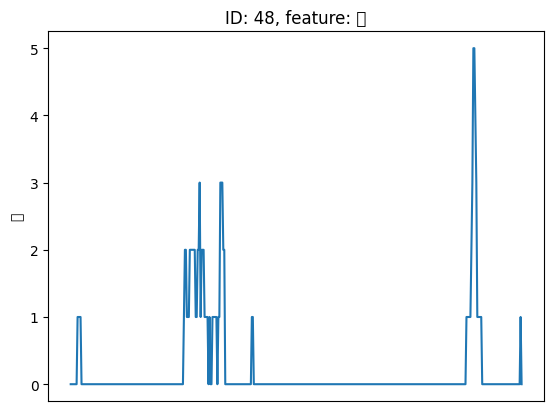

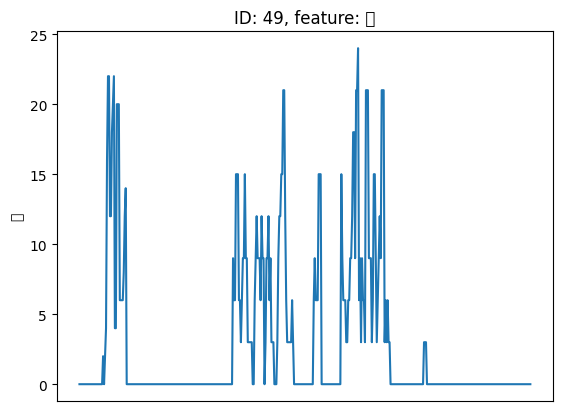

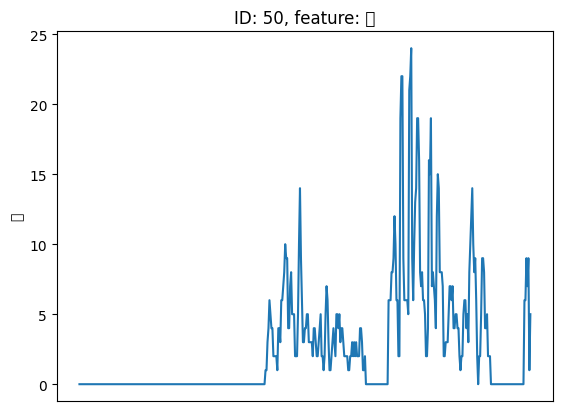

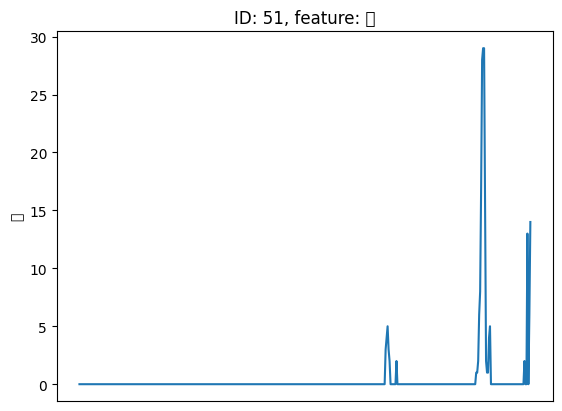

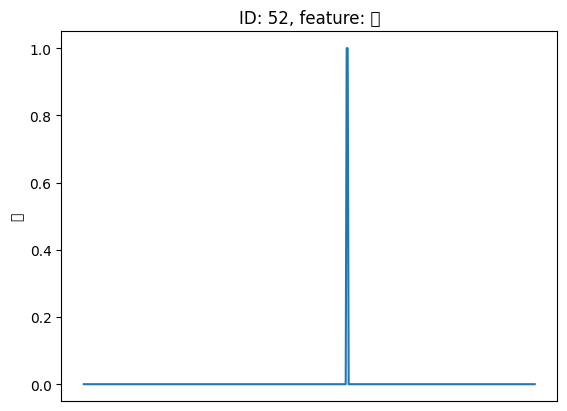

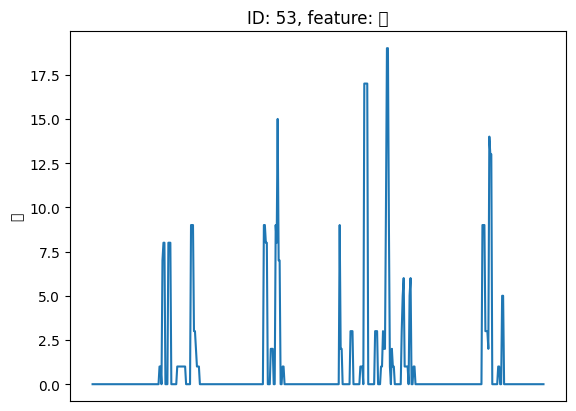

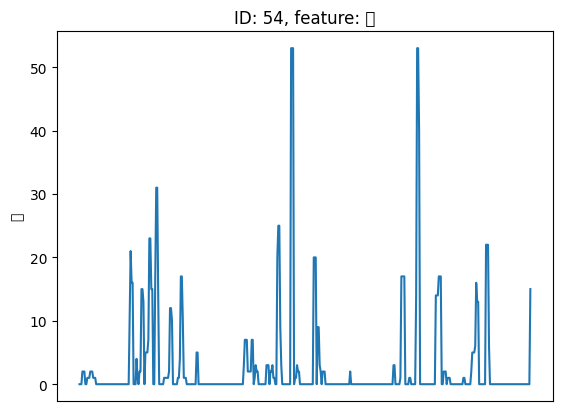

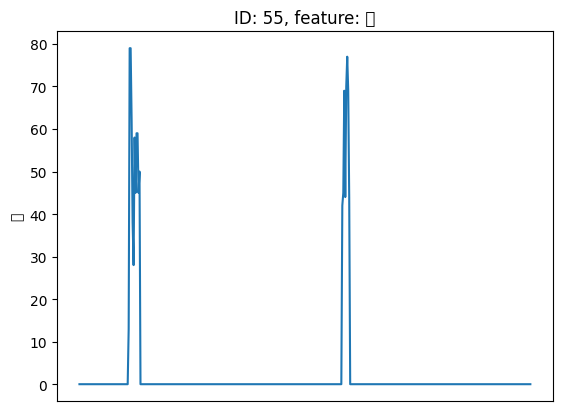

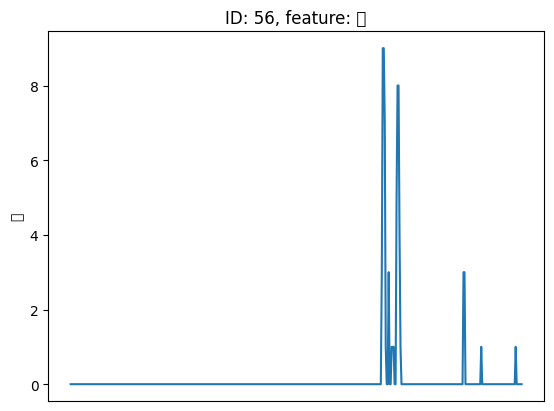

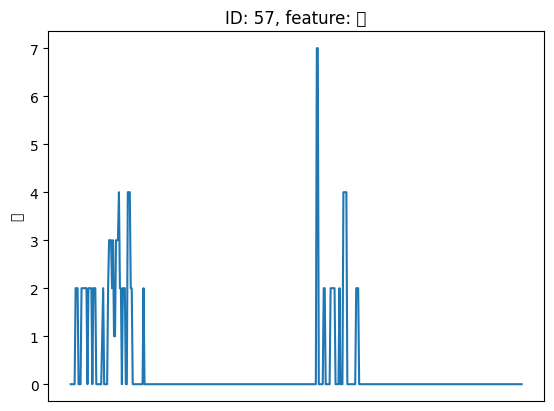

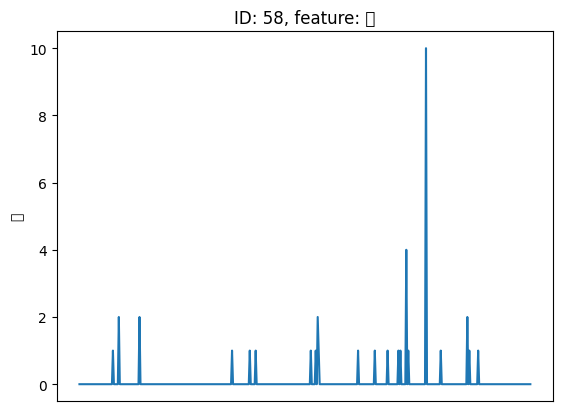

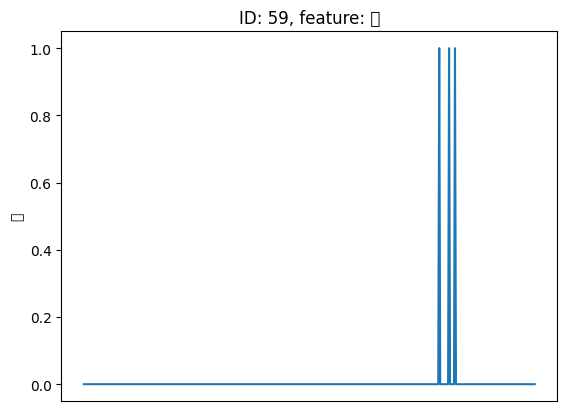

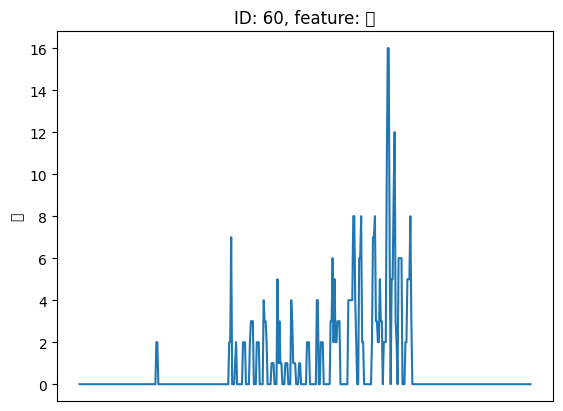

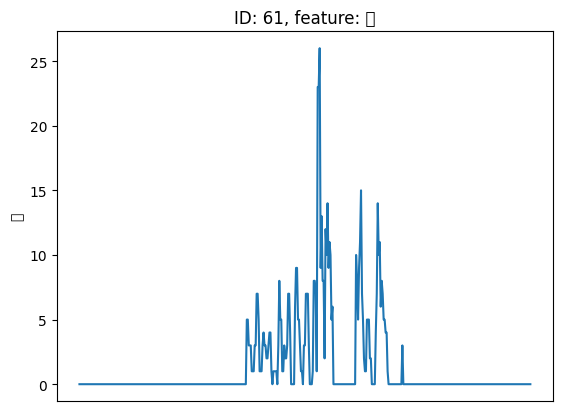

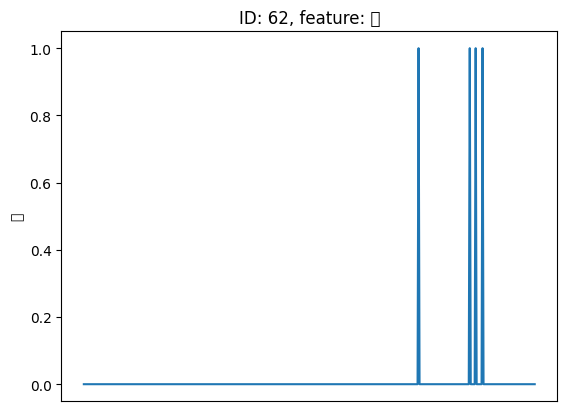

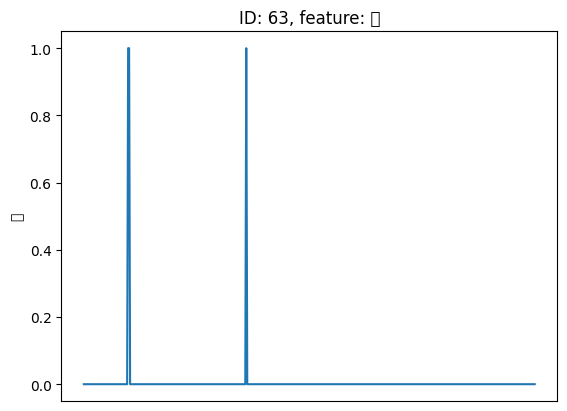

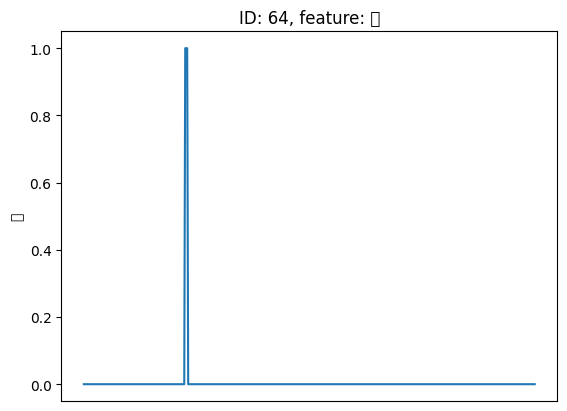

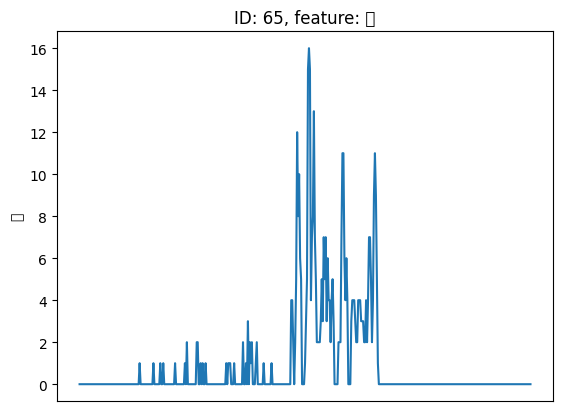

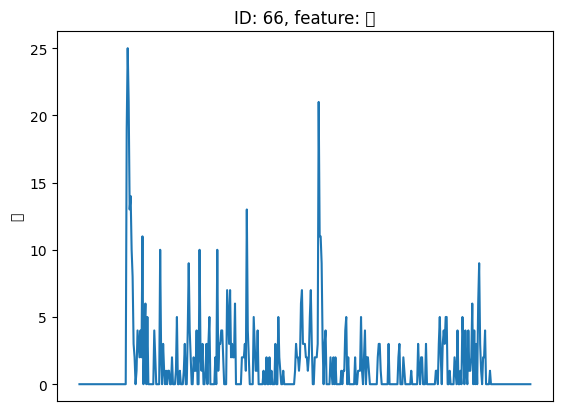

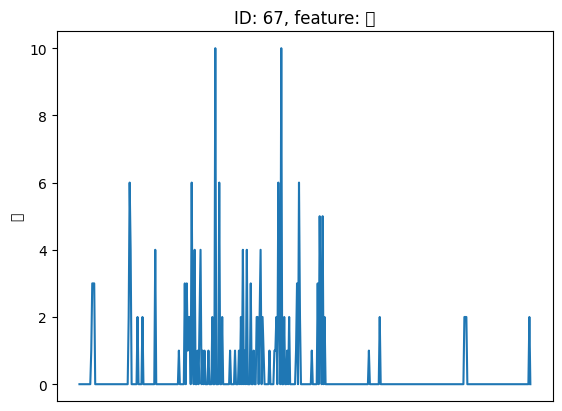

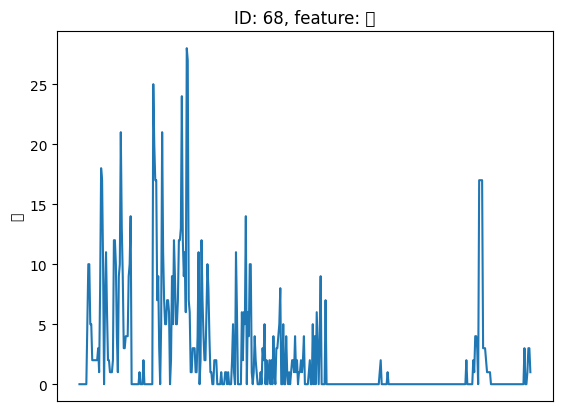

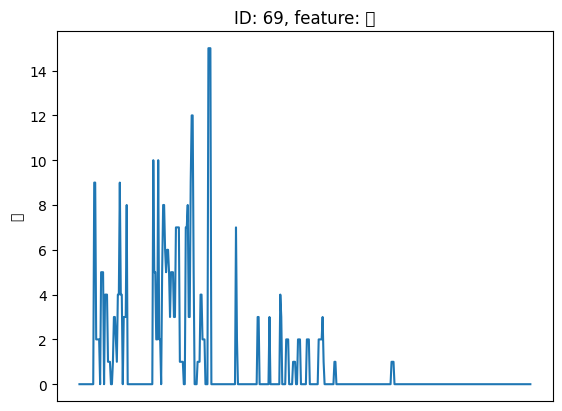

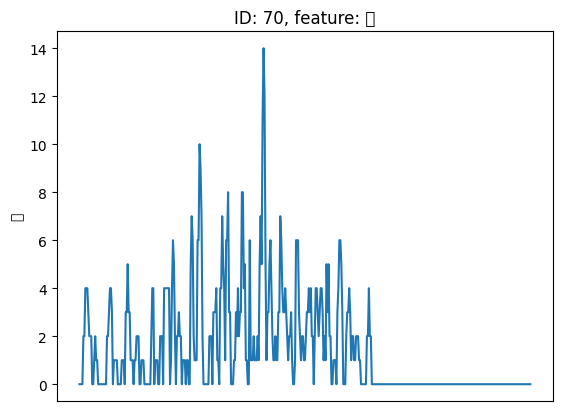

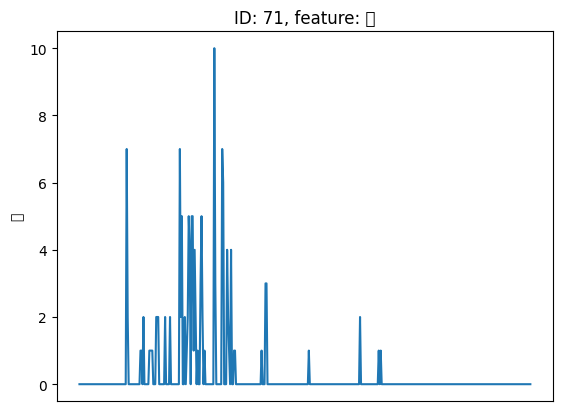

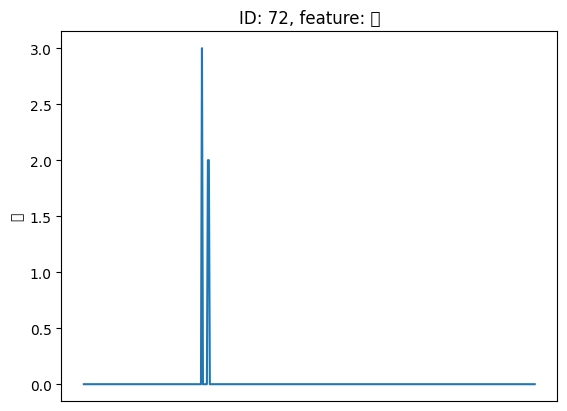

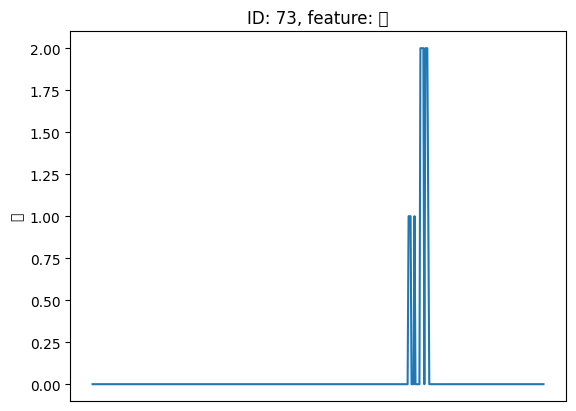

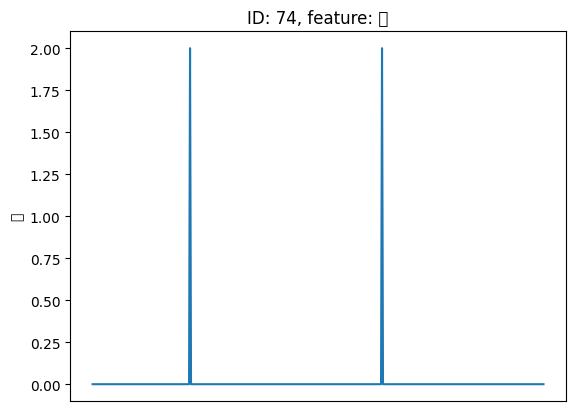

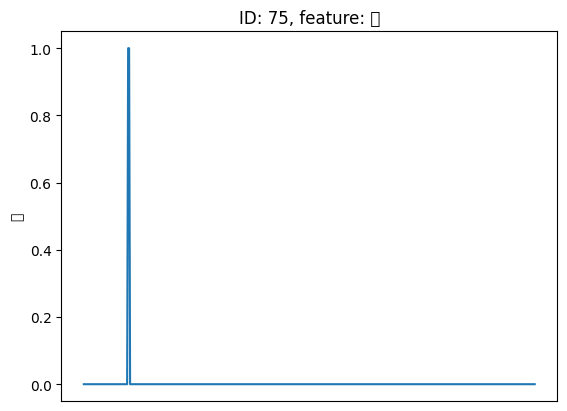

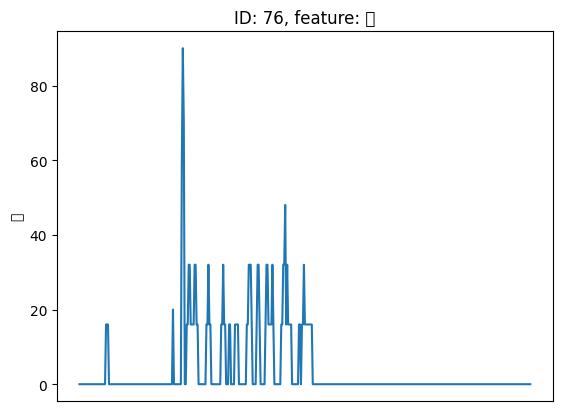

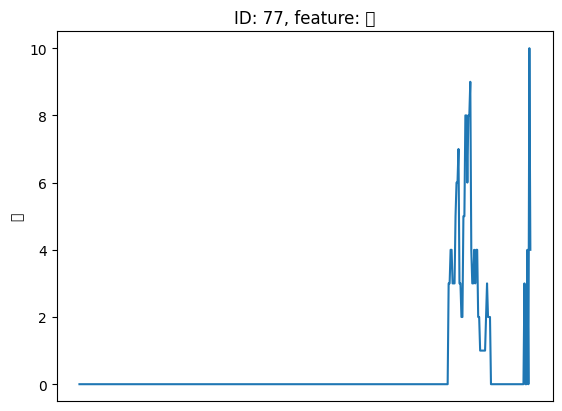

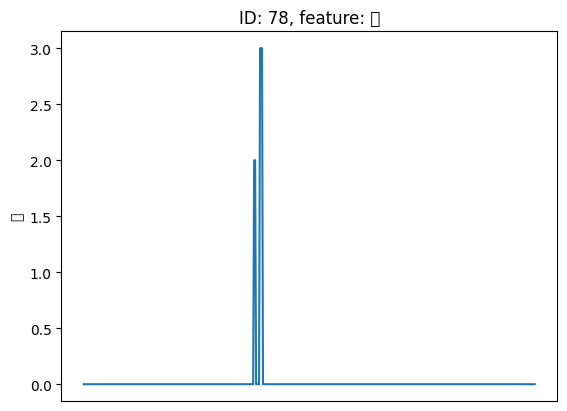

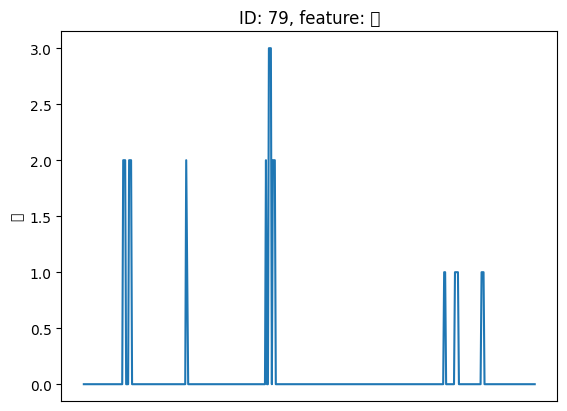

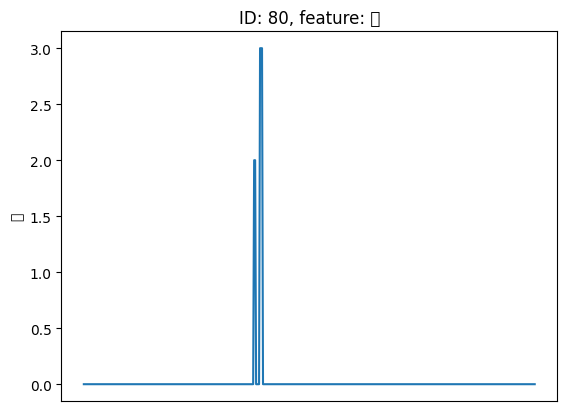

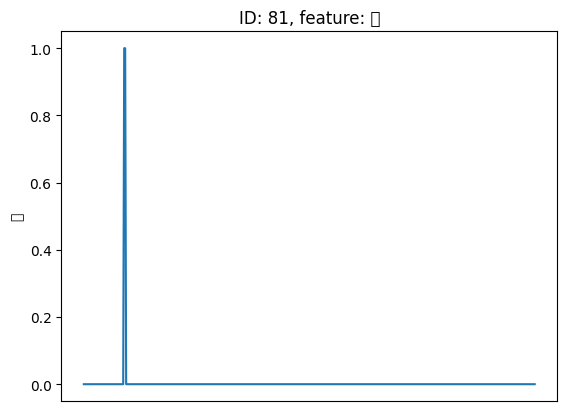

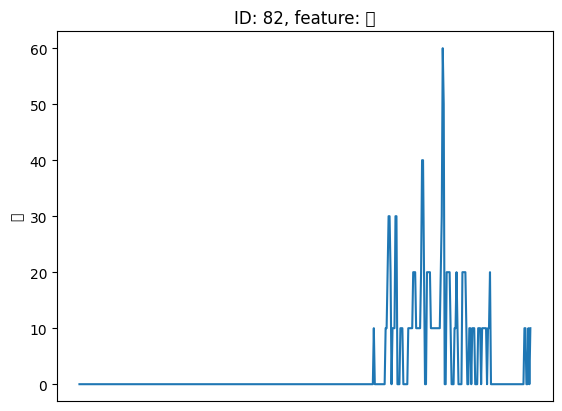

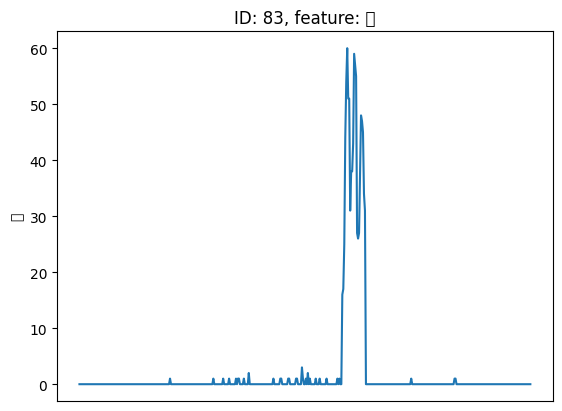

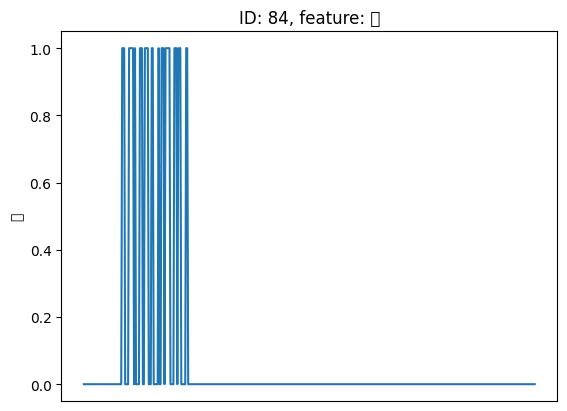

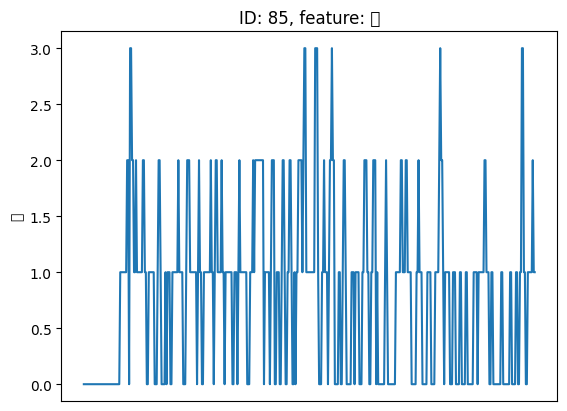

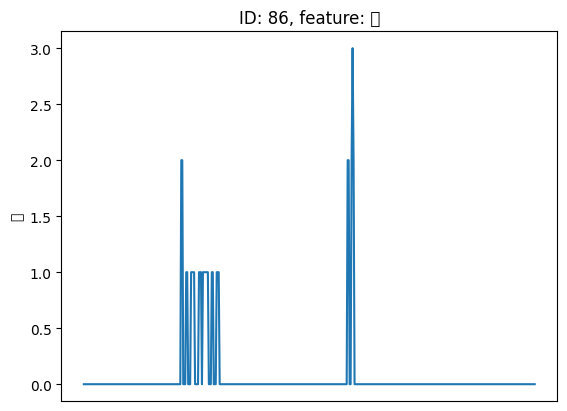

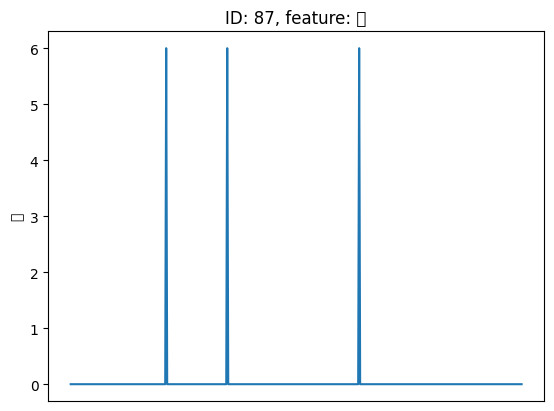

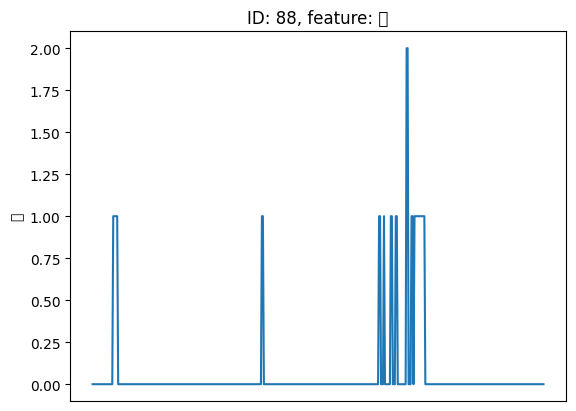

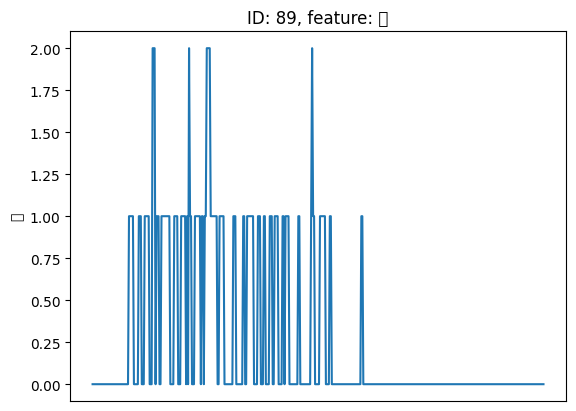

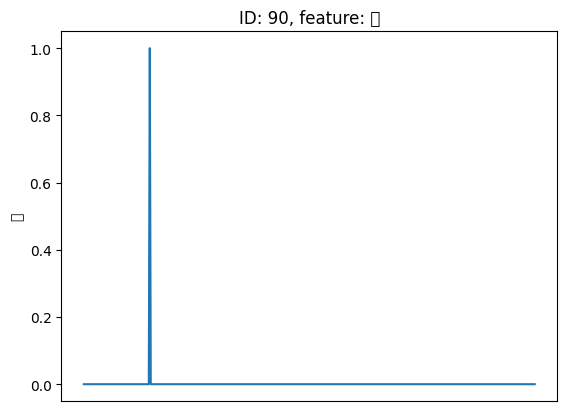

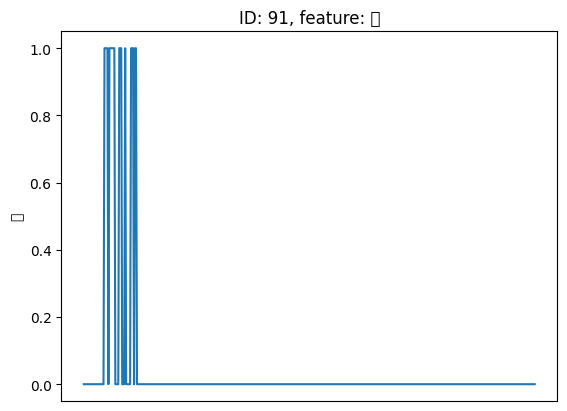

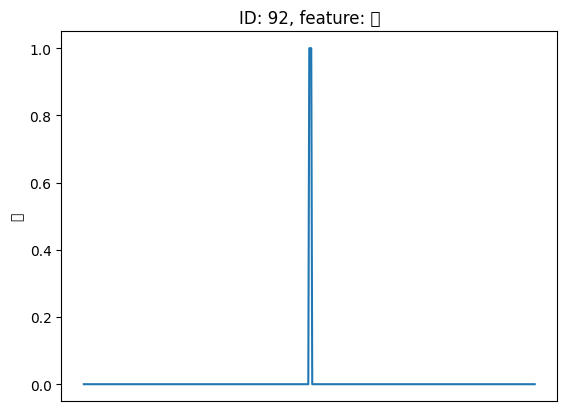

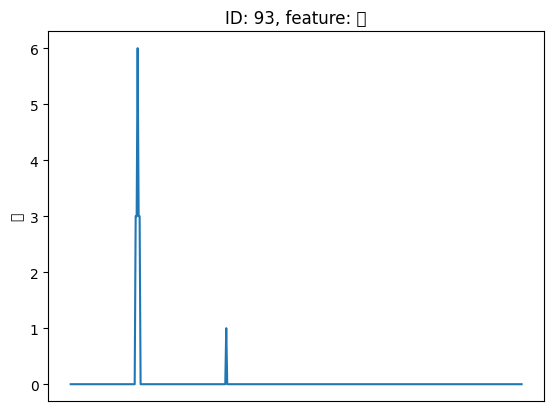

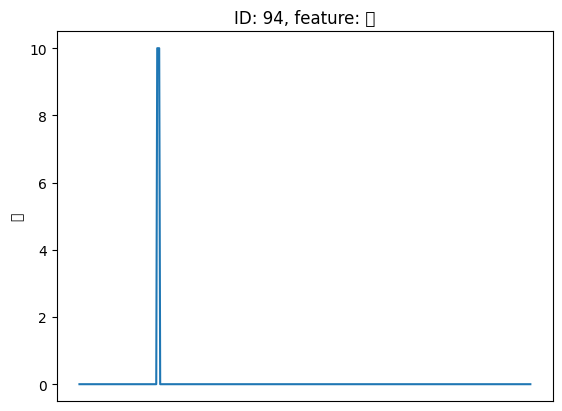

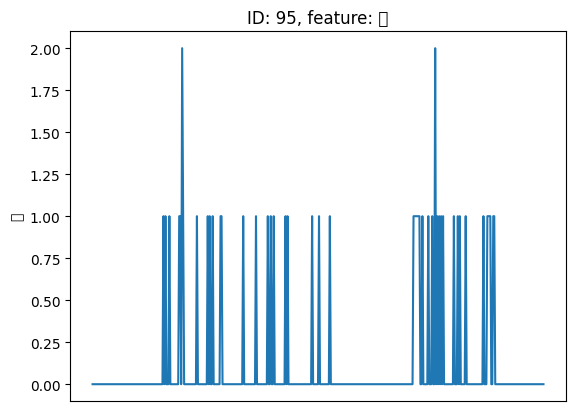

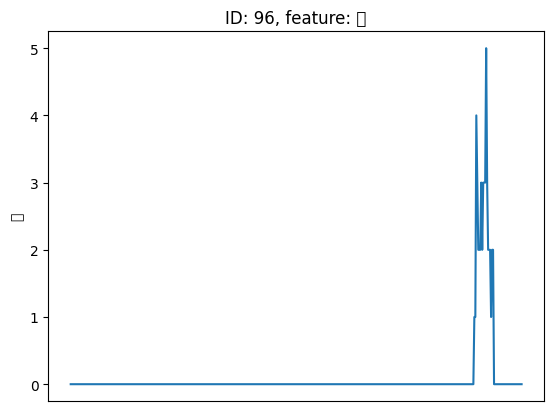

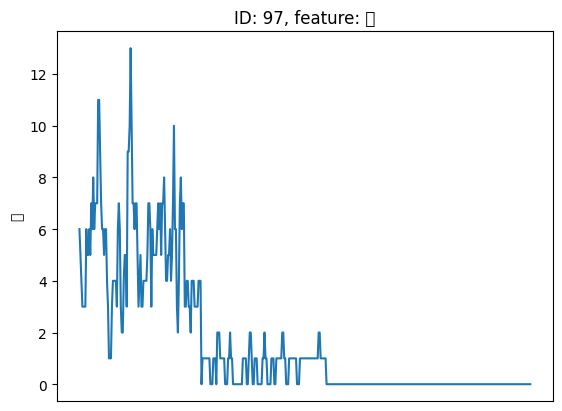

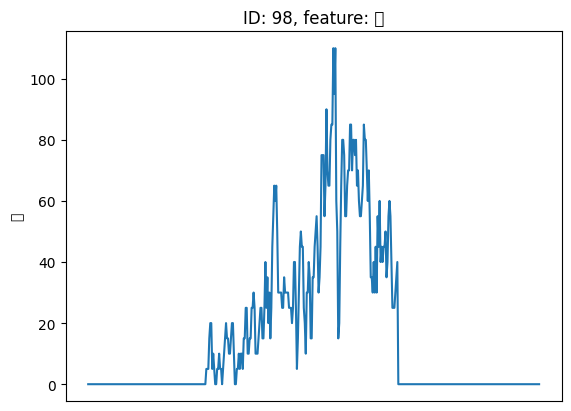

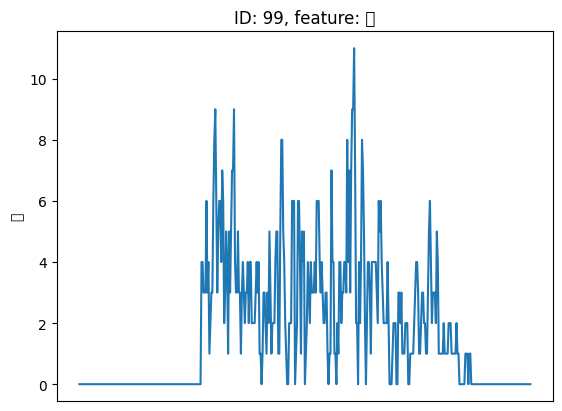

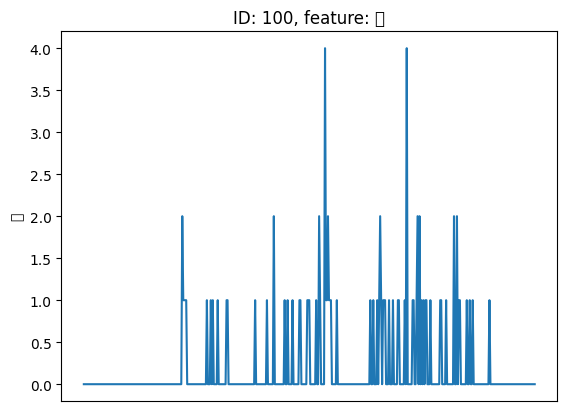

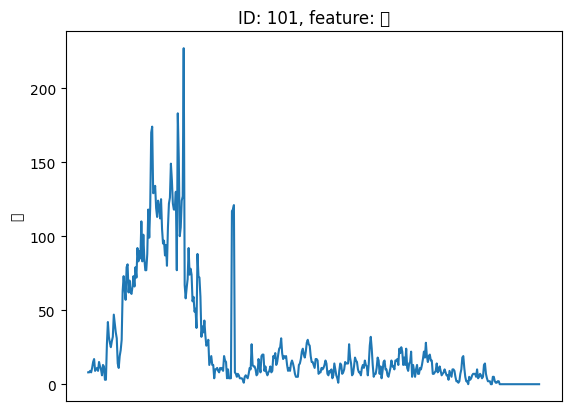

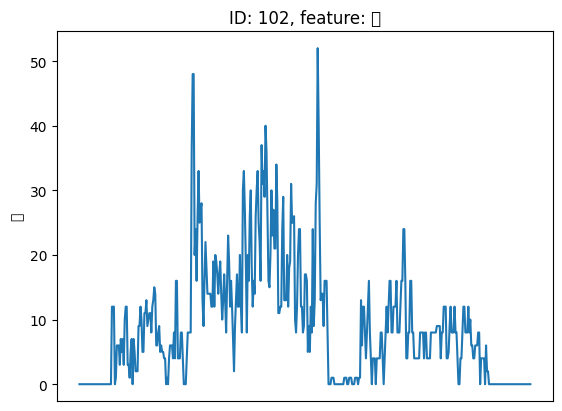

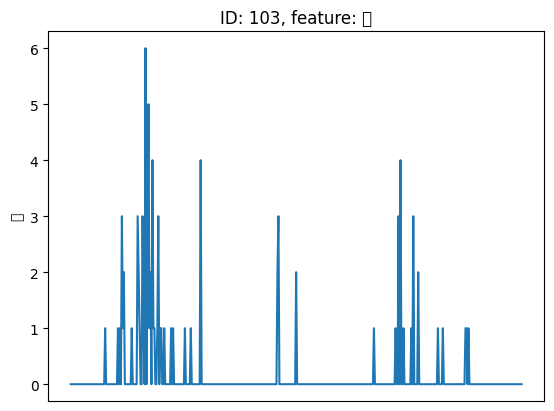

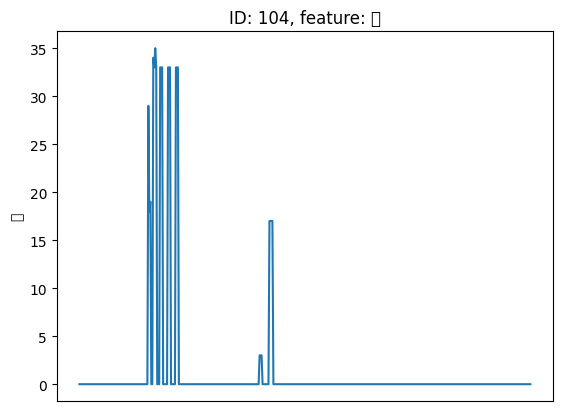

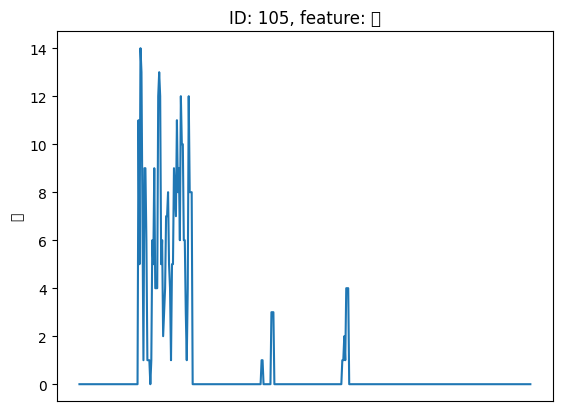

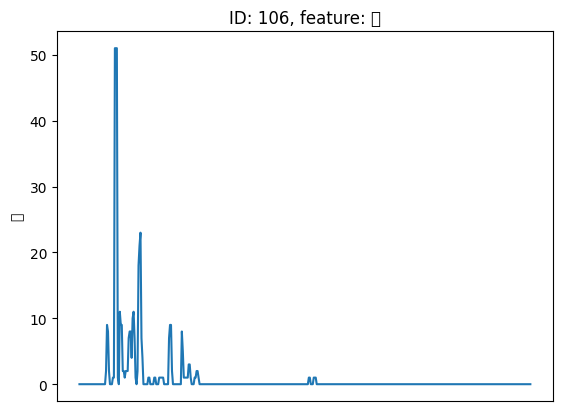

KeyboardInterrupt: ignored

In [ ]:
#train 피처별 시간순서 변화량 시각화

skip_features = ['ID','제품', '대분류',  '중분류', '소분류', '브랜드']

# For each feature in the dataframe
for col in train.columns:

    # If it's a IDerical feature and not the target and not in the skip list
    if np.issubdtype(train[col].dtype, np.number) and col not in skip_features:

        # For each unique building number
        for num in train['ID'].unique():

            # Subset the dataframe by 'ID'
            subset = train[train['ID'] == num]

            # Create a new figure
            plt.figure()

            # Plot a line plot for this feature and the target
            plt.plot(subset['날짜'], subset[col])
            plt.xlabel('') # remove x-axis label
            plt.xticks([]) # remove x-axis ticks
            plt.ylabel(col)
            plt.title(f"ID: {num}, feature: {col}")

            # Show the plot
            plt.show()


# 대분류

In [ ]:
train['소분류'].unique()

array(['B002-C003-0038', 'B002-C003-0044', 'B002-C003-0003',
       'B002-C003-0032', 'B002-C003-0034', 'B002-C003-0039',
       'B002-C003-0019', 'B002-C003-0025', 'B002-C003-0001',
       'B002-C003-0004', 'B002-C003-0036', 'B002-C003-0005',
       'B002-C003-0012', 'B002-C003-0011', 'B002-C003-0016',
       'B002-C003-0009', 'B002-C003-0010', 'B002-C003-0052',
       'B002-C003-0053', 'B002-C003-0006', 'B002-C003-0007',
       'B002-C003-0029', 'B002-C003-0045', 'B002-C003-0015',
       'B002-C003-0002', 'B002-C003-0022', 'B002-C003-0008',
       'B002-C003-0018', 'B002-C003-0035', 'B002-C003-0037',
       'B002-C003-0046', 'B002-C003-0040', 'B002-C003-0047',
       'B002-C003-0014', 'B002-C003-0023', 'B002-C003-0021',
       'B002-C003-0020', 'B002-C003-0013', 'B002-C003-0017',
       'B002-C003-0024', 'B002-C003-0026', 'B002-C003-0048',
       'B002-C003-0049', 'B002-C003-0028', 'B002-C003-0027',
       'B002-C003-0041', 'B002-C003-0030', 'B002-C003-0042',
       'B002-C003-0033',

In [ ]:
#train 피처별 시간순서 변화량 시각화

train_b1 = train[train['대분류'] == "B002-C001-0001"]
train_b2 = train[train['대분류'] == "B002-C001-0002"]
train_b3 = train[train['대분류'] == "B002-C001-0003"]
train_b4 = train[train['대분류'] == "B002-C001-0004"]
train_b5 = train[train['대분류'] == "B002-C001-0005"]

skip_features = ['ID','제품', '대분류',  '중분류', '소분류', '브랜드']
train_data = [train_b1, train_b2, train_b3, train_b4, train_b5]

for index, train_b in enumerate(train_data):
    # Counter to limit the number of plots
    counter = 0

    # For each feature in the dataframe
    for col in train_b.columns:

        # If it's a numerical feature and not in the skip list
        if np.issubdtype(train_b[col].dtype, np.number) and col not in skip_features:

            # For each unique ID number
            for num in train_b['ID'].unique():

                # Check if we have already plotted 50 graphs for this dataframe
                if counter >= 50:
                    break

                # Subset the dataframe by 'ID'
                subset = train_b[train_b['ID'] == num]

                # Create a new figure
                plt.figure()

                # Plot a line plot for this feature
                plt.plot(subset['날짜'], subset[col])
                plt.xlabel('') # remove x-axis label
                plt.xticks([]) # remove x-axis ticks
                plt.ylabel(col)
                # Add the 대분류 number (index + 1) and ID to the title
                plt.title(f"Big: {index + 1}번, ID: {num}")

                # Show the plot
                plt.show()

                # Increment the counter
                counter += 1

        # Exit the loop if we have already plotted 50 graphs
        if counter >= 50:
            break



# 중분류

In [ ]:
#train 피처별 시간순서 변화량 시각화

train_b1 = train[train['중분류'] == "B002-C002-0001"]
train_b2 = train[train['중분류'] == "B002-C002-0002"]
train_b3 = train[train['중분류'] == "B002-C002-0003"]
train_b4 = train[train['중분류'] == "B002-C002-0004"]
train_b5 = train[train['중분류'] == "B002-C002-0005"]
train_b6 = train[train['중분류'] == "B002-C002-0006"]
train_b7 = train[train['중분류'] == "B002-C002-0007"]
train_b8 = train[train['중분류'] == "B002-C002-0008"]
train_b9 = train[train['중분류'] == "B002-C002-0009"]
train_b10 = train[train['중분류'] == "B002-C002-0010"]
train_b11 = train[train['중분류'] == "B002-C002-0011"]

skip_features = ['ID','제품', '대분류',  '중분류', '소분류', '브랜드']
train_data = [train_b1, train_b2, train_b3, train_b4, train_b5, train_b6,train_b7,train_b8,train_b9,train_b10,train_b11]

for index, train_b in enumerate(train_data):
    # Counter to limit the number of plots
    counter = 0

    # For each feature in the dataframe
    for col in train_b.columns:

        # If it's a numerical feature and not in the skip list
        if np.issubdtype(train_b[col].dtype, np.number) and col not in skip_features:

            # For each unique ID number
            for num in train_b['ID'].unique():

                # Check if we have already plotted 50 graphs for this dataframe
                if counter >= 50:
                    break

                # Subset the dataframe by 'ID'
                subset = train_b[train_b['ID'] == num]

                # Create a new figure
                plt.figure()

                # Plot a line plot for this feature
                plt.plot(subset['날짜'], subset[col])
                plt.xlabel('') # remove x-axis label
                plt.xticks([]) # remove x-axis ticks
                plt.ylabel(col)
                # Add the 대분류 number (index + 1) and ID to the title
                plt.title(f"mid: {index + 1}, ID: {num}")

                # Show the plot
                plt.show()

                # Increment the counter
                counter += 1

        # Exit the loop if we have already plotted 50 graphs
        if counter >= 50:
            break



# 소분류

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 소분류의 unique값을 가져옵니다.
subcategories = train['소분류'].unique()

# 소분류별로 데이터를 분리합니다.
train_data = [train[train['소분류'] == subcategory] for subcategory in subcategories]

skip_features = ['ID', '제품', '대분류', '중분류', '소분류', '브랜드']

for index, train_sub in enumerate(train_data):
    # Counter to limit the number of plots
    counter = 0

    # For each feature in the dataframe
    for col in train_sub.columns:

        # If it's a numerical feature and not in the skip list
        if np.issubdtype(train_sub[col].dtype, np.number) and col not in skip_features:

            # For each unique ID number
            for num in train_sub['ID'].unique():

                # Check if we have already plotted 50 graphs for this dataframe
                if counter >= 20:
                    break

                # Subset the dataframe by 'ID'
                subset = train_sub[train_sub['ID'] == num]

                # Create a new figure
                plt.figure()

                # Plot a line plot for this feature
                plt.plot(subset['날짜'], subset[col])
                plt.xlabel('') # remove x-axis label
                plt.xticks([]) # remove x-axis ticks
                plt.ylabel(col)
                # Add the 소분류 and ID to the title
                plt.title(f"sub: {subcategories[index]}, ID: {num}")

                # Show the plot
                plt.show()

                # Increment the counter
                counter += 1

        # Exit the loop if we have already plotted 20 graphs
        if counter >= 20:
            break


# 주기

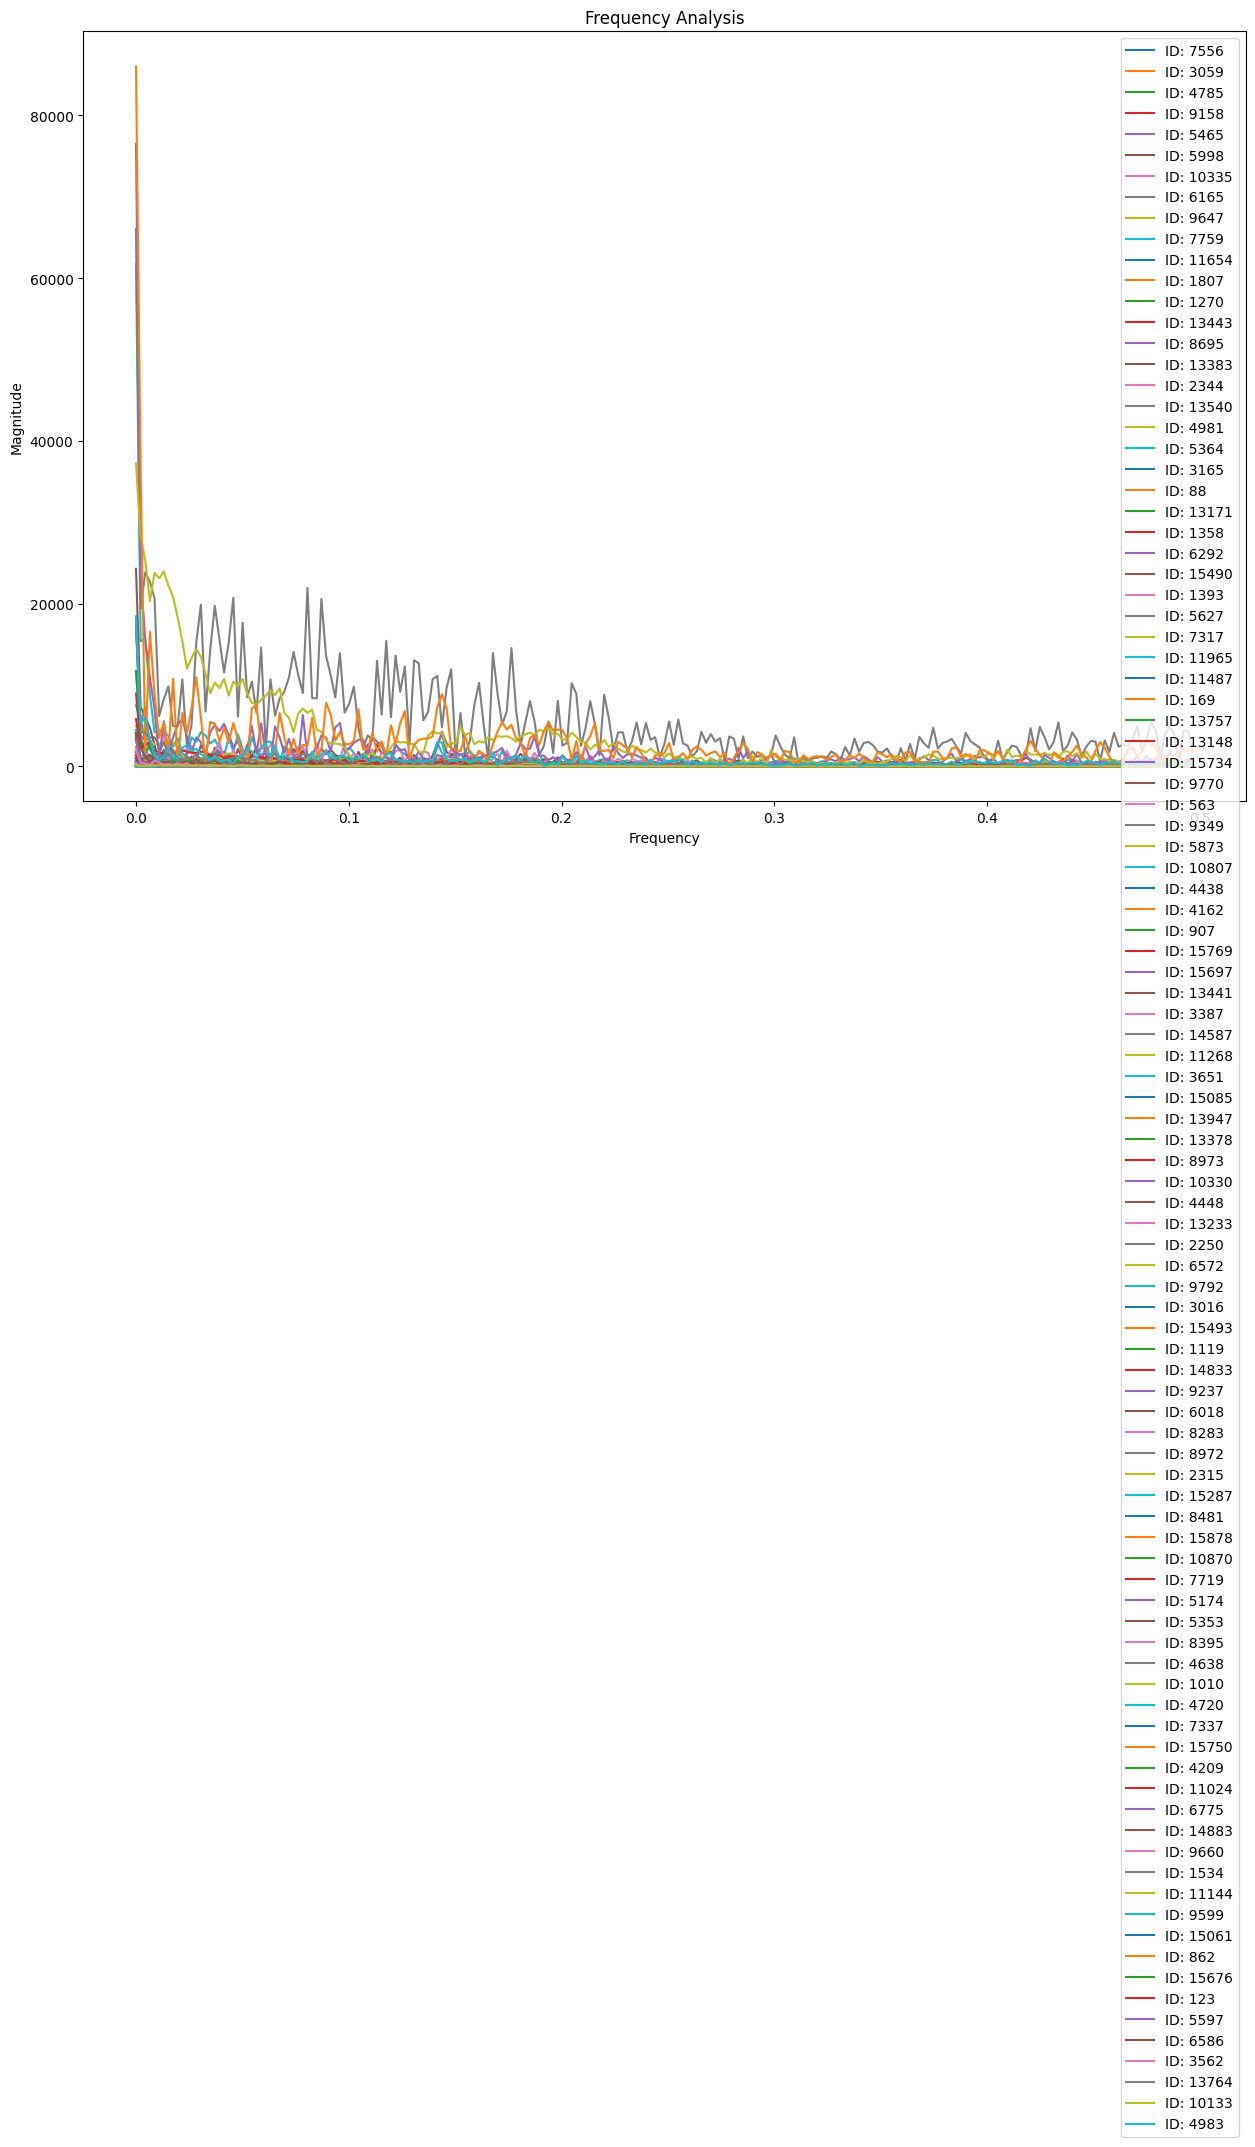

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Fourier 변환을 수행하여 주파수와 그에 해당하는 크기를 반환하는 함수
def analyze_frequency(signal):
    fft_output = np.fft.fft(signal)
    magnitude = np.abs(fft_output)[:len(signal)//2]
    frequency = np.fft.fftfreq(len(signal))[:len(signal)//2]
    return frequency, magnitude

# 샘플로 5개의 ID를 선택하여 분석
sample_ids = train['ID'].sample(n=100, random_state=42)

plt.figure(figsize=(15, 10))
for idx in sample_ids:
    time_series_data = train.iloc[idx, 6:].values
    frequency, magnitude = analyze_frequency(time_series_data)

    plt.plot(frequency, magnitude, label=f'ID: {idx}')

plt.title('Frequency Analysis')
plt.xlabel('Frequency')
plt.ylabel('Magnitude')
plt.legend()
plt.show()

In [ ]:
# 각 ID 별로 주기를 분석하고 주기를 저장하는 딕셔너리
id_period_dict = {}

# 모든 ID에 대해 주기를 분석
for idx, row in train.iterrows():
    time_series_data = row[6:].values
    frequency, magnitude = analyze_frequency(time_series_data)

    # 크기가 가장 큰 주파수 성분을 찾아 주기로 변환
    if np.sum(magnitude) != 0: # 모든 값이 0이 아닌 경우에만 분석
        main_frequency = frequency[np.argmax(magnitude)]
        if main_frequency != 0: # 주파수가 0이 아닌 경우에만 주기 계산
            period = 1 / main_frequency
            id_period_dict[row['ID']] = period

# 분석된 주기의 일부를 출력
sample_periods = {key: id_period_dict[key] for key in list(id_period_dict.keys())[:5]}
sample_periods


{14: 2.4157894736842103,
 15: 30.599999999999998,
 90: 16.392857142857142,
 467: 26.999999999999996,
 479: 114.74999999999999}

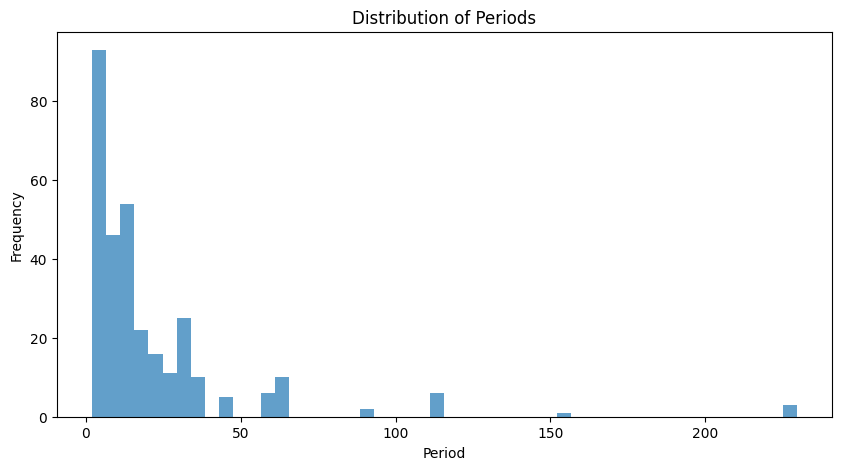

{'Mean': 21.171142281020025,
 'Median': 11.769230769230768,
 'Standard Deviation': 30.34121573339455}

In [ ]:
# 주기 값들의 리스트
periods = list(id_period_dict.values())

# 히스토그램 그리기
plt.figure(figsize=(10, 5))
plt.hist(periods, bins=50, alpha=0.7)
plt.title('Distribution of Periods')
plt.xlabel('Period')
plt.ylabel('Frequency')
plt.show()

# 주기 값의 기술 통계량
period_stats = {
    'Mean': np.mean(periods),
    'Median': np.median(periods),
    'Standard Deviation': np.std(periods),
}

period_stats


In [ ]:
from collections import defaultdict

# 임계값 설정 (표준 편차의 10%)
threshold = period_stats['Standard Deviation'] * 0.10

# 유사한 주기를 가진 ID를 그룹화
groups = defaultdict(list)
for id1, period1 in id_period_dict.items():
    for id2, period2 in id_period_dict.items():
        if id1 != id2 and abs(period1 - period2) < threshold:
            groups[id1].append(id2)

# 그룹화된 결과의 일부를 출력
sample_groups = {key: groups[key] for key in list(groups.keys())[:3]}
sample_groups


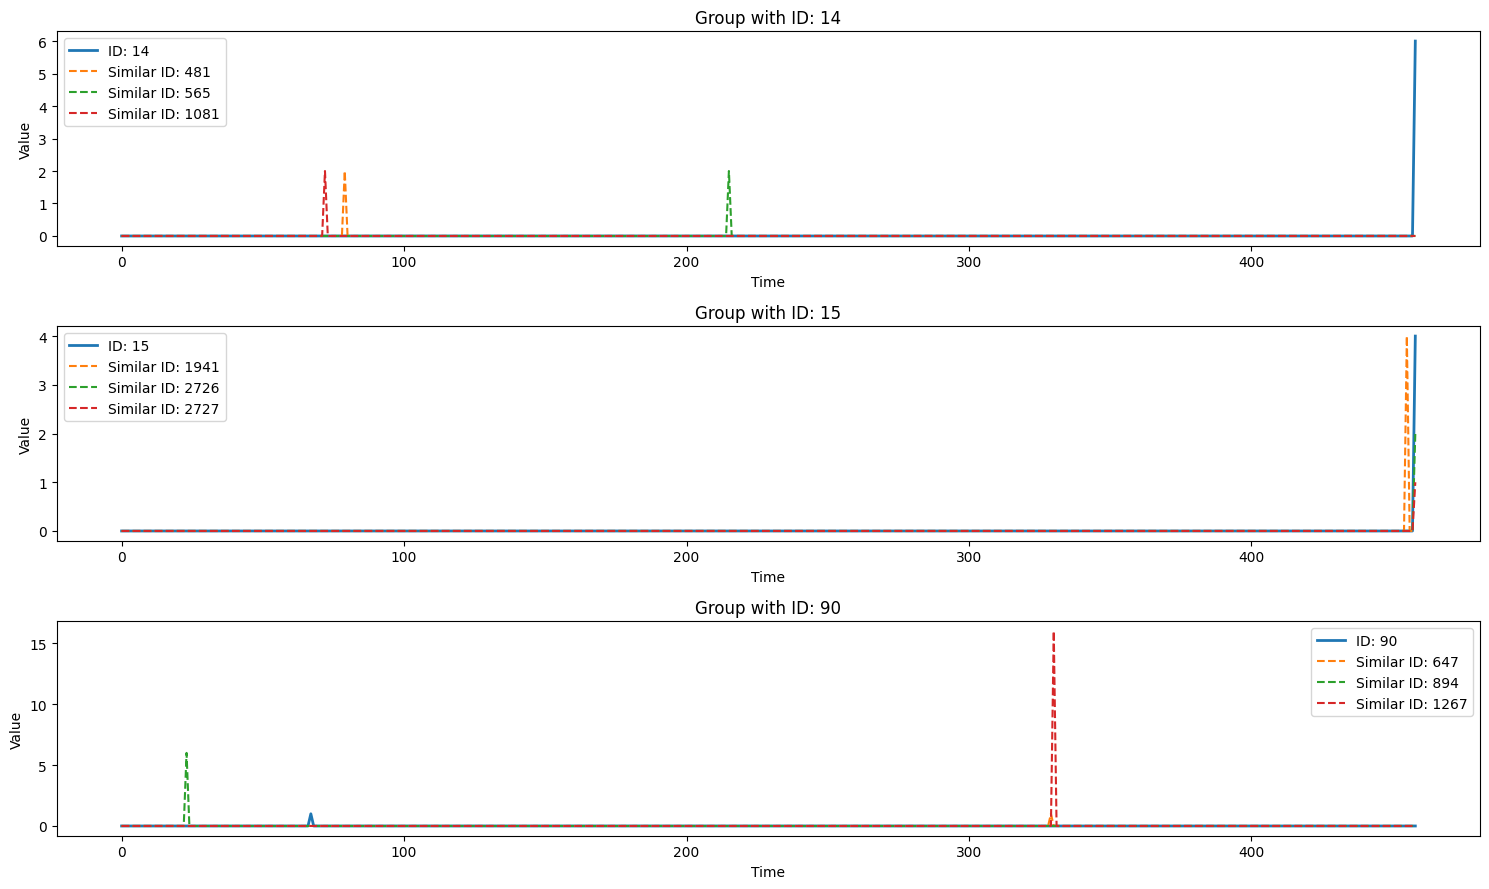

In [ ]:
# 샘플 그룹 선택 (위에서 분석한 샘플 그룹 사용)
sample_group_ids = list(sample_groups.keys())

plt.figure(figsize=(15, len(sample_group_ids) * 3))

# 각 샘플 그룹에 대해 시계열 그리기
for i, group_id in enumerate(sample_group_ids):
    plt.subplot(len(sample_group_ids), 1, i + 1)

    # 해당 그룹의 ID들의 시계열을 그립니다.
    plt.plot(train.iloc[group_id, 6:].values, label=f'ID: {group_id}', linewidth=2)
    for similar_id in sample_groups[group_id][:3]: # 처음 3개의 유사한 ID만 그립니다.
        plt.plot(train.iloc[similar_id, 6:].values, label=f'Similar ID: {similar_id}', linestyle='--')

    plt.title(f'Group with ID: {group_id}')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()

plt.tight_layout()
plt.show()


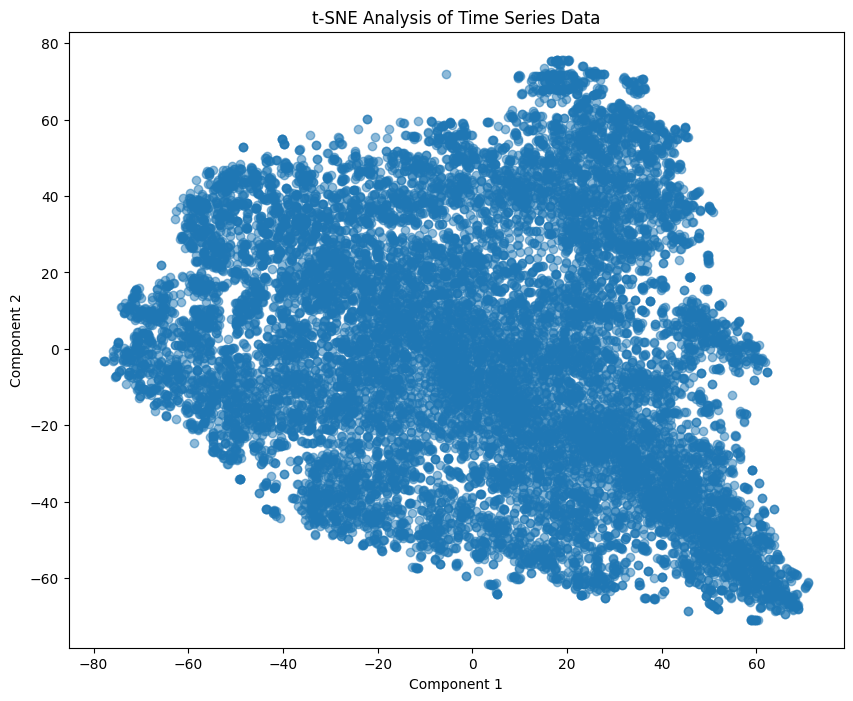

In [ ]:
from sklearn.manifold import TSNE

# 각 ID의 시계열 데이터를 벡터로 변환
time_series_data = train.iloc[:, 6:].values

# t-SNE 모델 생성 및 적용
tsne_model = TSNE(n_components=2, random_state=42)
tsne_results = tsne_model.fit_transform(time_series_data)

# 결과를 2D 그래프로 시각화
plt.figure(figsize=(10, 8))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], alpha=0.5)
plt.title('t-SNE Analysis of Time Series Data')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()


<ipython-input-26-f0c14389c526>:13: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linked_distance = linkage(distance_matrix, method='ward')


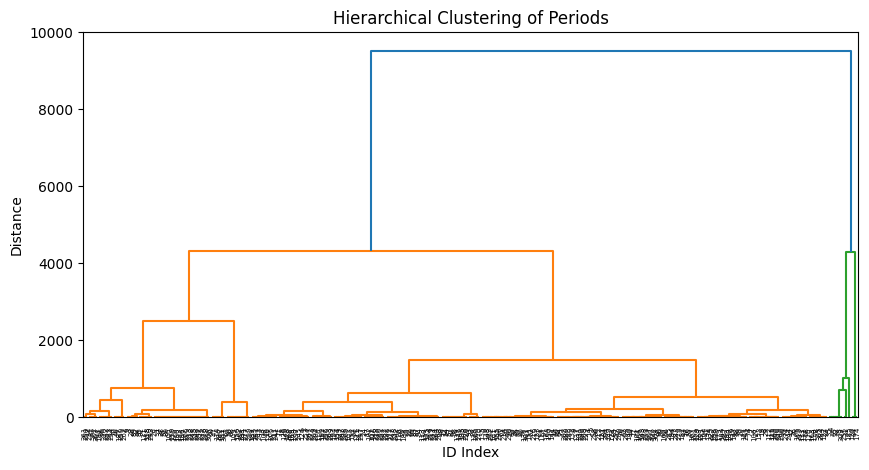

In [ ]:
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import dendrogram, linkage

# 주기 값만 추출
periods_values = list(id_period_dict.values())

periods_array = np.array(periods_values).reshape(-1, 1)

# 유클리드 거리를 기반으로 거리 행렬 계산
distance_matrix = squareform(pdist(periods_array))

# 계층적 클러스터링 수행
linked_distance = linkage(distance_matrix, method='ward')

# 덴드로그램으로 시각화
plt.figure(figsize=(10, 5))
dendrogram(linked_distance, orientation='top', distance_sort='descending', show_leaf_counts=True)
plt.title('Hierarchical Clustering of Periods')
plt.xlabel('ID Index')
plt.ylabel('Distance')
plt.show()


In [ ]:
from sklearn.cluster import SpectralClustering
from sklearn.metrics.pairwise import euclidean_distances

# 유클리드 거리를 기반으로 유사도 행렬 계산
similarity_matrix = euclidean_distances(periods_array)

# Spectral Clustering 수행 (클러스터 수는 예시로 5개로 설정)
spectral_clustering_model = SpectralClustering(n_clusters=5, affinity='nearest_neighbors', random_state=42)
spectral_labels = spectral_clustering_model.fit_predict(similarity_matrix)
spectral_labels

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_spectral.py:717: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


array([3, 0, 2, 4, 0, 3, 4, 1, 1, 3, 2, 1, 4, 2, 3, 3, 1, 2, 2, 1, 1, 3,
       2, 2, 2, 2, 0, 1, 4, 1, 3, 0, 4, 4, 0, 0, 1, 0, 0, 1, 3, 1, 1, 1,
       1, 3, 0, 0, 4, 3, 0, 0, 3, 2, 4, 1, 1, 4, 1, 1, 0, 3, 1, 0, 3, 0,
       3, 3, 0, 2, 0, 2, 0, 0, 1, 3, 1, 1, 2, 1, 0, 0, 4, 2, 3, 3, 0, 2,
       1, 4, 1, 4, 3, 4, 2, 4, 3, 3, 4, 2, 0, 1, 2, 2, 1, 1, 1, 2, 2, 0,
       2, 1, 1, 2, 0, 1, 2, 3, 1, 2, 0, 1, 2, 3, 2, 2, 2, 3, 2, 1, 2, 4,
       3, 1, 1, 3, 3, 3, 4, 4, 1, 3, 1, 1, 1, 4, 2, 1, 3, 3, 3, 3, 2, 1,
       2, 3, 0, 2, 4, 0, 1, 3, 0, 2, 3, 1, 1, 1, 2, 2, 2, 2, 2, 3, 0, 2,
       0, 2, 2, 1, 1, 0, 1, 2, 1, 0, 0, 0, 0, 2, 0, 0, 2, 0, 2, 4, 0, 0,
       1, 1, 3, 1, 3, 1, 2, 2, 0, 1, 4, 2, 4, 2, 3, 0, 3, 1, 3, 2, 2, 2,
       0, 1, 2, 2, 2, 1, 4, 2, 0, 3, 2, 3, 0, 0, 0, 0, 1, 2, 2, 1, 3, 2,
       2, 2, 1, 2, 1, 2, 0, 1, 0, 2, 0, 2, 0, 0, 2, 3, 3, 0, 4, 0, 0, 2,
       2, 2, 1, 2, 2, 3, 4, 0, 3, 2, 1, 0, 0, 0, 1, 1, 3, 2, 2, 1, 2, 1,
       3, 1, 0, 2, 3, 1, 3, 4, 2, 1, 3, 2, 2, 0, 1,

In [ ]:
from sklearn.cluster import SpectralClustering
from sklearn.metrics.pairwise import euclidean_distances

# 유클리드 거리를 기반으로 유사도 행렬 계산
similarity_matrix = euclidean_distances(periods_array)

# Spectral Clustering 수행 (클러스터 수는 예시로 5개로 설정)
spectral_clustering_model = SpectralClustering(n_clusters=5, affinity='nearest_neighbors', random_state=42)
spectral_labels = spectral_clustering_model.fit_predict(similarity_matrix)

# 결과 시각화
plt.scatter(tsne_results_sample[:, 0], tsne_results_sample[:, 1], c=spectral_labels[:1000], cmap='viridis', alpha=0.5)
plt.title('Spectral Clustering of Periods')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.colorbar(label='Cluster')
plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_spectral.py:717: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


ValueError: ignored

# 이진화 주기

In [ ]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.pairwise import cosine_similarity

# 판매량 이진화 (0이면 0, 0이 아니면 1)
binary_sales_data = train.iloc[:, 6:].applymap(lambda x: 0 if x == 0 else 1).values

# 코사인 유사도를 기반으로 유사도 행렬 계산
similarity_matrix_binary = cosine_similarity(binary_sales_data)

# 계층적 클러스터링 수행 (클러스터 수는 예시로 5개로 설정)
agglomerative_clustering_model = AgglomerativeClustering(n_clusters=5, affinity='precomputed', linkage='average')
binary_cluster_labels = agglomerative_clustering_model.fit_predict(1 - similarity_matrix_binary)

# 클러스터별 ID를 저장할 딕셔너리
binary_clustered_ids = {i: [] for i in range(5)}

# 레이블을 기반으로 클러스터별 ID 할당
for idx, label in zip(train['ID'], binary_cluster_labels):
    binary_clustered_ids[label].append(idx)

# 클러스터별 ID의 일부 출력
binary_clustered_ids_summary = {key: binary_clustered_ids[key][:5] for key in binary_clustered_ids.keys()}
binary_clustered_ids_summary


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


{0: [143, 240, 407, 513, 696],
 1: [0, 1, 2, 3, 4],
 2: [15577],
 3: [15501],
 4: [14831]}

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Fourier 변환을 수행하여 주파수와 그에 해당하는 크기를 반환하는 함수
def analyze_frequency(signal):
    fft_output = np.fft.fft(signal)
    magnitude = np.abs(fft_output)[:len(signal)//2]
    frequency = np.fft.fftfreq(len(signal))[:len(signal)//2]
    return frequency, magnitude

# 샘플로 5개의 ID를 선택하여 분석
sample_ids = train['ID'].sample(n=100, random_state=42)

plt.figure(figsize=(15, 10))
for idx in sample_ids:
    time_series_data = train.iloc[idx, 6:].values
    frequency, magnitude = analyze_frequency(time_series_data)

    plt.plot(frequency, magnitude, label=f'ID: {idx}')

plt.title('Frequency Analysis')
plt.xlabel('Frequency')
plt.ylabel('Magnitude')
plt.legend()
plt.show()

AttributeError: ignored

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage

# 클러스터간 거리 행렬 생성 (유사도 행렬을 거리로 변환)
distance_matrix_binary = 1 - similarity_matrix_binary

# 계층적 클러스터링 수행
linked_binary = linkage(distance_matrix_binary, method='average')

# 덴드로그램으로 시각화
plt.figure(figsize=(10, 5))
dendrogram(linked_binary, orientation='top', distance_sort='descending', show_leaf_counts=True)
plt.title('Hierarchical Clustering of Binary Sales Patterns')
plt.xlabel('Sample ID Index')
plt.ylabel('Distance')
plt.show()


In [ ]:
# 클러스터별 이진 패턴의 평균 계산
cluster_means = []
for cluster_label in range(5):
    cluster_data = sample_binary_sales_data[sample_binary_cluster_labels == cluster_label]
    cluster_mean = cluster_data.mean(axis=0)
    cluster_means.append(cluster_mean)

# 클러스터별 평균 패턴 시각화
plt.figure(figsize=(15, 7))
for cluster_label, cluster_mean in enumerate(cluster_means):
    plt.plot(cluster_mean, label=f'Cluster {cluster_label}')
plt.title('Average Binary Sales Patterns by Cluster')
plt.xlabel('Time')
plt.ylabel('Binary Sales Value')
plt.legend()
plt.show()


In [ ]:
from scipy.fft import fft

# 푸리에 변환을 통한 주기 분석
fft_results = fft(binary_sales_data)

# 주파수 성분의 절대값 계산 (복소수를 실수로 변환)
fft_magnitudes = np.abs(fft_results)

# 주파수 성분의 상위 5개를 특징으로 선택
top_freq_components = np.sort(fft_magnitudes, axis=1)[:, -5:]

# 유사도 측정 (코사인 유사도 사용)
top_freq_similarity_matrix = cosine_similarity(top_freq_components)

# 계층적 클러스터링 수행
freq_agglomerative_clustering_model = AgglomerativeClustering(n_clusters=n_clusters, affinity='precomputed', linkage='average')
freq_cluster_labels = freq_agglomerative_clustering_model.fit_predict(1 - top_freq_similarity_matrix)

# 클러스터별 ID를 저장할 딕셔너리
freq_clustered_ids = {i: [] for i in range(n_clusters)}

# 레이블을 기반으로 클러스터별 ID 할당
for idx, label in zip(train['ID'], freq_cluster_labels):
    freq_clustered_ids[label].append(idx)

# 클러스터별 ID의 일부 출력
freq_clustered_ids_summary = {key: freq_clustered_ids[key][:5] for key in freq_clustered_ids.keys()}
freq_clustered_ids_summary
